In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer

# 데이터 살펴보기


## 데이터 불러오기

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/netflix_titles.csv')
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
data.shape

(8807, 12)

## 결측치 확인 및 처리

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [ ]:
data.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

결측치가 많이 있는 칼럼은 Director, Cast, Country 이렇게 세 가지이다. 따로 빼거나 다른 값으로 바꾸어주지 않고, 있는 정보만 사용하기로 하였다. 결측치가 있는 칼럼을 활용할 경우, 따로 해당 정보를 다른 변수에 저장하고 dropna()를 처리한 후 이용한다. (결측치가 적은 date_added, rating, duration도 동일하게 사용)
## 데이터 전처리



### date_added 전처리
정확한 날짜에 관한 정보가 있는데, 이는 불필요하게 자세하기 때문에 년,월 단위로 나누어 새로운 칼럼 year_added, month_added에 추가하도록 한다. 

In [ ]:
# date_added 칼럼에 결측치가 존재하기 때문에 netflix_date에 새로 할당
netflix_date = data[['date_added']].dropna()
netflix_date['year'] = netflix_date['date_added'].apply(lambda x : x.split(', ')[-1])
netflix_date['month'] = netflix_date['date_added'].apply(lambda x : x.lstrip().split(' ')[0])
# data에 반영
data['year_added'] = netflix_date['date_added'].apply(lambda x : x.split(', ')[-1]).astype('int')
data['month_added'] = netflix_date['date_added'].apply(lambda x : x.lstrip().split(' ')[0])
netflix_date.head()

,date_added,year,month
0,"September 25, 2021",2021,September
1,"September 24, 2021",2021,September
2,"September 24, 2021",2021,September
3,"September 24, 2021",2021,September
4,"September 24, 2021",2021,September


### country 전처리
국가 데이터에는 결측치가 많이 존재하기 때문에, 이를 drop한 후에 countries에 새로 할당한다. 또한 국가 데이터는 다음과 같이 복수 개가 있는 칸이 있는데, 이중 첫 번째 국가만 사용하도록 한다. 이를 'first_country'에 새로 할당한다. 

In [ ]:
countries=data[['country']].dropna()
countries['country']=countries['country'].apply(lambda x: x.split(", "))
countries['num'] = countries['country'].apply(lambda x: len(x))
countries

,country,num
0,[United States],1
1,[South Africa],1
4,[India],1
7,"[United States, Ghana, Burkina Faso, United Ki...",6
8,[United Kingdom],1
...,...,...
8801,"[United Arab Emirates, Jordan]",2
8802,[United States],1
8804,[United States],1
8805,[United States],1


In [ ]:
countries['num'].value_counts()

1     6660
2      869
3      273
4      115
5       36
6       14
7        5
8        2
12       1
10       1
Name: num, dtype: int64

In [ ]:
# 국가 데이터를 활용할 때 사용할 countries
# first_country 할당
countries=data.dropna(subset=['country']).copy()
countries['first_country']=countries['country'].apply(lambda x: x.split(", ")[0])
countries

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,first_country
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,September,United States
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,September,South Africa
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,September,India
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",2021.0,September,United States
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...,2021.0,September,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8801,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan","March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,2016.0,March,United Arab Emirates
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",2019.0,November,United States
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,2019.0,November,United States
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",2020.0,January,United States


### ratings 전처리

In [ ]:
data.groupby('rating').size().sort_values(ascending=False).head(20)

rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
UR             3
NC-17          3
74 min         1
84 min         1
66 min         1
dtype: int64

74 min, 84 min, 66 min의 이상치가 발견되었다. 이를 NaN으로 변환하여, 이후에 dropna()로 빼고 진행하겠다. 이전에 결측치 확인할때 rating에 4개 칸이 NaN인 것을 확인하였다. 위의 3 값도 NaN으로 변환하면 결측치는 총 7개가 될 것이다. 

In [ ]:
data['rating'] = data['rating'].dropna().apply(lambda x: np.NaN if x.split(" ")[-1]=='min' else x)
data['rating'].isna().sum()

7

In [ ]:
# 8807->8800
ratings = data.dropna(subset=['rating']).copy()
ratings.shape

(8800, 14)

In [ ]:
# rating을 범주로 나눠준다. 
#data['rating_band'] = 0

#data.loc[data['rating']=='TV-MA', 'rating_band'] = 4
#data.loc[data['rating']=='R', 'rating_band'] = 4
#data.loc[data['rating']=='NC-17', 'rating_band'] = 4

#data.loc[data['rating']=='TV-14', 'rating_band'] = 3
#data.loc[data['rating']=='TV-PG', 'rating_band'] = 3
#data.loc[data['rating']=='PG-13', 'rating_band'] = 3
#data.loc[data['rating']=='PG', 'rating_band'] = 3

#data.loc[data['rating']=='TV-Y7', 'rating_band'] = 2
#data.loc[data['rating']=='TV-Y7-FV', 'rating_band'] = 2

#data.loc[data['rating']=='TV-Y', 'rating_band'] = 1
#data.loc[data['rating']=='TV-G', 'rating_band'] = 1
#data.loc[data['rating']=='G', 'rating_band'] = 1

#data.loc[data['rating']=='NR', 'rating_band'] = 0
#data.loc[data['rating']=='UR', 'rating_band'] = 0

#data

* **4**   18세이상: TV-MA, R, NC-17  
* **3**   15세이상: TV-14,TV-PG,PG-13,PG  
* **2**   7세 이상: TV-Y7, TV-Y7-FV  
* **1**   모든 연령층: TV-Y,TV-G,G  
* **0**   기타 : NR(NOT RATED), UR(UNRATED) , NAN

In [ ]:
# rating을 범주로 나눠준다. 
ratings['rating_band'] = 0

ratings.loc[ratings['rating']=='TV-MA', 'rating_band'] = 4
ratings.loc[ratings['rating']=='R', 'rating_band'] = 4
ratings.loc[ratings['rating']=='NC-17', 'rating_band'] = 4

ratings.loc[ratings['rating']=='TV-14', 'rating_band'] = 3
ratings.loc[ratings['rating']=='TV-PG', 'rating_band'] = 3
ratings.loc[ratings['rating']=='PG-13', 'rating_band'] = 3
ratings.loc[ratings['rating']=='PG', 'rating_band'] = 3

ratings.loc[ratings['rating']=='TV-Y7', 'rating_band'] = 2
ratings.loc[ratings['rating']=='TV-Y7-FV', 'rating_band'] = 2

ratings.loc[ratings['rating']=='TV-Y', 'rating_band'] = 1
ratings.loc[ratings['rating']=='TV-G', 'rating_band'] = 1
ratings.loc[ratings['rating']=='G', 'rating_band'] = 1

ratings.loc[ratings['rating']=='NR', 'rating_band'] = 0
ratings.loc[ratings['rating']=='UR', 'rating_band'] = 0

ratings

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,rating_band
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,September,3
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,September,4
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,September,4
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,September,4
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,September,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",2019.0,November,4
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",2019.0,July,2
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,2019.0,November,4
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",2020.0,January,3


In [ ]:
ratings.rating_band.isna().sum()

0

In [ ]:
ratings['rating_band'].value_counts().to_frame()

,rating_band
4,4009
3,3800
1,568
2,340
0,83


### type 전처리 + listed_in 전처리
데이터의 type에 따라 영화와 TV Show로 나뉘는데, 이 type에 따라 listed_in칼럼의 장르 종류도 나뉘게 된다. 그에 따라 영화와 TV Show 데이터로 분리하여 사용을 하겠다. listed_in의 장르는 복수 개로 존재하기도 하기 때문에 이 정보가 모두 반영이 되도록 one-hot-encoding을 진행한다. 

In [ ]:
# 장르 고유값 리스트로
original_genres = [x.split(', ') for x in data['listed_in']]
genres = np.unique(sum(original_genres, []))
genres

array(['Action & Adventure', 'Anime Features', 'Anime Series',
       'British TV Shows', 'Children & Family Movies',
       'Classic & Cult TV', 'Classic Movies', 'Comedies',
       'Crime TV Shows', 'Cult Movies', 'Documentaries', 'Docuseries',
       'Dramas', 'Faith & Spirituality', 'Horror Movies',
       'Independent Movies', 'International Movies',
       'International TV Shows', "Kids' TV", 'Korean TV Shows',
       'LGBTQ Movies', 'Movies', 'Music & Musicals', 'Reality TV',
       'Romantic Movies', 'Romantic TV Shows', 'Sci-Fi & Fantasy',
       'Science & Nature TV', 'Spanish-Language TV Shows',
       'Sports Movies', 'Stand-Up Comedy', 'Stand-Up Comedy & Talk Shows',
       'TV Action & Adventure', 'TV Comedies', 'TV Dramas', 'TV Horror',
       'TV Mysteries', 'TV Sci-Fi & Fantasy', 'TV Shows', 'TV Thrillers',
       'Teen TV Shows', 'Thrillers'], dtype='<U28')

In [ ]:
# 장르 개수
len(genres)

42

In [ ]:
# listed_in 장르로 one-hot encoding
data['listed_in'] = [x.split(', ') for x in data['listed_in']]
genre_data = MultiLabelBinarizer(classes=genres).fit_transform(data['listed_in'].values)
df = pd.DataFrame(columns=genres, data=genre_data, index=data.index)
df.head()

,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# data에 one-hot encoding 추가
orig_data = data.copy()
data = pd.concat([data, df], axis=1)
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,...,0,0,0,0,0,0,0,0,0,0
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,...,0,0,1,0,1,0,0,0,0,0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,...,1,0,0,0,0,0,0,0,0,0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,...,0,0,0,0,0,0,0,0,0,0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# 영화 데이터와 드라마 데이터를 movie와 tv에 할당
movie = data[data['type']=='Movie']
tv = data[data['type']=='TV Show']
movie.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,...,0,0,0,0,0,0,0,0,0,0
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,...,0,0,0,0,0,0,0,0,0,0
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,...,0,0,0,0,0,0,0,0,0,0
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,...,0,0,0,0,0,0,0,0,0,0
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tv.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,...,0,0,1,0,1,0,0,0,0,0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,...,1,0,0,0,0,0,0,0,0,0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,...,0,0,0,0,0,0,0,0,0,0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,...,0,1,0,0,0,0,0,0,0,0
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1 Season,...,0,0,1,1,1,0,0,0,0,0


In [ ]:
# 영화에 사용되는 장르 분포
movie_labels = movie.iloc[:,14:].sum()
movie_labels = movie_labels[movie_labels>0]
print(len(movie_labels))
movie_labels

20


Action & Adventure           859
Anime Features                71
Children & Family Movies     641
Classic Movies               116
Comedies                    1674
Cult Movies                   71
Documentaries                869
Dramas                      2427
Faith & Spirituality          65
Horror Movies                357
Independent Movies           756
International Movies        2752
LGBTQ Movies                 102
Movies                        57
Music & Musicals             375
Romantic Movies              616
Sci-Fi & Fantasy             243
Sports Movies                219
Stand-Up Comedy              343
Thrillers                    577
dtype: int64

In [ ]:
# 드라마에 사용되는 장르 분포
tv_labels = tv.iloc[:,14:].sum()
tv_labels = tv_labels[tv_labels>0]
print(len(tv_labels))
tv_labels

22


Anime Series                     176
British TV Shows                 253
Classic & Cult TV                 28
Crime TV Shows                   470
Docuseries                       395
International TV Shows          1351
Kids' TV                         451
Korean TV Shows                  151
Reality TV                       255
Romantic TV Shows                370
Science & Nature TV               92
Spanish-Language TV Shows        174
Stand-Up Comedy & Talk Shows      56
TV Action & Adventure            168
TV Comedies                      581
TV Dramas                        763
TV Horror                         75
TV Mysteries                      98
TV Sci-Fi & Fantasy               84
TV Shows                          16
TV Thrillers                      57
Teen TV Shows                     69
dtype: int64

In [ ]:
movie_genres=list(movie_labels.index)
movie_genres

['Action & Adventure',
 'Anime Features',
 'Children & Family Movies',
 'Classic Movies',
 'Comedies',
 'Cult Movies',
 'Documentaries',
 'Dramas',
 'Faith & Spirituality',
 'Horror Movies',
 'Independent Movies',
 'International Movies',
 'LGBTQ Movies',
 'Movies',
 'Music & Musicals',
 'Romantic Movies',
 'Sci-Fi & Fantasy',
 'Sports Movies',
 'Stand-Up Comedy',
 'Thrillers']

In [ ]:
tv_genres=list(tv_labels.index)
tv_genres

['Anime Series',
 'British TV Shows',
 'Classic & Cult TV',
 'Crime TV Shows',
 'Docuseries',
 'International TV Shows',
 "Kids' TV",
 'Korean TV Shows',
 'Reality TV',
 'Romantic TV Shows',
 'Science & Nature TV',
 'Spanish-Language TV Shows',
 'Stand-Up Comedy & Talk Shows',
 'TV Action & Adventure',
 'TV Comedies',
 'TV Dramas',
 'TV Horror',
 'TV Mysteries',
 'TV Sci-Fi & Fantasy',
 'TV Shows',
 'TV Thrillers',
 'Teen TV Shows']

In [ ]:
# 영화 데이터 one-hot encoding
movie = orig_data[orig_data['type']=='Movie']
movie_genre_data = MultiLabelBinarizer(classes=movie_genres).fit_transform(movie['listed_in'].values)
df = pd.DataFrame(columns=movie_genres, data=movie_genre_data, index=movie.index)
df.head()

,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# 영화 데이터에 one-hot encoding 추가
movie = pd.concat([movie, df], axis=1)
movie.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,...,0,0,0,0,0,0,0,0,0,0
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,...,0,0,0,0,0,0,0,0,0,0
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,...,1,1,0,0,0,0,0,0,0,0
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,...,0,0,0,0,0,0,0,0,0,0
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# 드라마 데이터 one-hot encoding
tv = orig_data[orig_data['type']=='TV Show']
tv_genre_data = MultiLabelBinarizer(classes=tv_genres).fit_transform(tv['listed_in'].values)
df = pd.DataFrame(columns=tv_genres, data=tv_genre_data, index=tv.index)
df.head()

,Anime Series,British TV Shows,Classic & Cult TV,Crime TV Shows,Docuseries,International TV Shows,Kids' TV,Korean TV Shows,Reality TV,Romantic TV Shows,...,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0


In [ ]:
# 영화 데이터에 one-hot encoding 추가
tv = pd.concat([tv, df], axis=1)
tv.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,...,0,0,0,1,0,1,0,0,0,0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,...,0,1,0,0,0,0,0,0,0,0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,...,0,0,0,0,0,0,0,0,0,0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,...,0,0,1,0,0,0,0,0,0,0
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1 Season,...,0,0,0,1,1,1,0,0,0,0


## 칼럼별 데이터 분포 시각화 

### type 칼럼

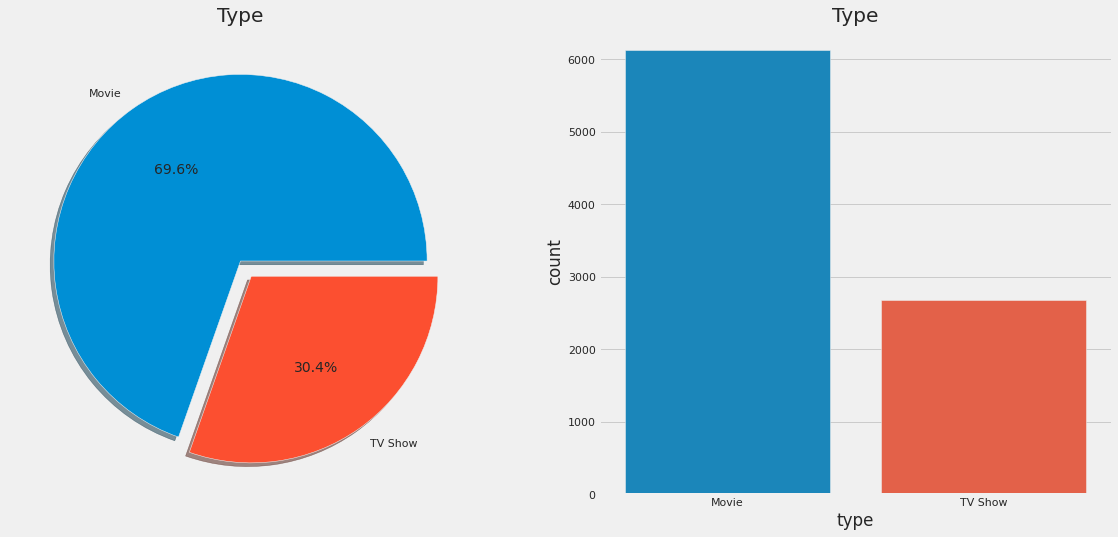

In [ ]:
# type
%matplotlib inline
plt.style.use('fivethirtyeight')

f, ax = plt.subplots(1, 2, figsize = (18,8))

data['type'].value_counts().plot.pie(explode=[0,0.1], autopct = '%1.1f%%', ax = ax[0], shadow=True)

ax[0].set_title('Type')
ax[0].set_ylabel('')

sns.countplot('type', data = data, ax = ax[1])
ax[1].set_title('Type')

plt.show()

In [ ]:
data.groupby('type').size()

type
Movie      6131
TV Show    2676
dtype: int64

전체 데이터의 약 70%가 영화임을 알 수 있다. \
후에 데이터 간 관계를 볼 때 Movie 데이터와 TV Show 데이터를 나누어 살펴본다.

### country 칼럼

In [ ]:
print(len(countries['first_country'].unique()))
countries['first_country'].unique()

89


array(['United States', 'South Africa', 'India', 'United Kingdom',
       'Germany', 'Mexico', 'Turkey', 'Australia', 'Finland', 'China',
       'Nigeria', 'Japan', 'Spain', 'France', 'Belgium', 'South Korea',
       'Argentina', 'Russia', 'Canada', 'Hong Kong', 'Italy', '',
       'Ireland', 'New Zealand', 'Jordan', 'Colombia', 'Switzerland',
       'Israel', 'Brazil', 'Taiwan', 'Bulgaria', 'Poland', 'Saudi Arabia',
       'Thailand', 'Indonesia', 'Egypt', 'Kuwait', 'Malaysia', 'Vietnam',
       'Sweden', 'Lebanon', 'Romania', 'Philippines', 'Iceland',
       'Denmark', 'United Arab Emirates', 'Netherlands', 'Norway',
       'Syria', 'Mauritius', 'Austria', 'Czech Republic', 'Cameroon',
       'Uruguay', 'United Kingdom,', 'Kenya', 'Chile', 'Luxembourg',
       'Bangladesh', 'Portugal', 'Hungary', 'Senegal', 'Singapore',
       'Serbia', 'Namibia', 'Peru', 'Mozambique', 'Belarus', 'Ghana',
       'Zimbabwe', 'Puerto Rico', 'Pakistan', 'Cyprus', 'Paraguay',
       'Croatia', 'United St

89개의 국가가 포함되어 있음을 알 수 있다.

국가별로 넷플릭스에 추가된 컨텐츠를 살펴본다.

In [ ]:
country_count = countries['first_country'].value_counts()

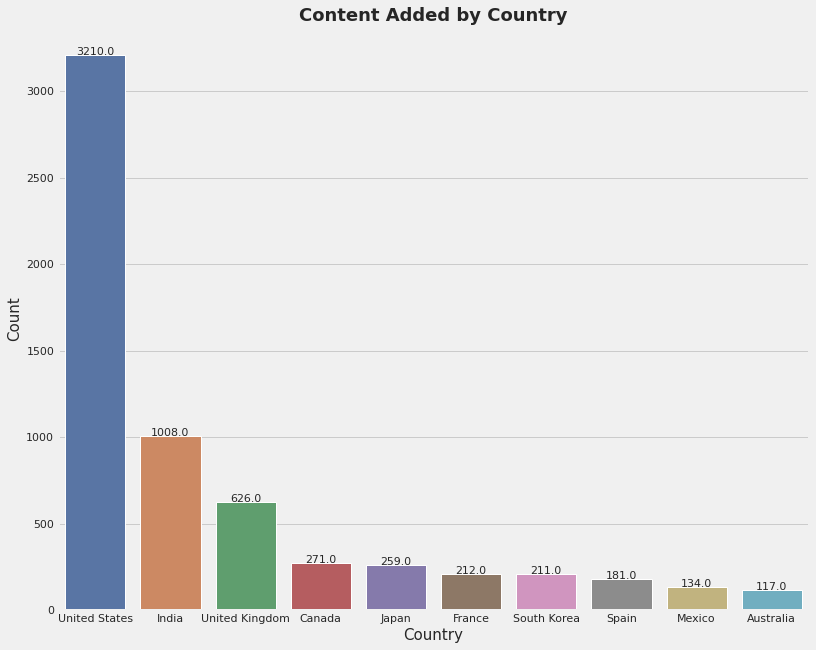

In [ ]:
countplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
ax = sns.barplot(x=country_count.index[:10], y=country_count[:10])
ax.set_title('Content Added by Country',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

### date_added 칼럼
넷플릭스에 컨텐츠가 추가된 날짜를 의미한다.\
일월연도가 다 나타나 있기 때문에 연도와 월별로 나누어 살펴본다.

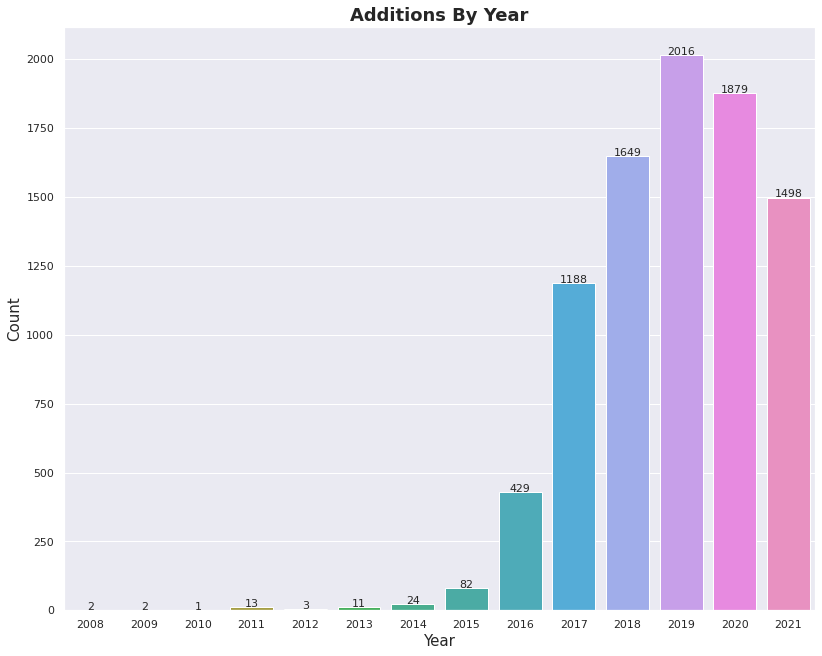

In [ ]:
countplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
year_order = map(str, range(2008,2022))
ax = sns.countplot(x='year', data=netflix_date, order=year_order)
ax.set_title('Additions By Year',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

2015년부터 콘텐츠가 급격하게 추가된 것을 볼 수 있다.

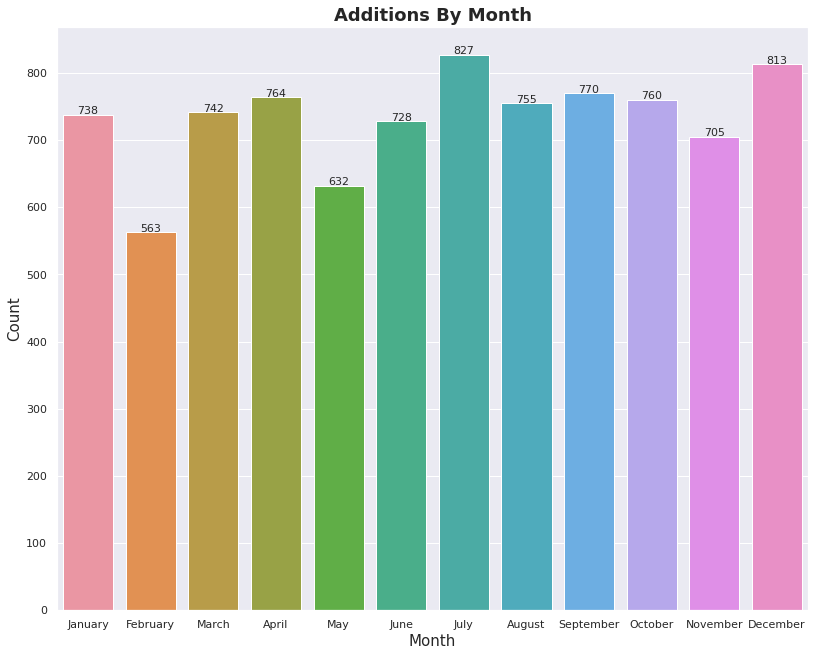

In [ ]:
countplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax = sns.countplot(x='month', data=netflix_date, order=month_order)
ax.set_title('Additions By Month',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Month', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

### release_year 칼럼
콘텐츠가 개봉된 연도를 나타낸다.

2018년에 개봉된 영화가 가장 많이 있음을 볼 수 있다.

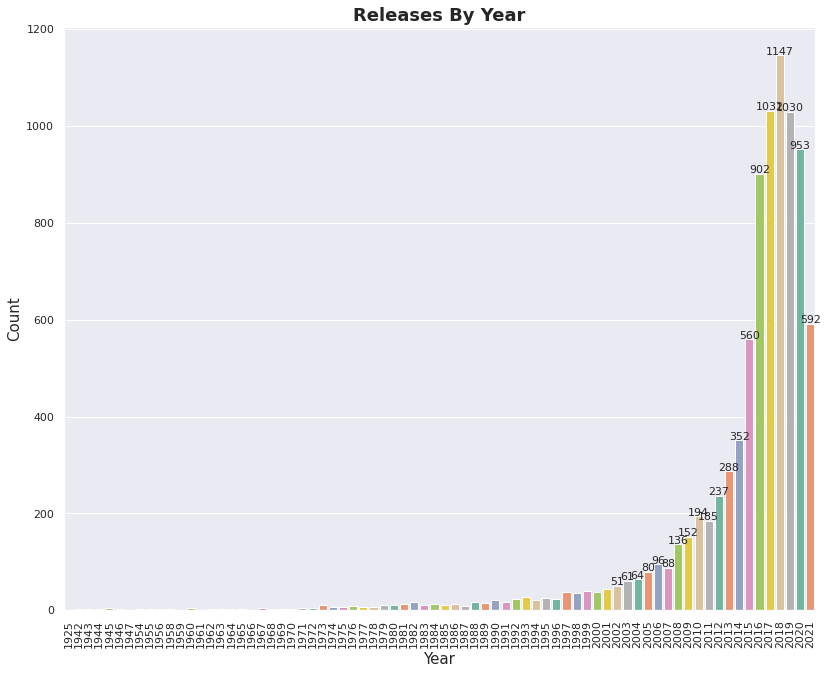

In [ ]:
countplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='release_year', data=data, palette='Set2')
plt.xticks(rotation='vertical')
ax.set_title('Releases By Year',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches[-20:]:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

### rating 칼럼
콘텐츠의 관람 등급을 나타낸다.
- 4: 18세이상: TV-MA, R, NC-17 
- 3: 15세이상: TV-14,TV-PG, PG-13, PG
- 2: 7세 이상: TV-Y7, TV-Y7-FV
- 1: 모든 연령층: TV-Y, TV-G, G
- 0: 기타 : NR(NOT RATED), UR(UNRATED) , NAN 

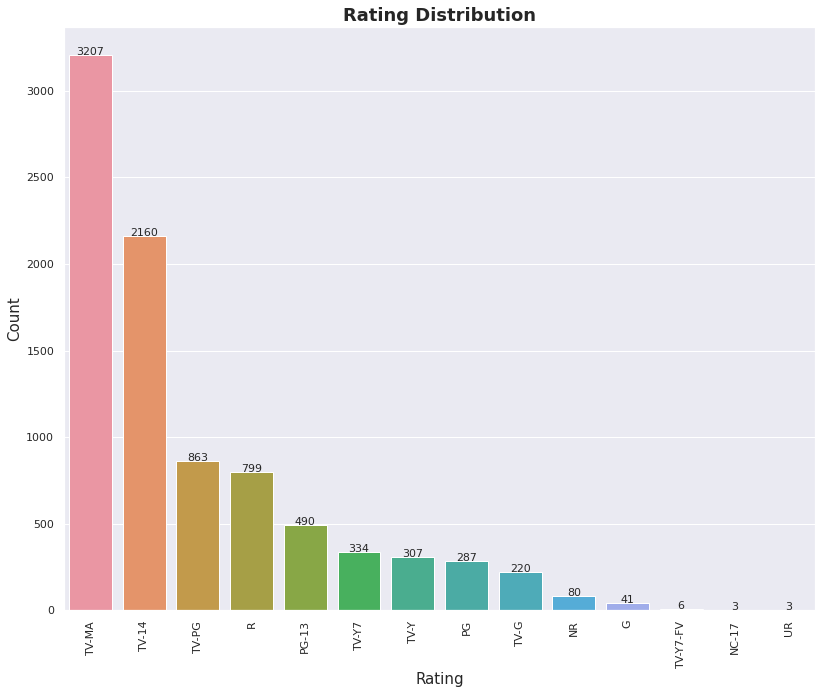

In [ ]:
countplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='rating', data=ratings, order=ratings['rating'].value_counts().index)
plt.xticks(rotation='vertical')
ax.set_title('Rating Distribution',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Rating', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches[-20:]:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

TV-MA 와 TV-14 등급을 가진 영상이 다른 등급에 비해 많이 나타나고 있다.\
이는 각각 18세 이상 등급과 14세 이상의 등급을 가진 것으로, 넷플릭스에는 청소년 관람 불가 등급의 영상이 많이 있음을 알 수 있다. \
(넷플릭스의 주 타겟층이 성인?)

### duration 칼럼
영상의 시간을 의미한다. 영화의 경우 재생시간, tv show의 경우 시즌 개수로 나타나 있다.

영상 시간의 계산을 위해 float으로 형변환을 해준다.

In [ ]:
# duration
data['duration']
# duration dtype: object -> string 변환
data['duration'] = data['duration'].astype('string')

# duration에 있는 문자 제거, 숫자만 남김
# float 형 변환
data['duration'] = data['duration'].replace(to_replace='min', value='', regex=True)
data['duration'] = data['duration'].replace(to_replace='Seasons', value='', regex=True)
data['duration'] = data['duration'].replace(to_replace='Season', value='', regex=True)
data['duration'] = data['duration'].astype('float')
data['duration']

0        90.0
1         2.0
2         1.0
3         1.0
4         2.0
        ...  
8802    158.0
8803      2.0
8804     88.0
8805     88.0
8806    111.0
Name: duration, Length: 8807, dtype: float64

In [ ]:
# movie duration max 값 확인
data[data['type']=='Movie'].duration
print('movie duration max 값 확인', data[data['type']=='Movie'].duration.max())
# tv show max 값 확인
data[data['type']=='TV Show'].duration
print('tv show max 값 확인', data[data['type']=='TV Show'].duration.max())

movie duration max 값 확인 312.0
tv show max 값 확인 17.0


In [ ]:
# tv show 최다 시즌 인덱스
data[data['type']=='TV Show'].duration.idxmax()
data[548:549]


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
548,s549,TV Show,Grey's Anatomy,NaN,"Ellen Pompeo, Sandra Oh, Katherine Heigl, Just...",United States,"July 3, 2021",2020,TV-14,17.0,...,0,0,1,0,0,0,0,0,0,0


17개의 최다 시즌을 가지고 있는 tv show는 "Grey's Anatomy" 임을 알 수 있다.

In [ ]:
# 영화 최장시간 인덱스
data.duration.idxmax()
data[4253:4254]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
4253,s4254,Movie,Black Mirror: Bandersnatch,NaN,"Fionn Whitehead, Will Poulter, Craig Parkinson...",United States,"December 28, 2018",2018,TV-MA,312.0,...,0,0,0,0,0,0,0,0,0,0


312분이라는 넷플릭스에서 가장 긴 러닝타임을 가진 영화는 "Black Mirror: Bandersnatch" 이다.

In [ ]:
# 가장 짧은 영화
data[data['type']=='Movie'].duration.idxmin()
data[3777:3778]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
3777,s3778,Movie,Silent,"Limbert Fabian, Brandon Oldenburg",NaN,United States,"June 4, 2019",2014,TV-Y,3.0,...,0,0,0,0,0,0,0,0,0,0


반면 가장 짧은 영화는 "Silent" 로, 3분의 러닝타임을 가진다.

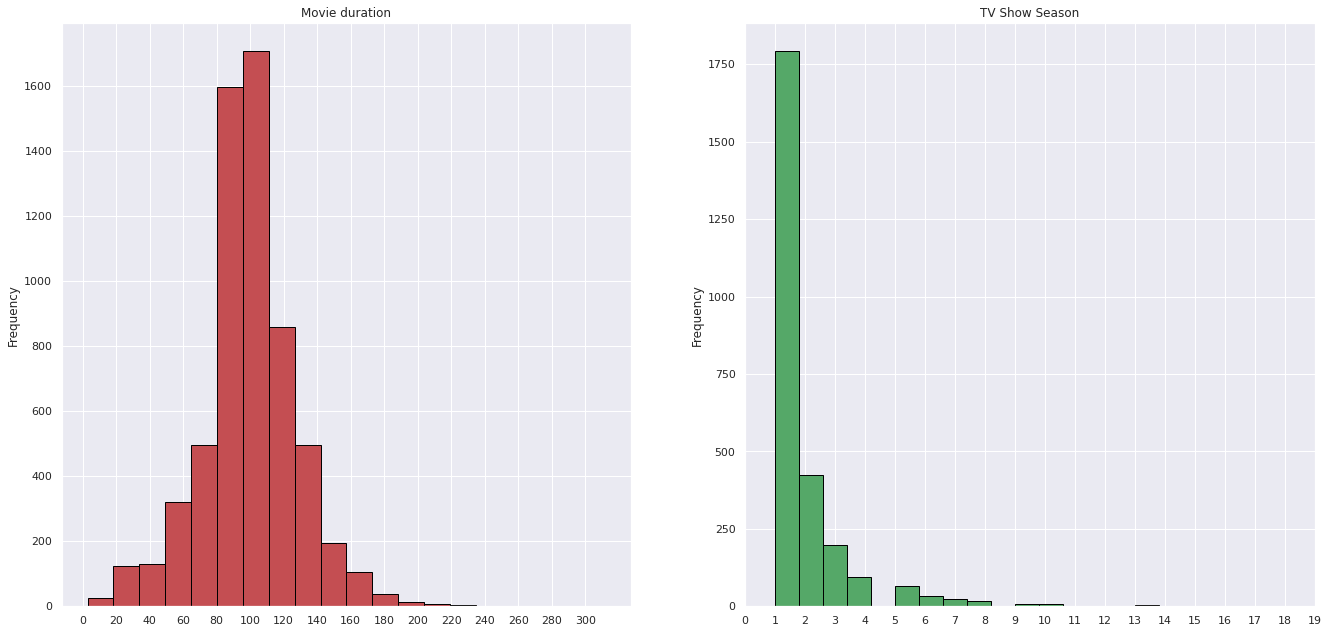

In [ ]:
# duration 히스토그램으로 확인하기
f, ax = plt.subplots(1, 2, figsize = (20,10))

x1 = list(range(0, 320, 20))

data[data['type']=='Movie'].duration.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='r')
ax[0].set_title('Movie duration')
ax[0].set_xticks(x1)

x2 = list(range(0, 20))

data[data['type']=='TV Show'].duration.plot.hist(ax=ax[1], bins=20, edgecolor='black', color='g')
ax[1].set_title('TV Show Season')
ax[1].set_xticks(x2)

plt.show()

영화의 경우 대부분이 80분에서 130분의 러닝 타임을 가지고 있고, \
tv show의 경우 시즌이 1개인 프로그램이 가장 많았다.

### listed_in 칼럼
콘텐츠의 장르를 나타내는 칼럼으로 하나의 컨텐츠가 여러 컬럼을 가진다.\
위에서 장르를 하나씩 분리했으니, 이를 통해 장르의 분포를 살펴본다.

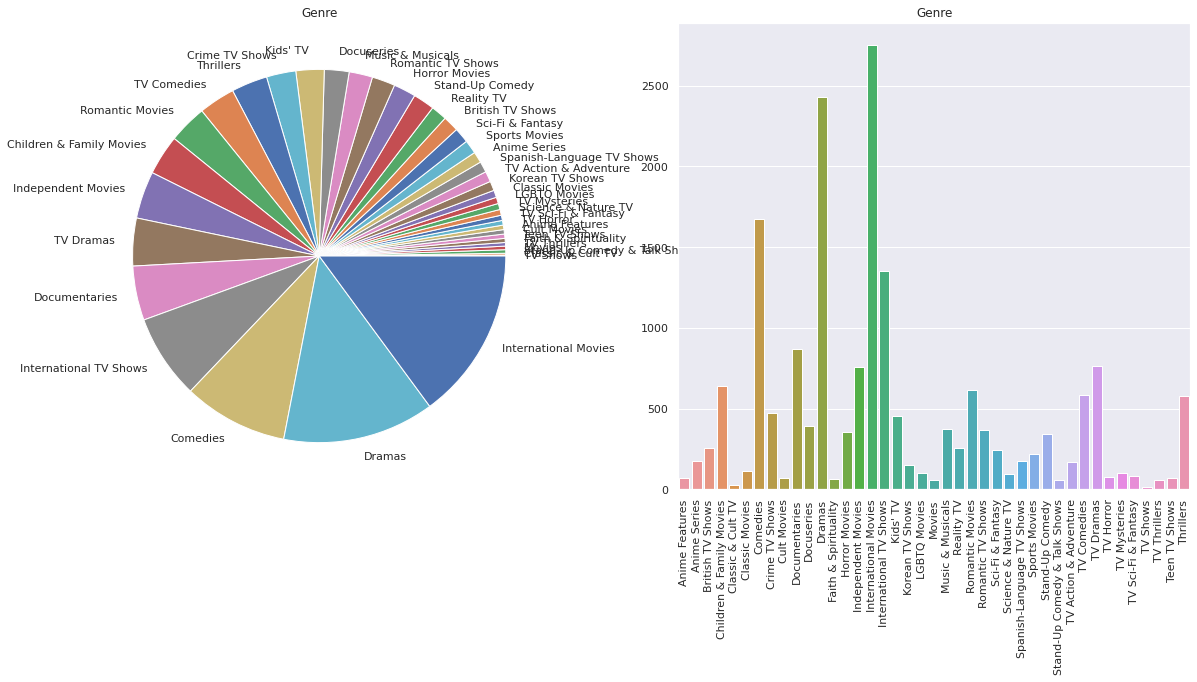

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (18,8))

data.iloc[:, 15:].sum().sort_values().plot.pie(ax = ax[0])

ax[0].set_title('Genre')
ax[0].set_ylabel('')

plt.xticks(rotation='vertical')

sns.barplot(x=data.iloc[:, 15:].sum().index, y=data.iloc[:,15:].sum())
ax[1].set_title('Genre')

plt.show()

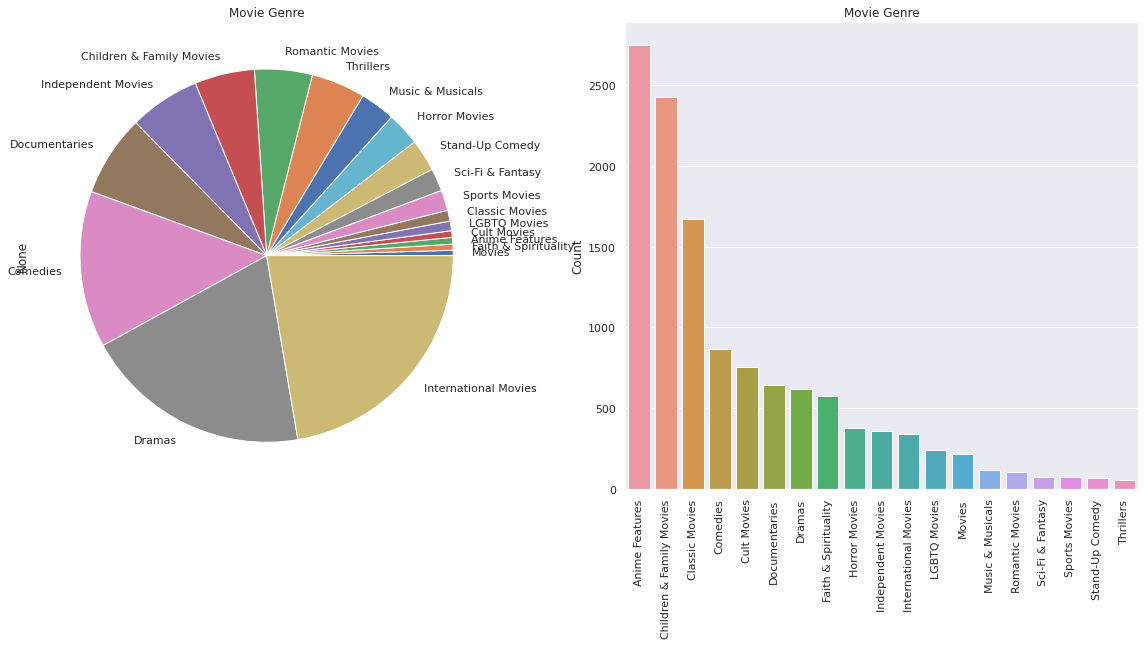

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (18,8))

movie.iloc[:, 15:].sum().sort_values().plot.pie(ax = ax[0])

ax[0].set_title('Movie Genre')

plt.xticks(rotation='vertical')

sns.barplot(x=movie.iloc[:, 15:].sum().index, y=movie.iloc[:,15:].sum().sort_values(ascending=False))
ax[1].set_title('Movie Genre')
ax[1].set_ylabel('Count')

plt.show()

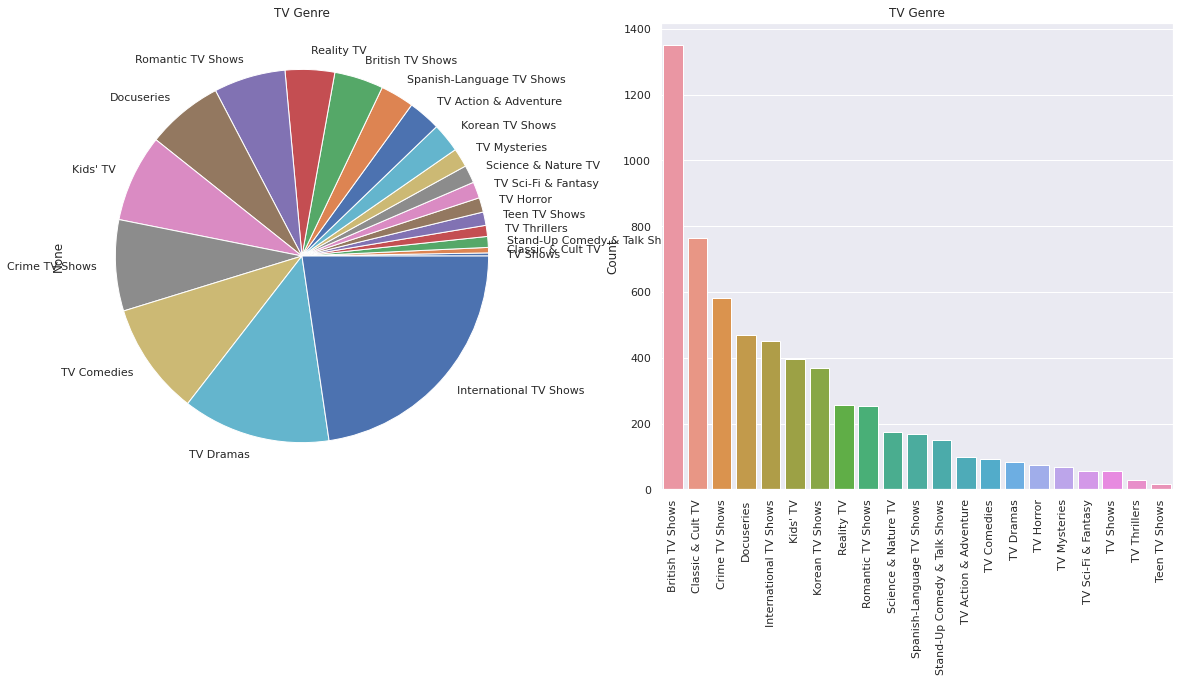

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (18,8))

tv.iloc[:, 15:].sum().sort_values().plot.pie(ax = ax[0])

ax[0].set_title('TV Genre')

plt.xticks(rotation='vertical')

sns.barplot(x=tv.iloc[:, 15:].sum().index, y=tv.iloc[:,15:].sum().sort_values(ascending=False))
ax[1].set_title('TV Genre')
ax[1].set_ylabel('Count')

plt.show()

**전체 데이터**에서 International Movies, Dramas, Comedies가 가장 높은 빈도 수를 가진다.\
**영화 데이터**에서도 전체 데이터와 마찬가지로 International Movies, Dramas, Comedies가 가장 많은데, 영화 데이터가 전체 데이터의 70%를 차지하는 만큼 전체 데이터에 영향을 미친 것 같다.\
**TV Show 데이터**에서는 International TV Shows, TV Dramas, TV Comedies가 많이 분포되어 있음을 알 수 있다.

# 변수간의 관계 확인

## 연도별로 점점 많은 영화나 드라마를 만드는 나라는 어디인가?



### 연도별 전체 컨텐츠 추가 추이

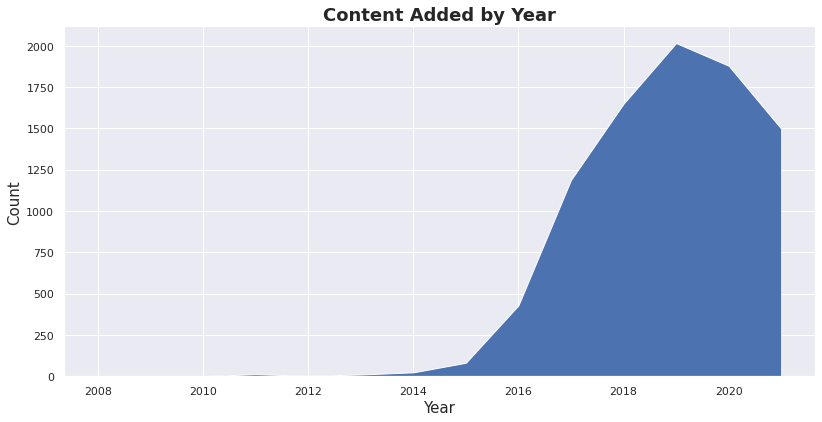

In [ ]:
total_count = data['year_added'].dropna().astype('uint64').value_counts().sort_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Content Added by Year',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
plt.stackplot(total_count.index, total_count)

2015년부터 콘텐츠가 급격히 추가되기 시작하여 2019년에 2천개가 넘는 콘텐츠 수로 정점을 찍었다. 

### 연도별 드라마/영화 추가 추이

In [ ]:
movie_count = movie['year_added'].astype('uint64').value_counts().sort_index()
tv_count = tv['year_added'].dropna().astype('uint64').value_counts().sort_index()

In [ ]:
movie_count

2008       1
2009       2
2010       1
2011      13
2012       3
2013       6
2014      19
2015      56
2016     253
2017     839
2018    1237
2019    1424
2020    1284
2021     993
Name: year_added, dtype: int64

In [ ]:
tv_count

2008      1
2013      5
2014      5
2015     26
2016    176
2017    349
2018    412
2019    592
2020    595
2021    505
Name: year_added, dtype: int64

In [ ]:
# index에 2009~2012년 값이 빠지기 때문에 직접 index를 맞추어준다
for i in range(2009, 2013):
  tv_count[i]=0
tv_count.sort_index(inplace=True)
tv_count

2008      1
2009      0
2010      0
2011      0
2012      0
2013      5
2014      5
2015     26
2016    176
2017    349
2018    412
2019    592
2020    595
2021    505
Name: year_added, dtype: int64

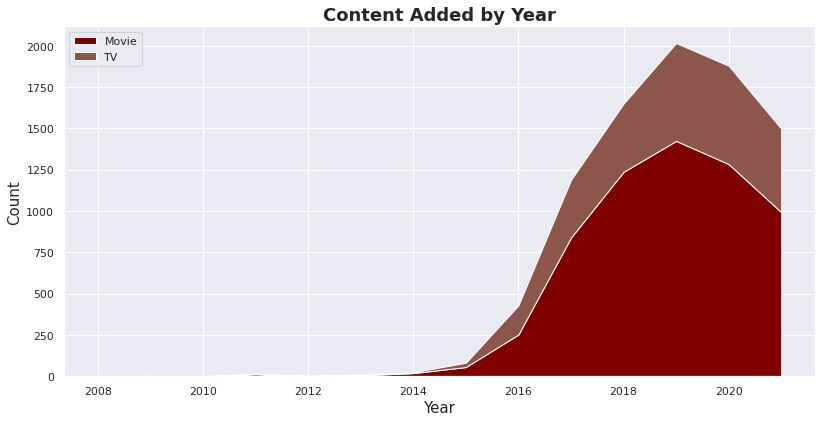

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color_map = ['maroon', 'tab:brown']
plt.stackplot(movie_count.index,[movie_count, tv_count], colors=color_map, labels=['Movie', 'TV'])
ax.set_title('Content Added by Year',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
plt.legend(loc='upper left')

> movie랑 tv 라벨이 바뀐 것 같은데 수정 필요

영화와 tv show의 추가 추이 그래프이다. 모두 2015년부터 시작하여 2019년에 추가 콘텐츠 수가 정점을 찍고 서서히 줄어드는 모습을 볼 수 있다. 

영화와 tv show를 따로 살펴본다.

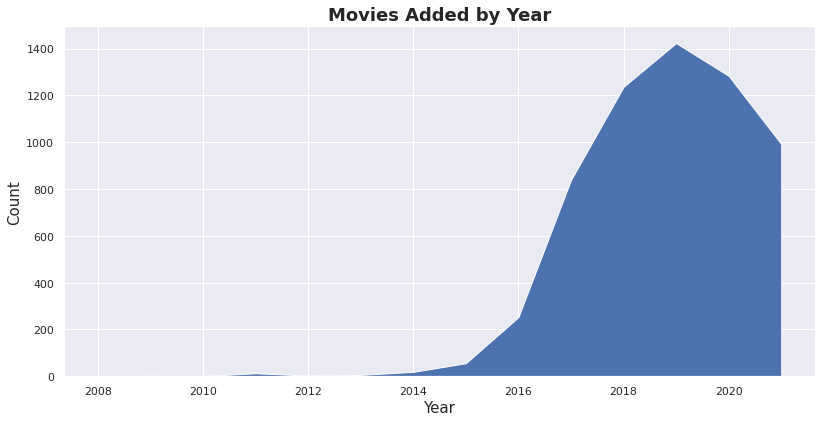

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Movies Added by Year',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
plt.stackplot(movie_count.index, movie_count)

영화의 경우, 2019년에 약 1400개의 영상이 추가되었다.

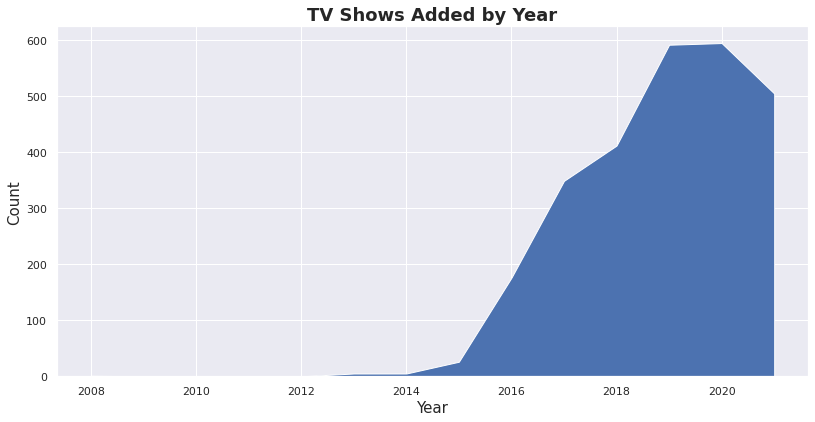

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('TV Shows Added by Year',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
plt.stackplot(tv_count.index, tv_count)

tv show의 경우 오히려 2020년에 가장 많은 영상이 추가되었는데, 아무래도 코로나의 영향 때문이 아닌가 싶다.

### 컨텐츠를 가장 많이 추가한 국가 Top 10

In [ ]:
country_count = countries['first_country'].value_counts()
country_count[:10]

United States     3210
India             1008
United Kingdom     626
Canada             271
Japan              259
France             212
South Korea        211
Spain              181
Mexico             134
Australia          117
Name: first_country, dtype: int64

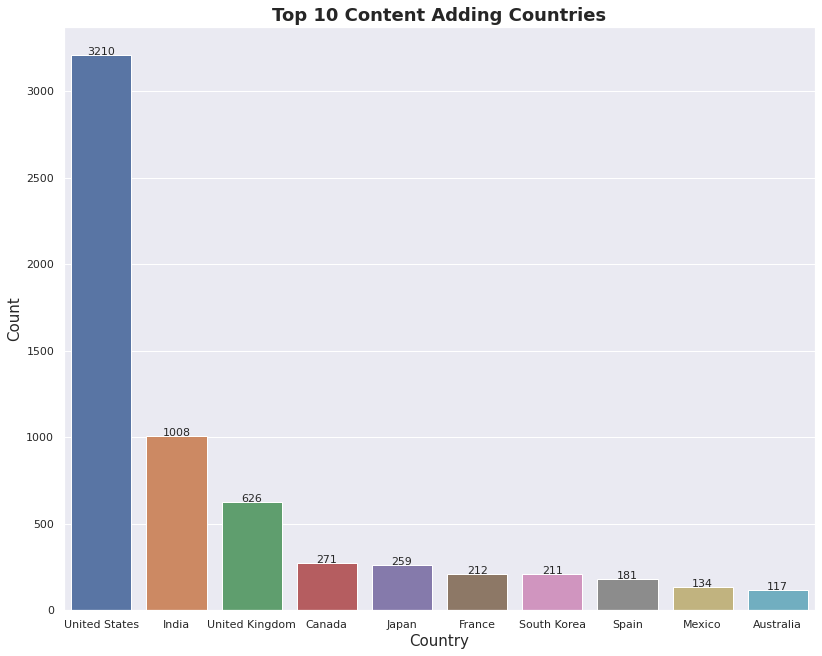

In [ ]:
barplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
ax = sns.barplot(x=country_count[:10].index, y=country_count[:10])
ax.set_title('Top 10 Content Adding Countries',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,int(rect.get_height()),horizontalalignment='center', fontsize = 11)

**미국**이 3,210개의 데이터로 가장 많은 컨텐츠를 가지고 있다. 이는 두 번째 순위인 인도콘텐츠 수의 약 3배에 달한다. 한국은 일곱 번째로, 211개의 컨텐츠를 가지고 있다.

### 영화를 가장 많이 추가한 국가 Top 10

In [ ]:
movie_country = movie.dropna(subset=['country']).copy()
movie_country['first_country']=movie_country['country'].apply(lambda x: x.split(", ")[0])
movie_country.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,first_country
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,...,0,0,0,0,0,0,0,0,0,United States
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,...,1,0,0,0,0,0,0,0,0,United States
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,...,0,0,0,0,0,0,0,0,0,United States
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,...,1,0,0,0,0,0,0,0,0,Germany
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,...,1,0,0,0,1,0,0,0,0,India


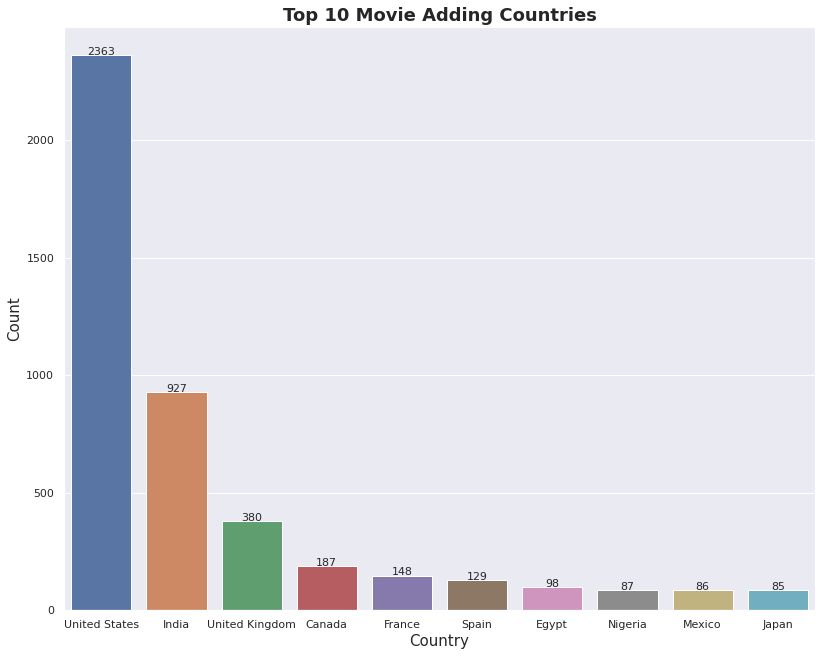

In [ ]:
movie_country_count = movie_country['first_country'].value_counts()
barplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
ax = sns.barplot(x=movie_country_count[:10].index, y=movie_country_count[:10])
ax.set_title('Top 10 Movie Adding Countries',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,int(rect.get_height()),horizontalalignment='center', fontsize = 11)

마찬가지로 영화도 미국, 인도 순으로 가장 많은 영상 수를 가진다.\
다만 전체 데이터에서 7위인 한국이 위 그래프에선 보이지 않는다. 

### TV Show를 가장 많이 추가한 국가 Top 10

In [ ]:
tv_country = tv.dropna(subset=['country']).copy()
tv_country['first_country']=tv_country['country'].apply(lambda x: x.split(", ")[0])
tv_country.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,first_country
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,...,0,0,1,0,1,0,0,0,0,South Africa
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,...,0,1,0,0,0,0,0,0,0,India
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,...,0,0,0,0,0,0,0,0,0,United Kingdom
15,s16,TV Show,Dear White People,NaN,"Logan Browning, Brandon P. Bell, DeRon Horton,...",United States,"September 22, 2021",2021,TV-MA,4 Seasons,...,0,1,1,0,0,0,0,0,0,United States
17,s18,TV Show,Falsa identidad,NaN,"Luis Ernesto Franco, Camila Sodi, Sergio Goyri...",Mexico,"September 22, 2021",2020,TV-MA,2 Seasons,...,0,0,1,0,0,0,0,0,0,Mexico


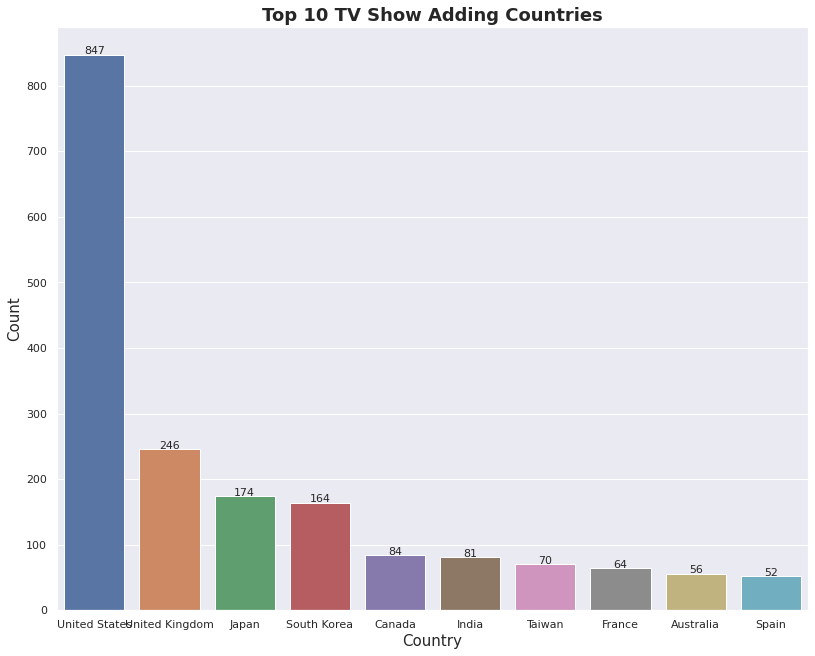

In [ ]:
tv_country_count = tv_country['first_country'].value_counts()
barplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
ax = sns.barplot(x=tv_country_count[:10].index, y=tv_country_count[:10])
ax.set_title('Top 10 TV Show Adding Countries',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,int(rect.get_height()),horizontalalignment='center', fontsize = 11)

TV Show의 경우 또한 미국이 가장 많은 컨텐츠를 가지고, \
전체데이터와 영화와는 다르게 영국 > 일본 > 한국 순으로 많은 컨텐츠를 가진다. 

### 연도별 Top 10의 변화

#### 컨텐츠 변화

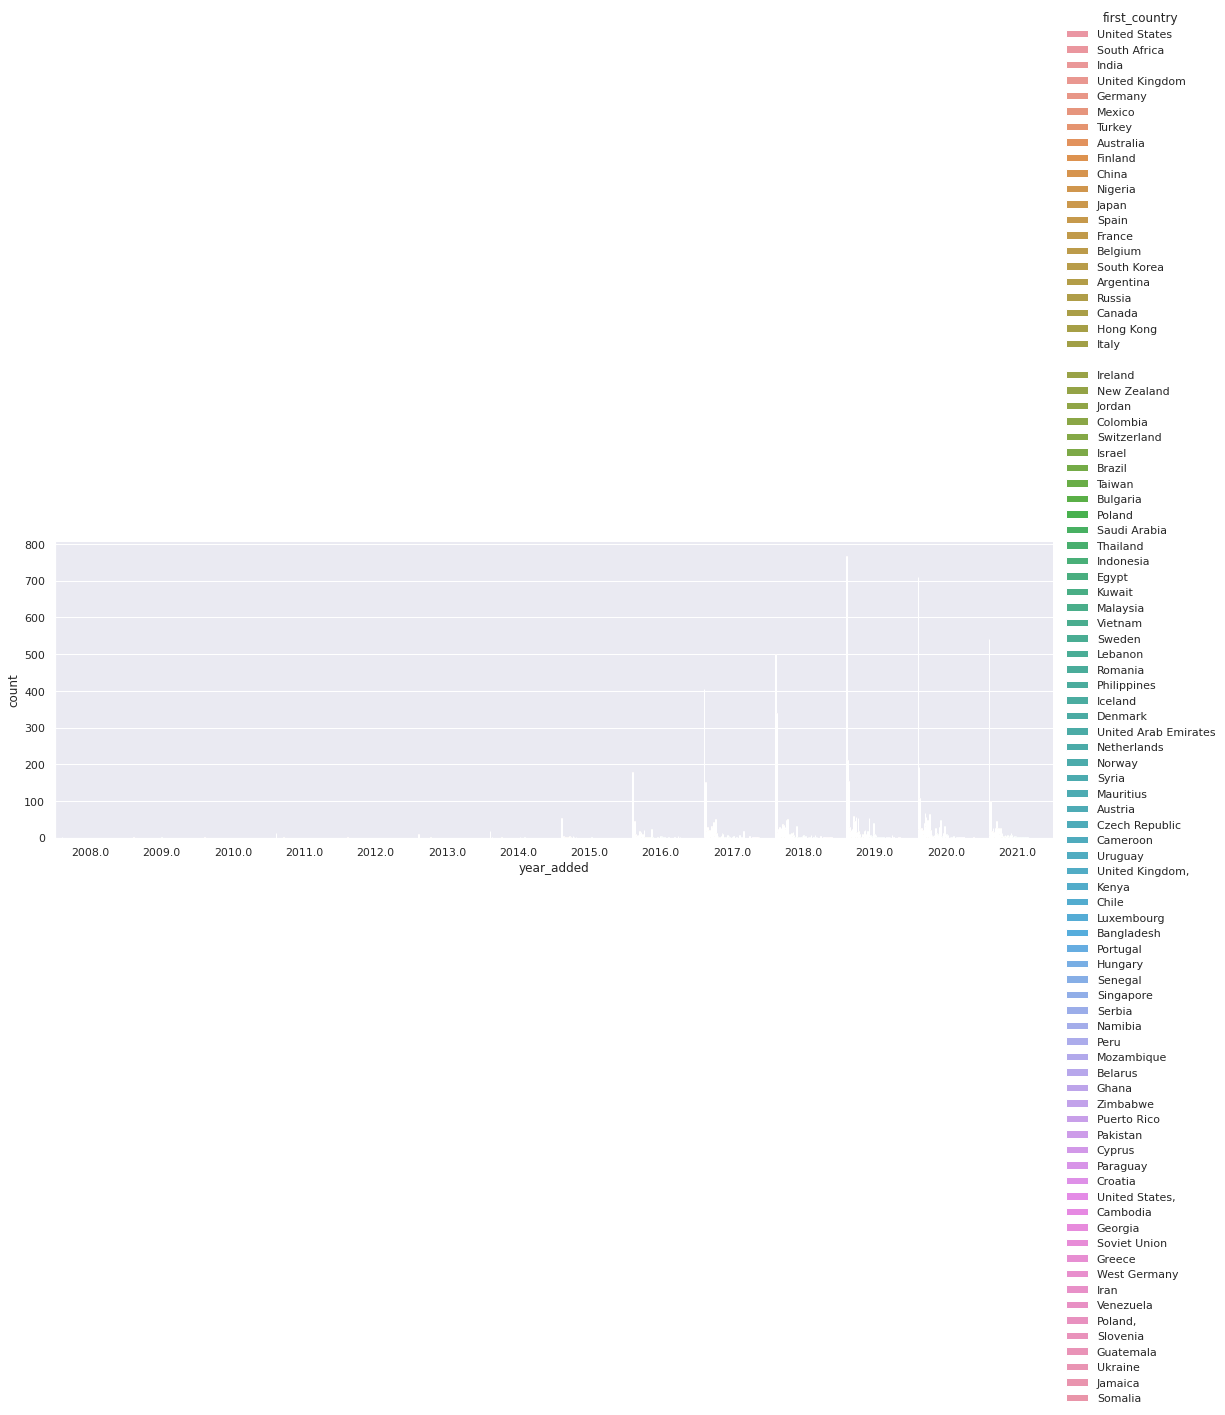

In [ ]:
count = countries['first_country'].value_counts()
sns.catplot( x='year_added',
             kind="count", 
             hue="first_country",
             height=5, 
             aspect=3, 
             data=countries)

In [ ]:
def plot_country_content_count_year(year, df, content):
    count = df[df['year_added']==year]['first_country'].value_counts()
    barplt, ax = plt.subplots(figsize=(12,10))
    sns.set_theme(style="darkgrid")
    ax = sns.barplot(x=count[:10].index, y=count[:10])
    ax.set_title(f'Top 10 {content} Adding Countries in {year}',fontsize = 18, fontweight='bold' )
    ax.set_xlabel('Country', fontsize = 15)
    ax.set_ylabel('Count', fontsize = 15)
    for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,int(rect.get_height()),horizontalalignment='center', fontsize = 11)

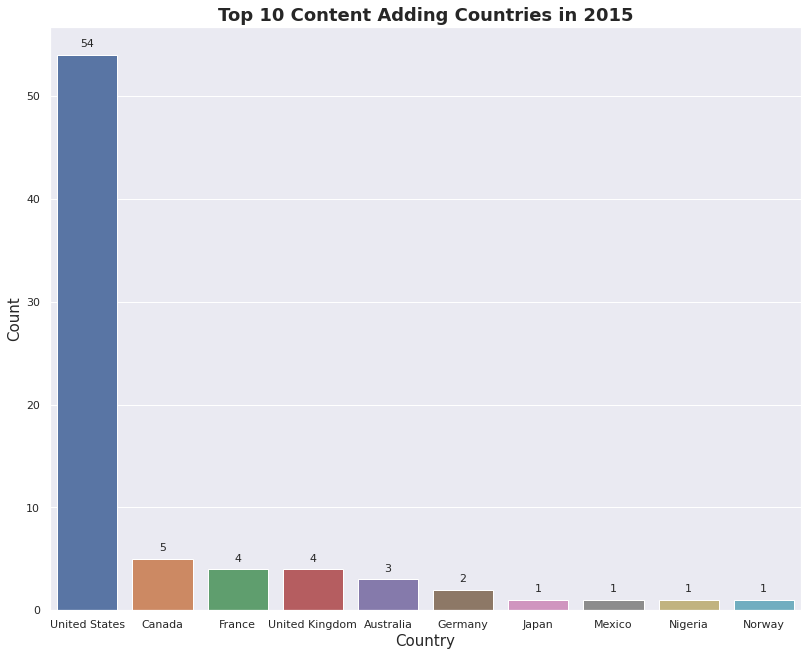

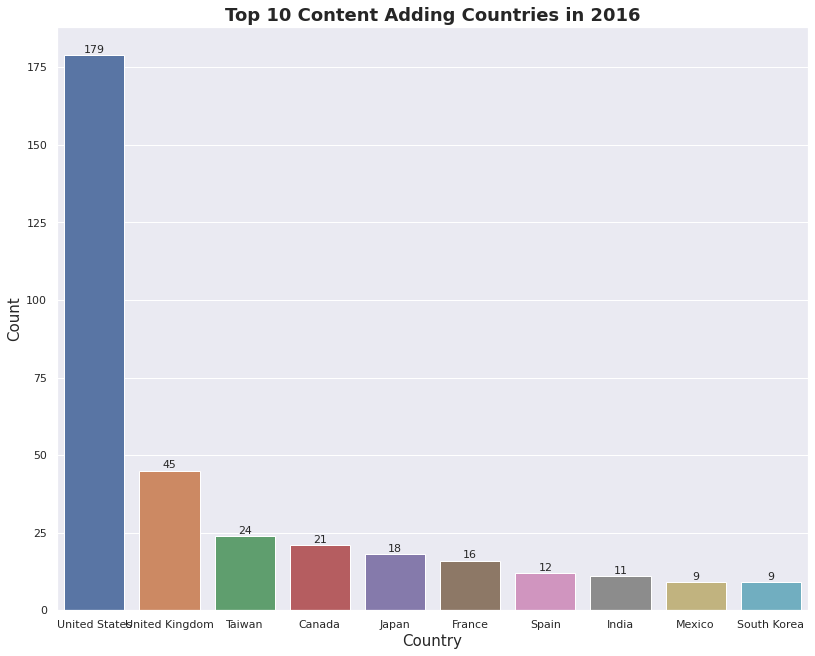

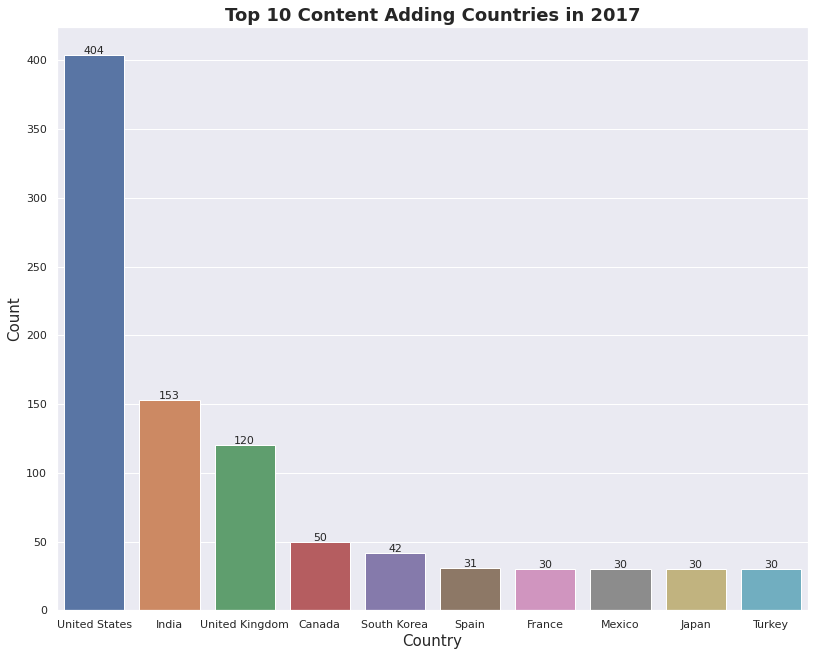

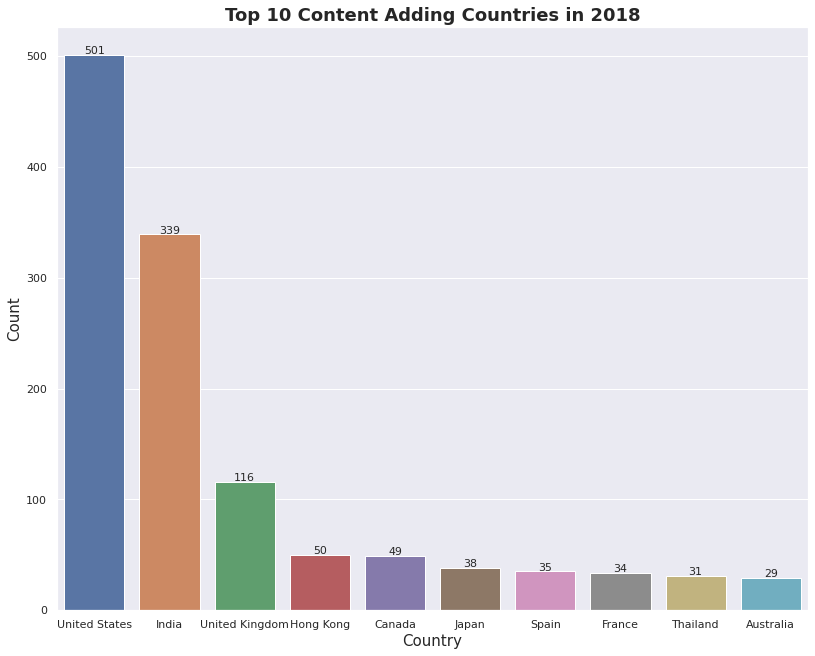

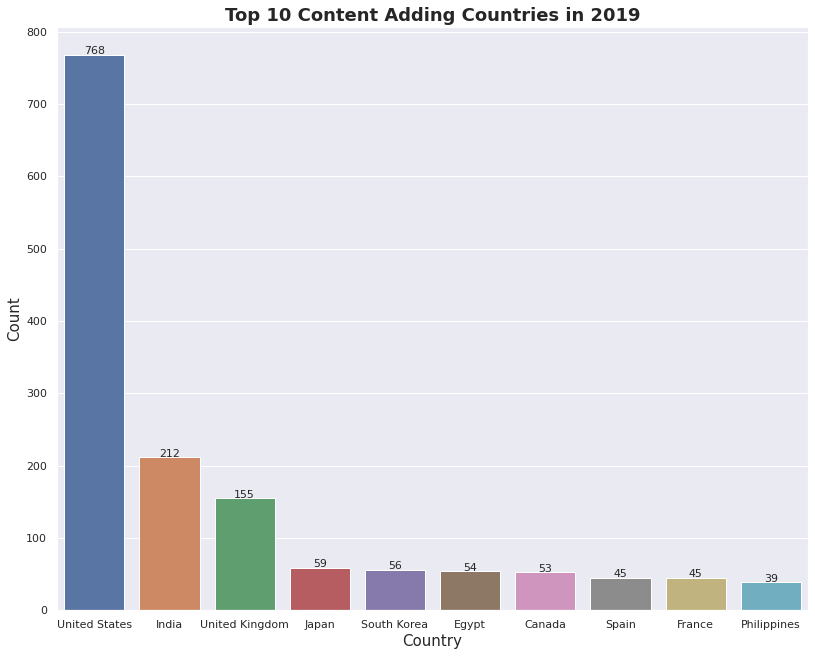

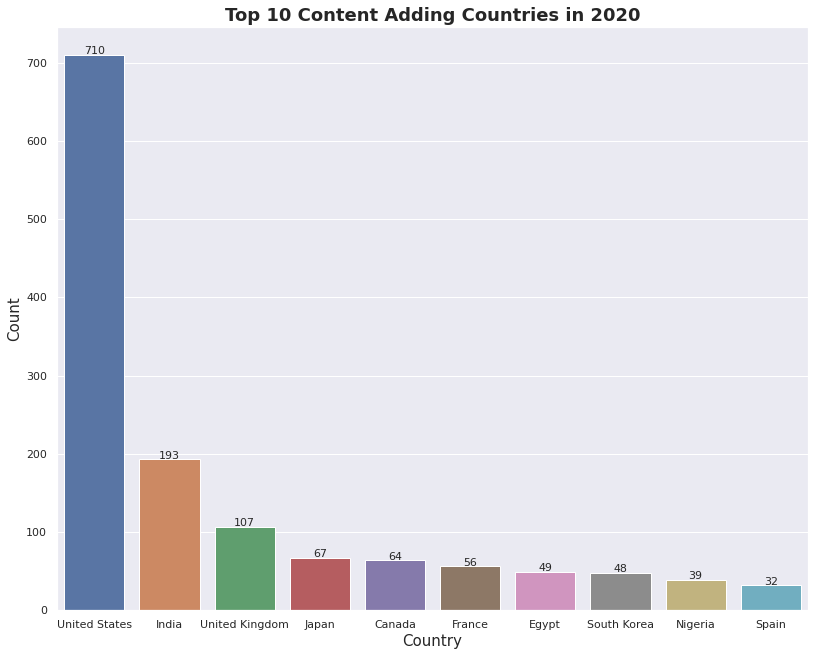

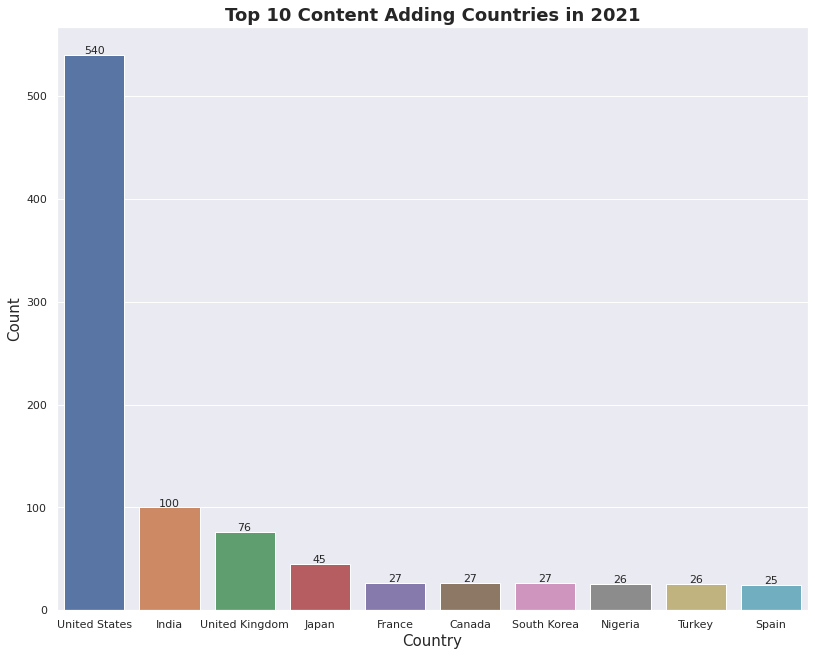

In [ ]:
for year in range(2015,2022):
  plot_country_content_count_year(year, countries, "Content")

이를 연도별(2015~2021)로 확인해보면, 미국은 계속 가장 많은 컨텐츠를 추가해왔고,  2017년부터 인도가 영국보다 많은 컨텐츠를 추가해오고 있다. (인도 서비스 시작: 2016년) \
또한 넷플릭스가 한국에서 서비스를 시작한 2016년부터 한국이 순위에 나타나고 있음을 볼 수 있다.

#### 영화 변화

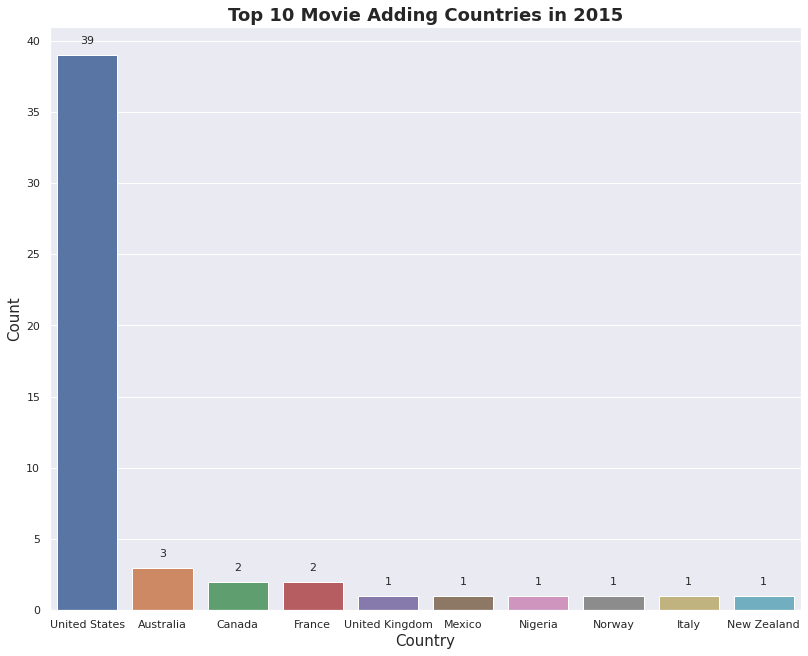

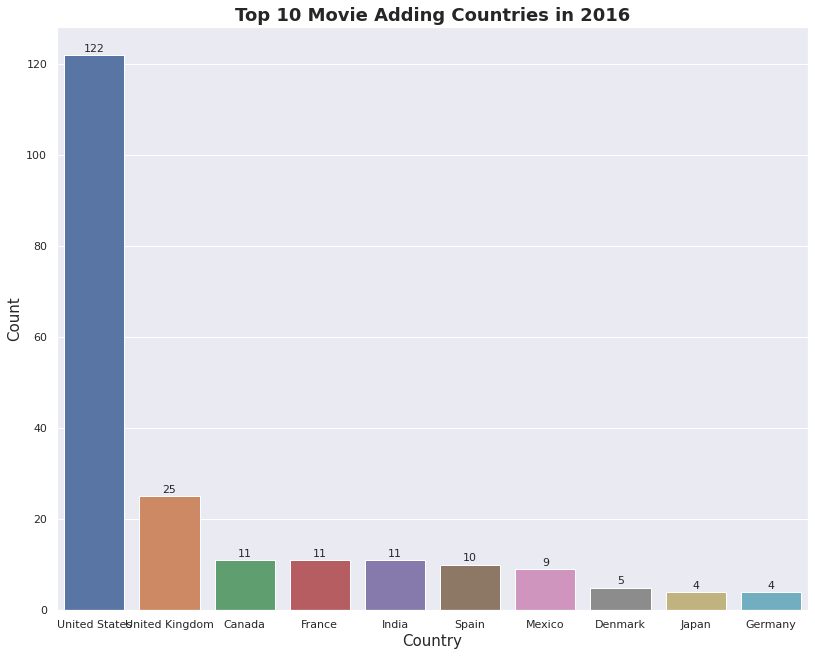

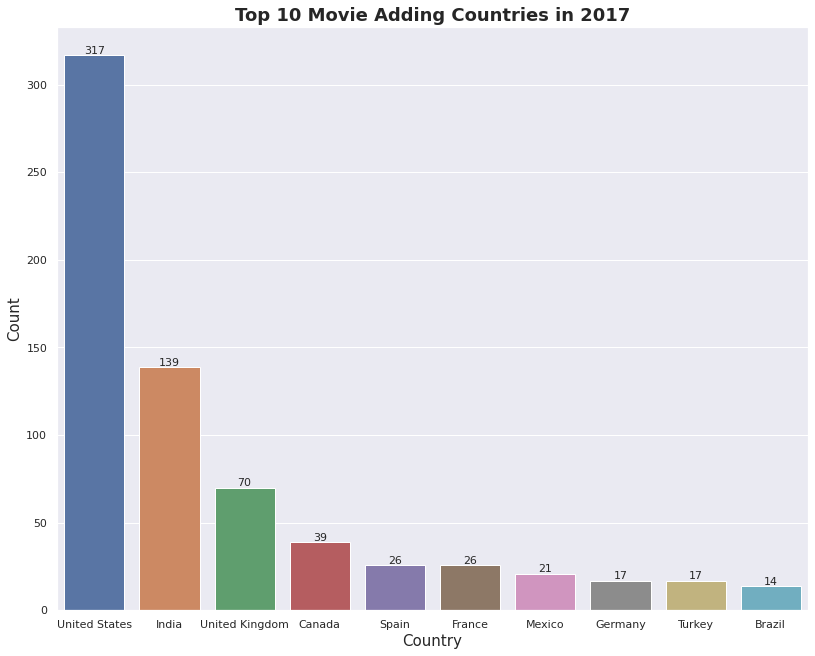

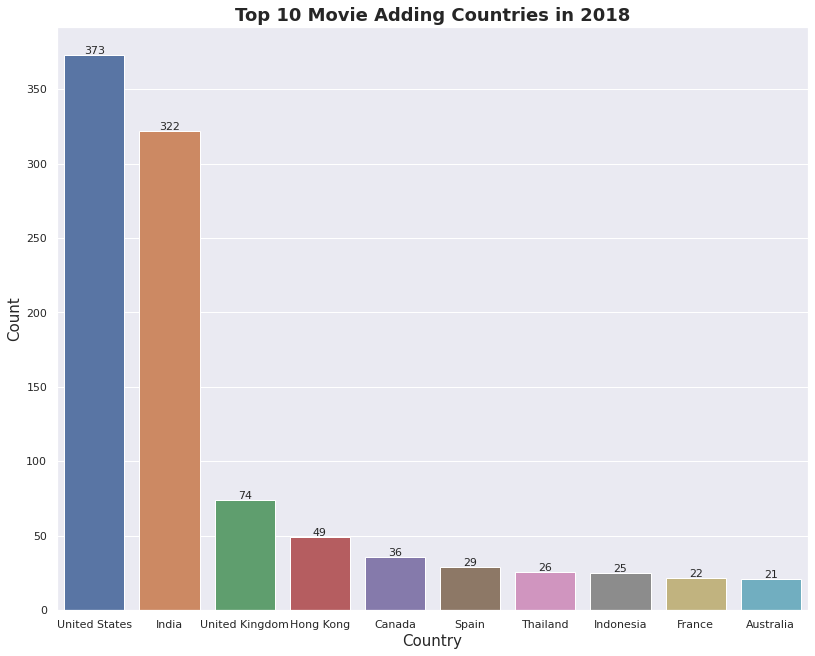

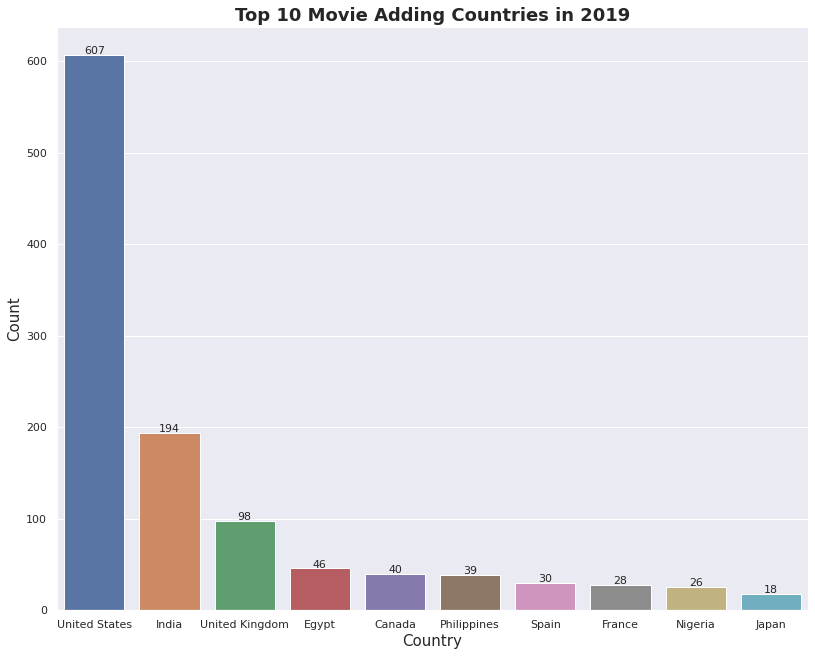

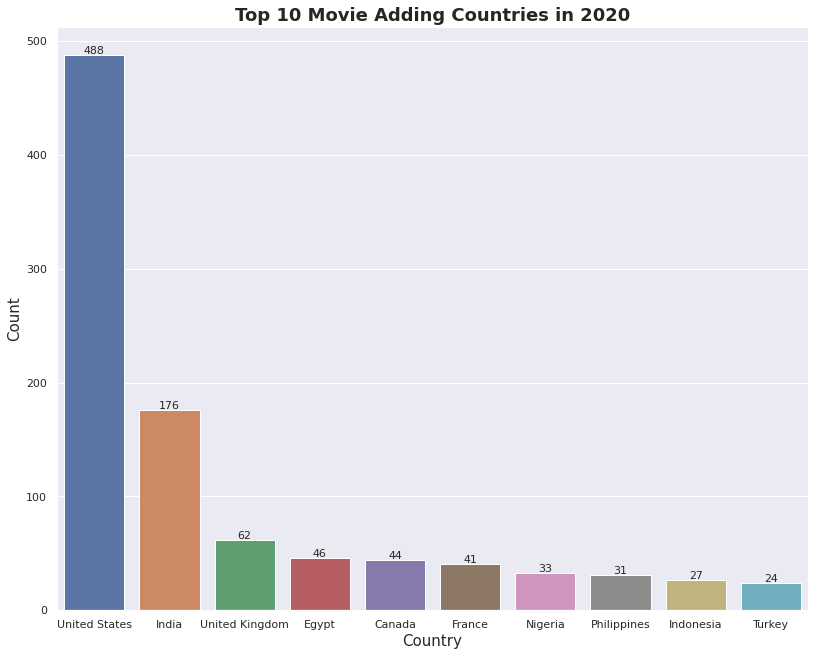

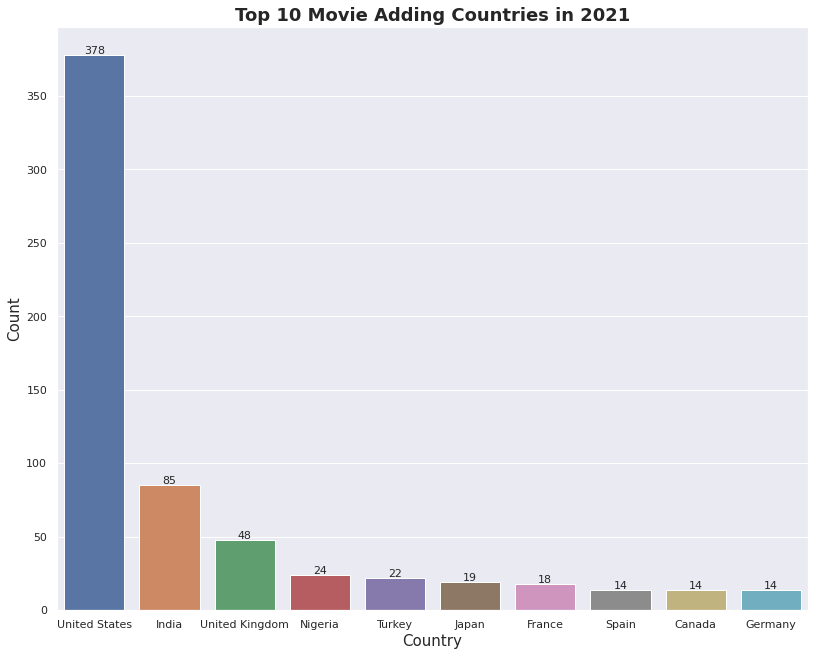

In [ ]:
for year in range(2015,2022):
  plot_country_content_count_year(year, movie_country, "Movie")

영화 데이터도 전체 데이터와 비슷한 양상을 보인다.(미국 > 인도)\
다만 영화의 경우, 순위에서 한국은 찾아볼 수 없다.

#### TV Shows 변화

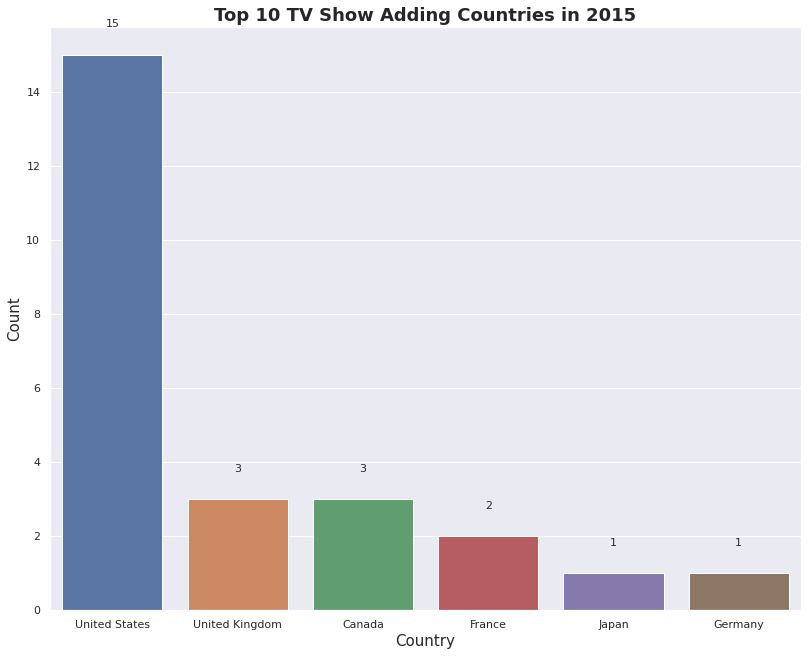

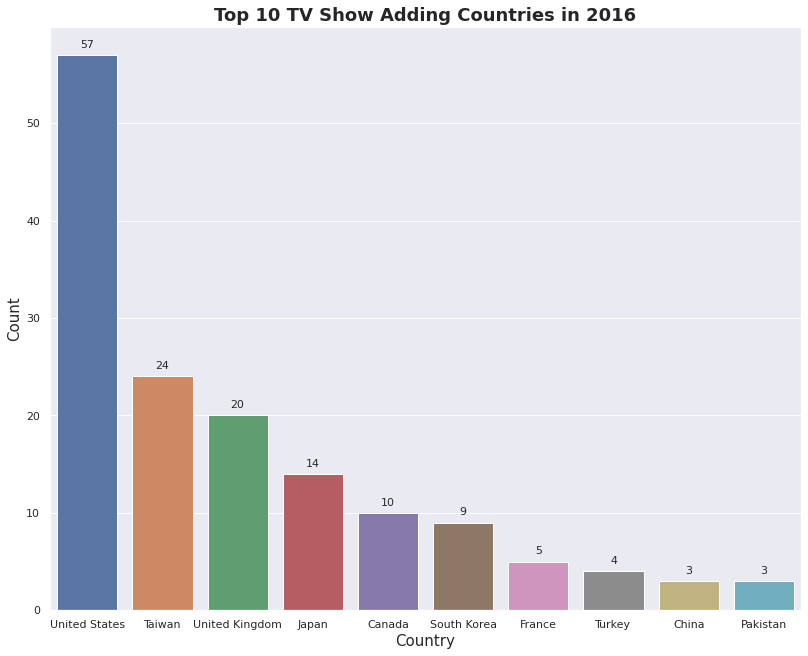

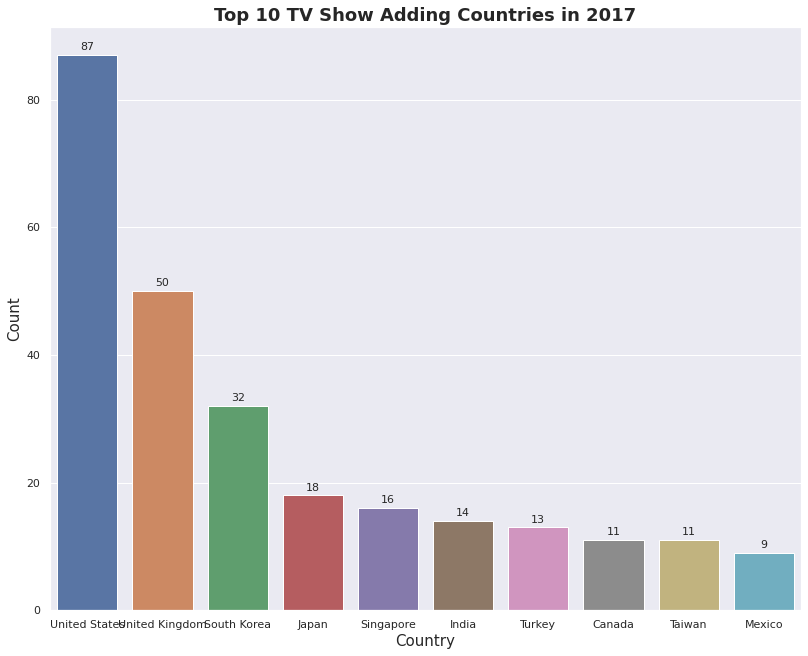

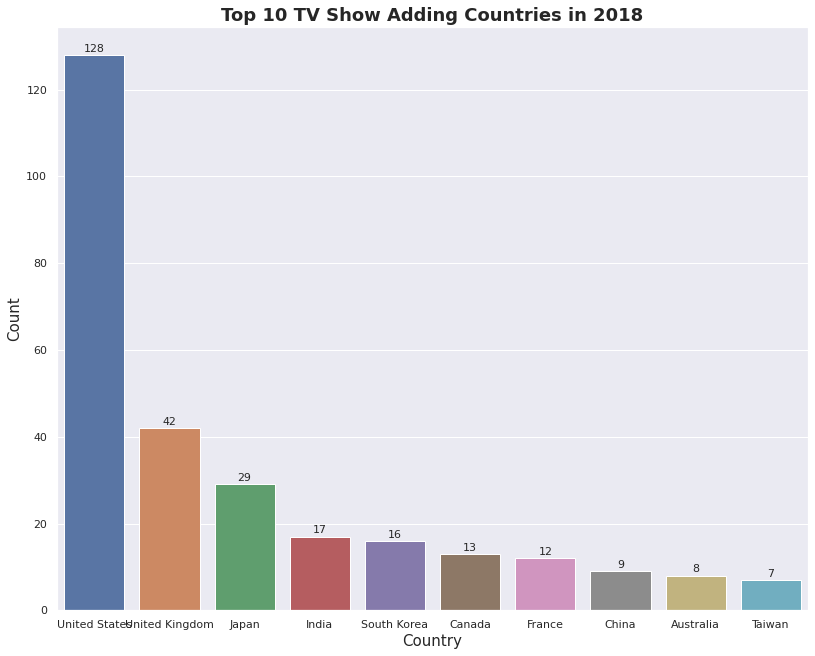

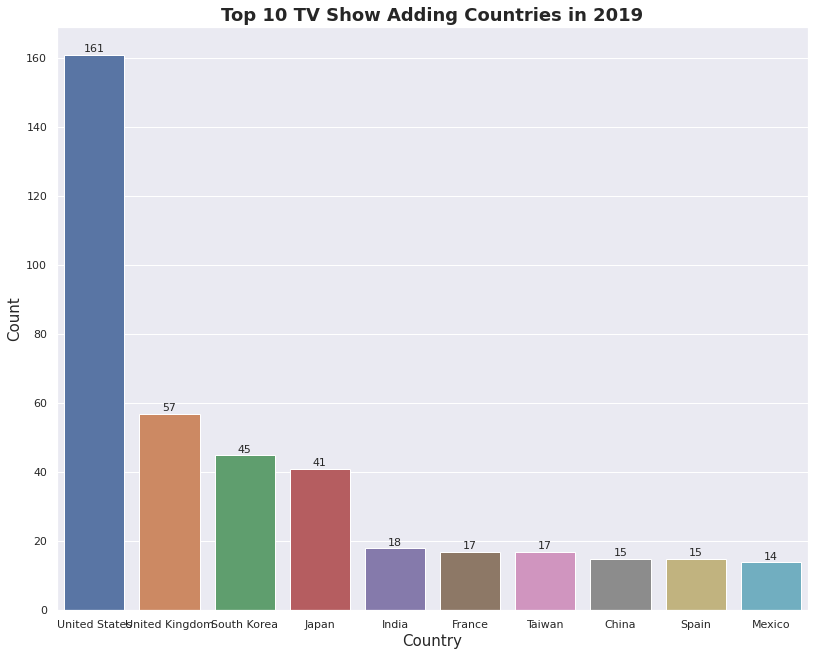

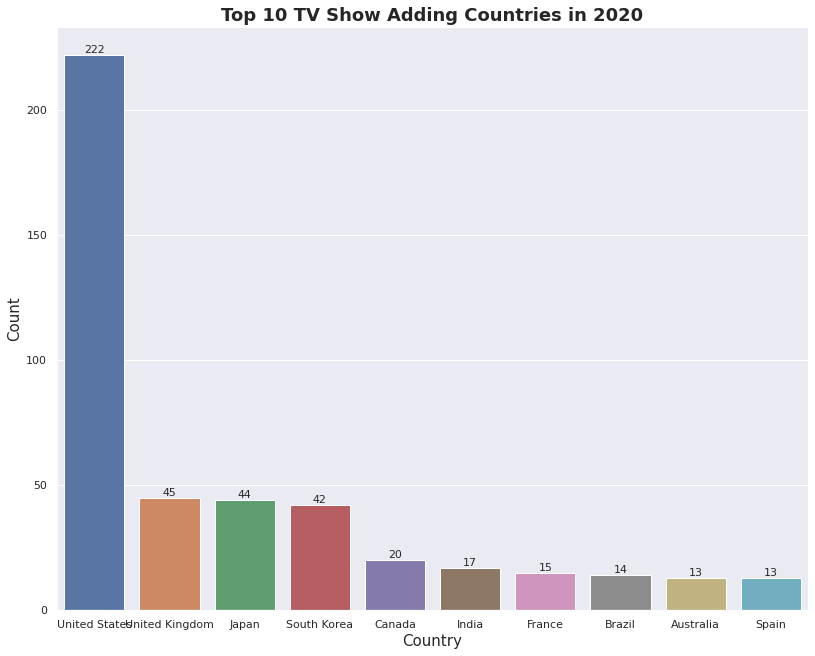

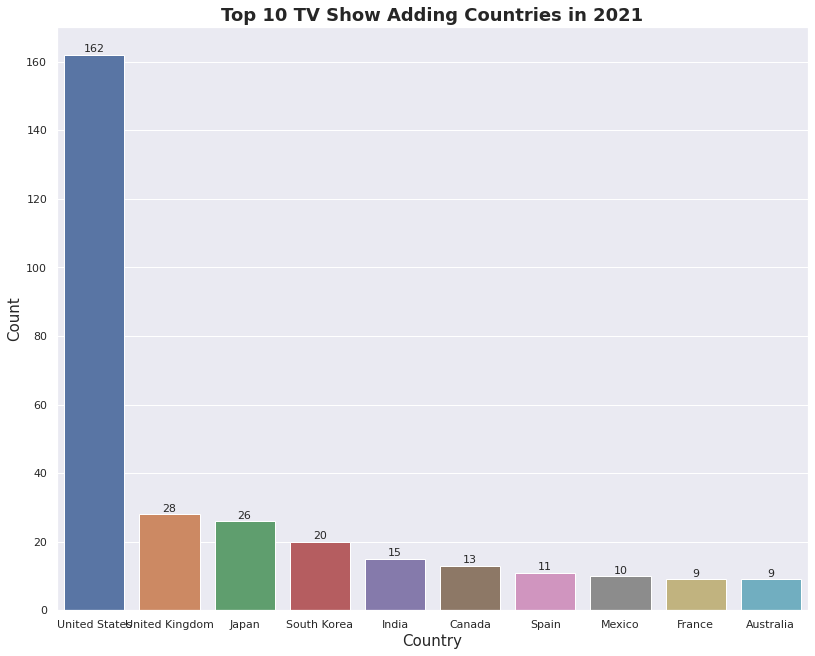

In [ ]:
for year in range(2015,2022):
  plot_country_content_count_year(year, tv_country, "TV Show")

tv show의 경우, 2015년에 6개의 나라밖에 나타나지 않는다.\
본격적으로 tv show를 추가하기 시작한게 2016년으로 보인다. \
영화 데이터와 달리, tv show에서는 미국 다음으로 영국이 많은 컨텐츠를 추가하고 있고, 한국과 일본이 그 다음을 잇는다.

## 국가별로 추가한 영화/드라마 비율이 어떻게 되고, 시간에 따라 어떻게 변하였는가?

### 국가별 컨텐츠 상대적 비율


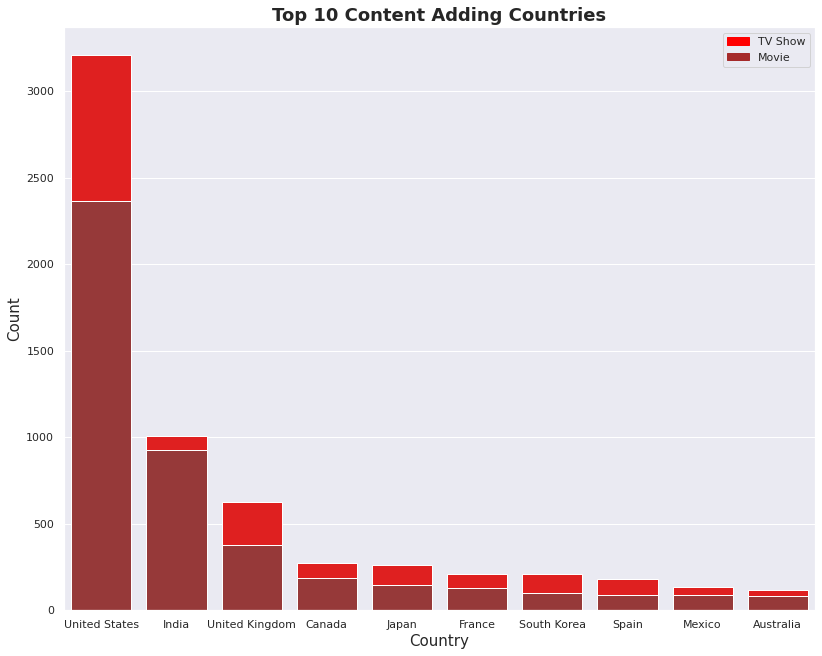

In [ ]:
count = countries['first_country'].value_counts()
movie_count = movie_country['first_country'].value_counts()
barplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
bar1 = sns.barplot(x=count[:10].index, y=count[:10], color='red')
bar2 = sns.barplot(x=count[:10].index, y=movie_count[:10], color='brown')
ax.set_title(f'Top 10 Content Adding Countries',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
top_bar = mpatches.Patch(color='red', label='TV Show')
bottom_bar = mpatches.Patch(color='brown', label='Movie')
plt.legend(handles=[top_bar, bottom_bar])

위 그래프를 보면 미국과 인도의 경우 영화 비율이 tv show 비율보다 높은 것을 알 수 있다.

### 국가별 영화/드라마 절대적 비율

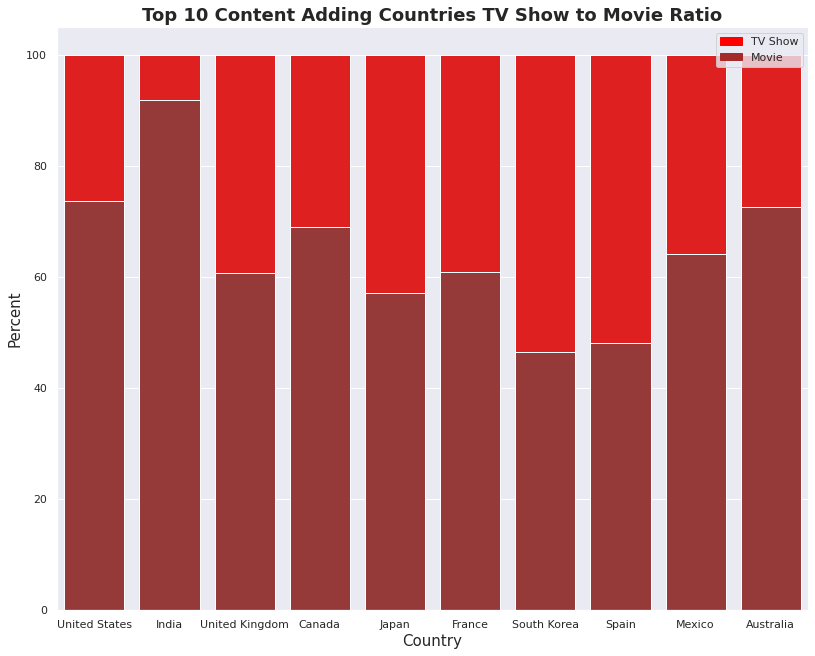

In [ ]:
total = countries['first_country'].value_counts()
movie_count = movie_country['first_country'].value_counts()
movie_percent = [i / j * 100 for i,j in zip(movie_count, total)]
total_percent = [i / j * 100 for i,j in zip(total, total)]

barplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
bar1 = sns.barplot(x=total[:10].index, y=total_percent[:10], color='red')
bar2 = sns.barplot(x=total[:10].index, y=movie_percent[:10], color='brown')
ax.set_title(f'Top 10 Content Adding Countries TV Show to Movie Ratio',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Percent', fontsize = 15)


# add legend
top_bar = mpatches.Patch(color='red', label='TV Show')
bottom_bar = mpatches.Patch(color='brown', label='Movie')
plt.legend(handles=[top_bar, bottom_bar])

### 연도별 국가의 영화/드라마 비율 변화

In [ ]:
def plot_proportion_year(country):
  total_count = countries[countries['first_country']==country]['year_added'].dropna().astype('uint64').value_counts()
  movie_count = movie_country[movie_country['first_country']==country]['year_added'].astype('uint64').value_counts()

  # 영화가 만들어지지 않은 해를 Index에 추가 (값은 0으로)
  for year in total_count.index:
    if year not in movie_count:
      movie_count[year]=0

  movie_percent = [i / j * 100 for i,j in zip(movie_count, total_count)]
  total_percent = [i / j * 100 for i,j in zip(total_count, total_count)]

  barplt, ax = plt.subplots(figsize=(12,10))
  sns.set_theme(style="darkgrid")
  bar1 = sns.barplot(x=total_count.index, y=total_percent, color='red')
  bar2 = sns.barplot(x=total_count.index, y=movie_percent, color='brown')
  ax.set_title(f'Movie/TV Show Ratio of {country} by Year',fontsize = 18, fontweight='bold' )
  ax.set_xlabel('Year', fontsize = 15)
  ax.set_ylabel('Percent', fontsize = 15)

  top_bar = mpatches.Patch(color='red', label='TV Show')
  bottom_bar = mpatches.Patch(color='brown', label='Movie')
  plt.legend(handles=[top_bar, bottom_bar])

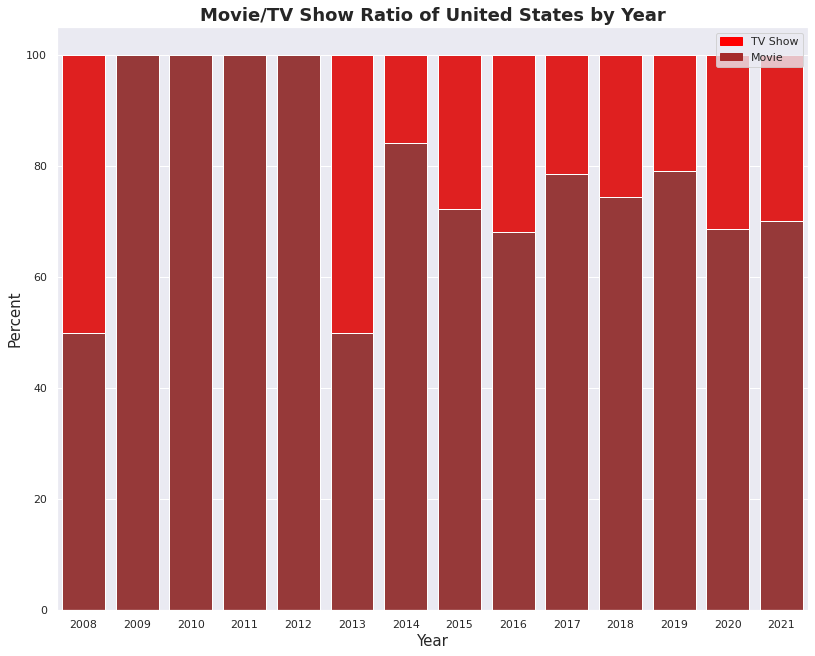

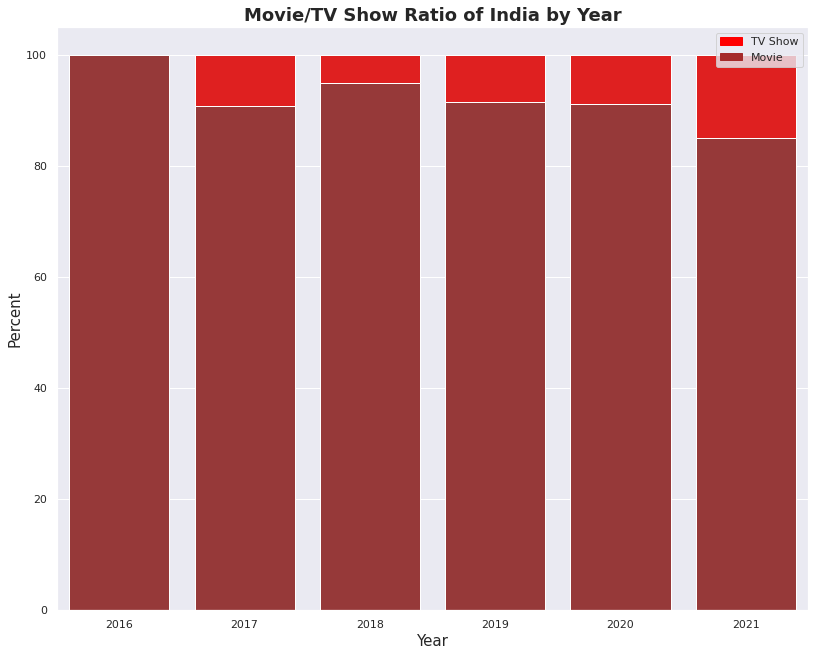

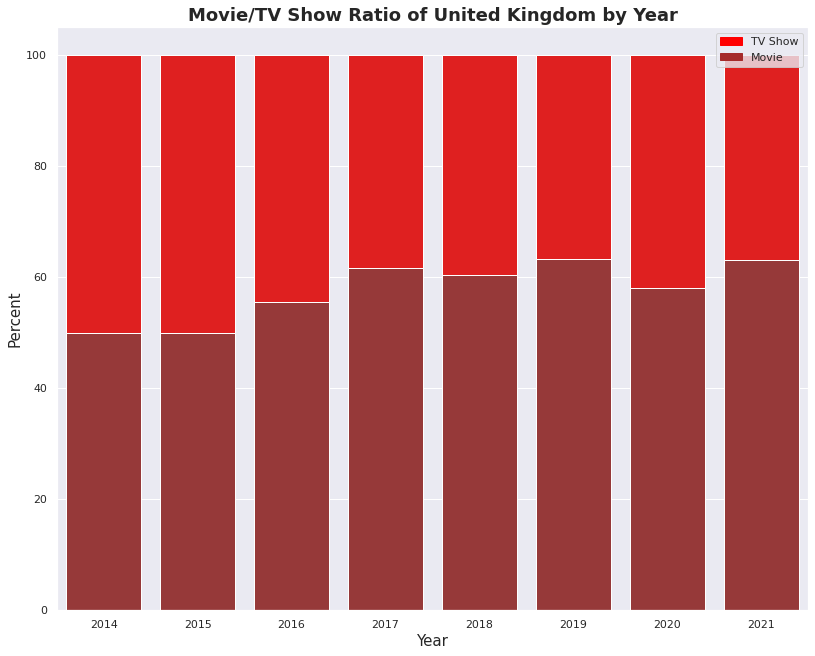

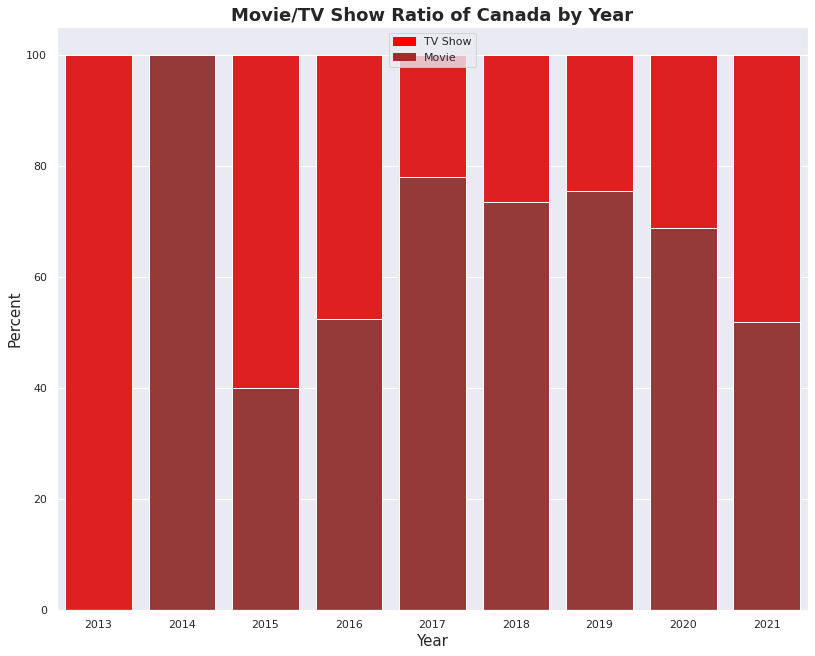

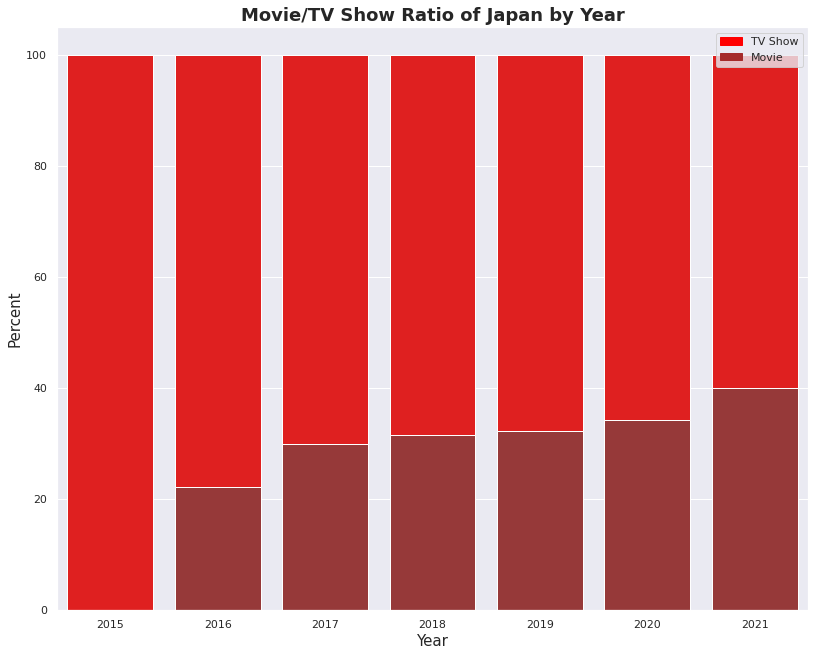

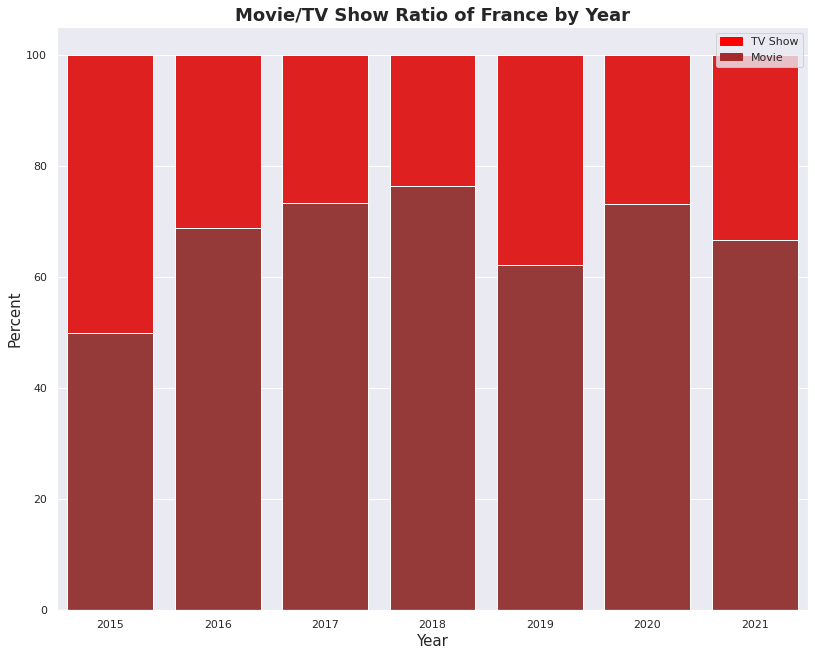

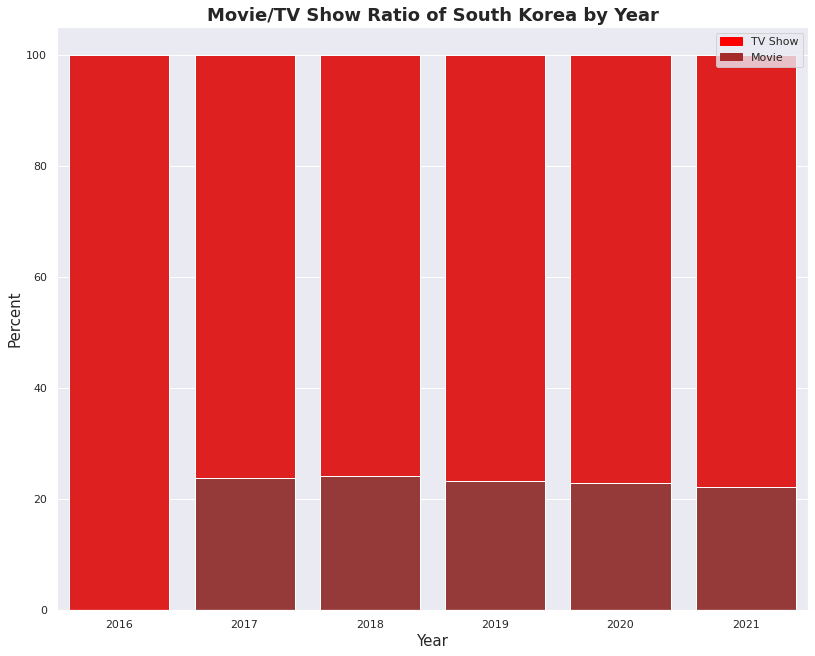

In [ ]:
for country in country_count[:7].index:
  plot_proportion_year(country)


- 미국의 경우 꾸준히 영화 비율이 높았다. 2009, 2010, 2011, 2012 년에는 영화만 추가했음을 알 수 있다. 
- 인도도 마찬가지로 영화의 비율이 꾸준히 높다.
- 영국은 초반에는 영화와 tv show의 비율이 비슷했지만 점점 영화가 많이 추가되는 것을 알 수 있다.
- 일본과 한국은 서비스 시작부터 계속 tv show의 비율이 높게 나타난다.

## 연도별 자주 나오는 장르는 무엇인가?

### 전체 데이터/ 영화 데이터/ TV Show 데이터에서의 장르 순위

#### 전체 데이터 장르 Top 20

In [ ]:
genr = data.iloc[:, 14:].sum()
genr = genr[genr > 0]
genr_dict = genr.to_dict()
genr_dict

{'Action & Adventure': 859,
 'Anime Features': 71,
 'Anime Series': 176,
 'British TV Shows': 253,
 'Children & Family Movies': 641,
 'Classic & Cult TV': 28,
 'Classic Movies': 116,
 'Comedies': 1674,
 'Crime TV Shows': 470,
 'Cult Movies': 71,
 'Documentaries': 869,
 'Docuseries': 395,
 'Dramas': 2427,
 'Faith & Spirituality': 65,
 'Horror Movies': 357,
 'Independent Movies': 756,
 'International Movies': 2752,
 'International TV Shows': 1351,
 "Kids' TV": 451,
 'Korean TV Shows': 151,
 'LGBTQ Movies': 102,
 'Movies': 57,
 'Music & Musicals': 375,
 'Reality TV': 255,
 'Romantic Movies': 616,
 'Romantic TV Shows': 370,
 'Sci-Fi & Fantasy': 243,
 'Science & Nature TV': 92,
 'Spanish-Language TV Shows': 174,
 'Sports Movies': 219,
 'Stand-Up Comedy': 343,
 'Stand-Up Comedy & Talk Shows': 56,
 'TV Action & Adventure': 168,
 'TV Comedies': 581,
 'TV Dramas': 763,
 'TV Horror': 75,
 'TV Mysteries': 98,
 'TV Sci-Fi & Fantasy': 84,
 'TV Shows': 16,
 'TV Thrillers': 57,
 'Teen TV Shows': 69,


In [ ]:
# 빈도수 상위 20개의 장르를 출력
sorted_genr_count = sorted(genr_dict, key = genr_dict.get, reverse=True)

for key in sorted_genr_count[:20]:  
    print(f'{repr(key)}:{genr_dict[key]}', end = ', ')

'International Movies':2752, 'Dramas':2427, 'Comedies':1674, 'International TV Shows':1351, 'Documentaries':869, 'Action & Adventure':859, 'TV Dramas':763, 'Independent Movies':756, 'Children & Family Movies':641, 'Romantic Movies':616, 'TV Comedies':581, 'Thrillers':577, 'Crime TV Shows':470, "Kids' TV":451, 'Docuseries':395, 'Music & Musicals':375, 'Romantic TV Shows':370, 'Horror Movies':357, 'Stand-Up Comedy':343, 'Reality TV':255, 

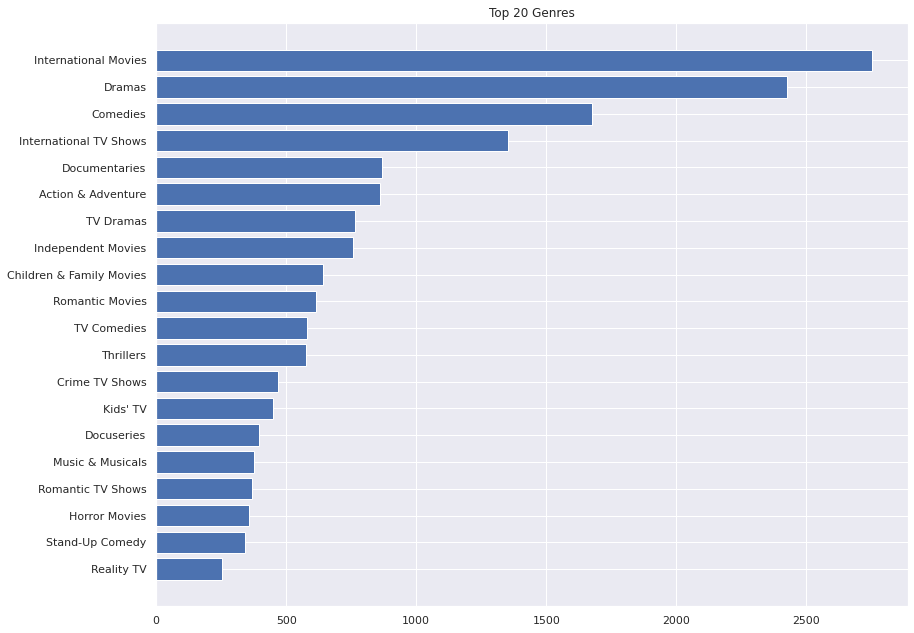

In [ ]:
# 시각화
n = sorted_genr_count[:20][::-1]
w = [genr_dict[key] for key in n]
plt.subplots(figsize=(12,10))
plt.barh(n, w)
plt.title('Top 20 Genres')
plt.show()

#### 영화 데이터 장르 top 10

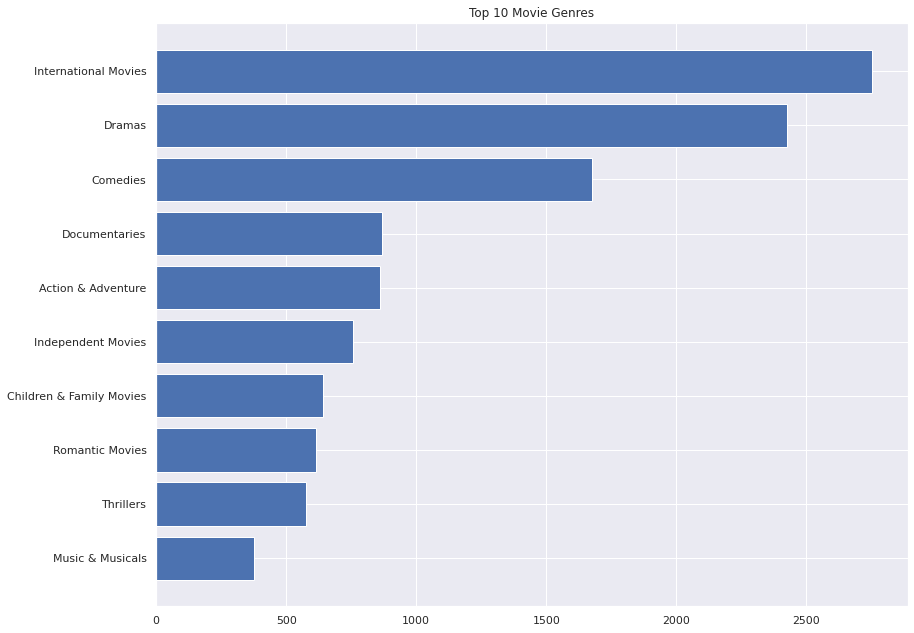

In [ ]:
# 영화데이터 장르 순위
movie_genr_dict = movie_labels.to_dict()

sorted_movie_genr = sorted(movie_genr_dict, key = movie_genr_dict.get, reverse=True)

# 시각화
n = sorted_movie_genr[:10][::-1]
w = [movie_genr_dict[key] for key in n]
plt.subplots(figsize=(12,10))
plt.barh(n, w)
plt.title('Top 10 Movie Genres')
plt.show()

#### TV Show 데이터 장르 Top 10

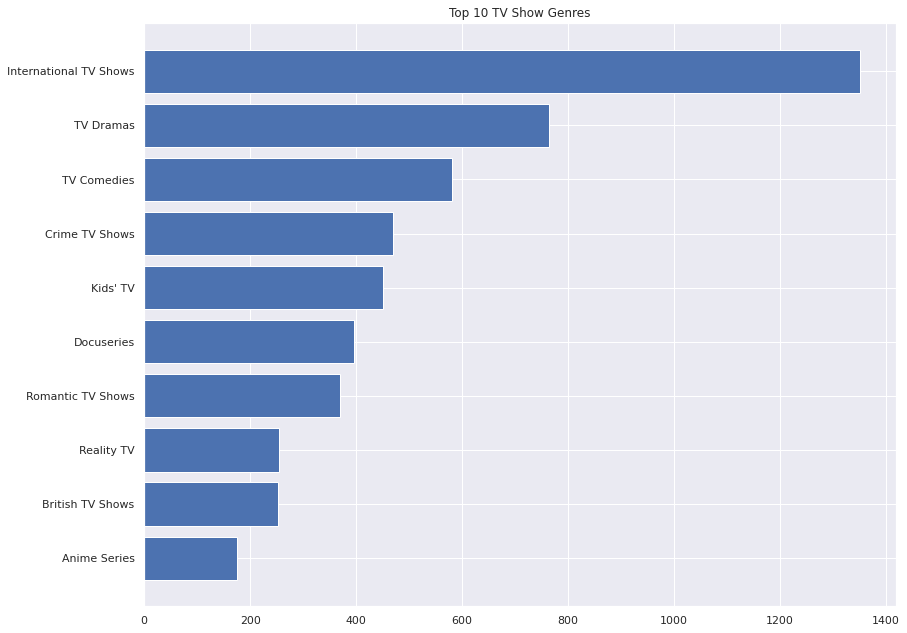

In [ ]:
# tv show 장르 순위
tv_genr_dict = tv_labels.to_dict()

sorted_tv_genr = sorted(tv_genr_dict, key = tv_genr_dict.get, reverse=True)

# 시각화
n = sorted_tv_genr[:10][::-1]
w = [tv_genr_dict[key] for key in n]
plt.subplots(figsize=(12,10))
plt.barh(n, w)
plt.title('Top 10 TV Show Genres')
plt.show()

### 시간에 따른 장르 순위

#### 연도별 영화 및 tv 장르 순위 (release year & added year)

##### release_year 기준 : Movies

In [ ]:
movie_palette = {genre:color for genre, color in zip(movie_genres, sns.color_palette('husl', n_colors=len(movie_genres)))}

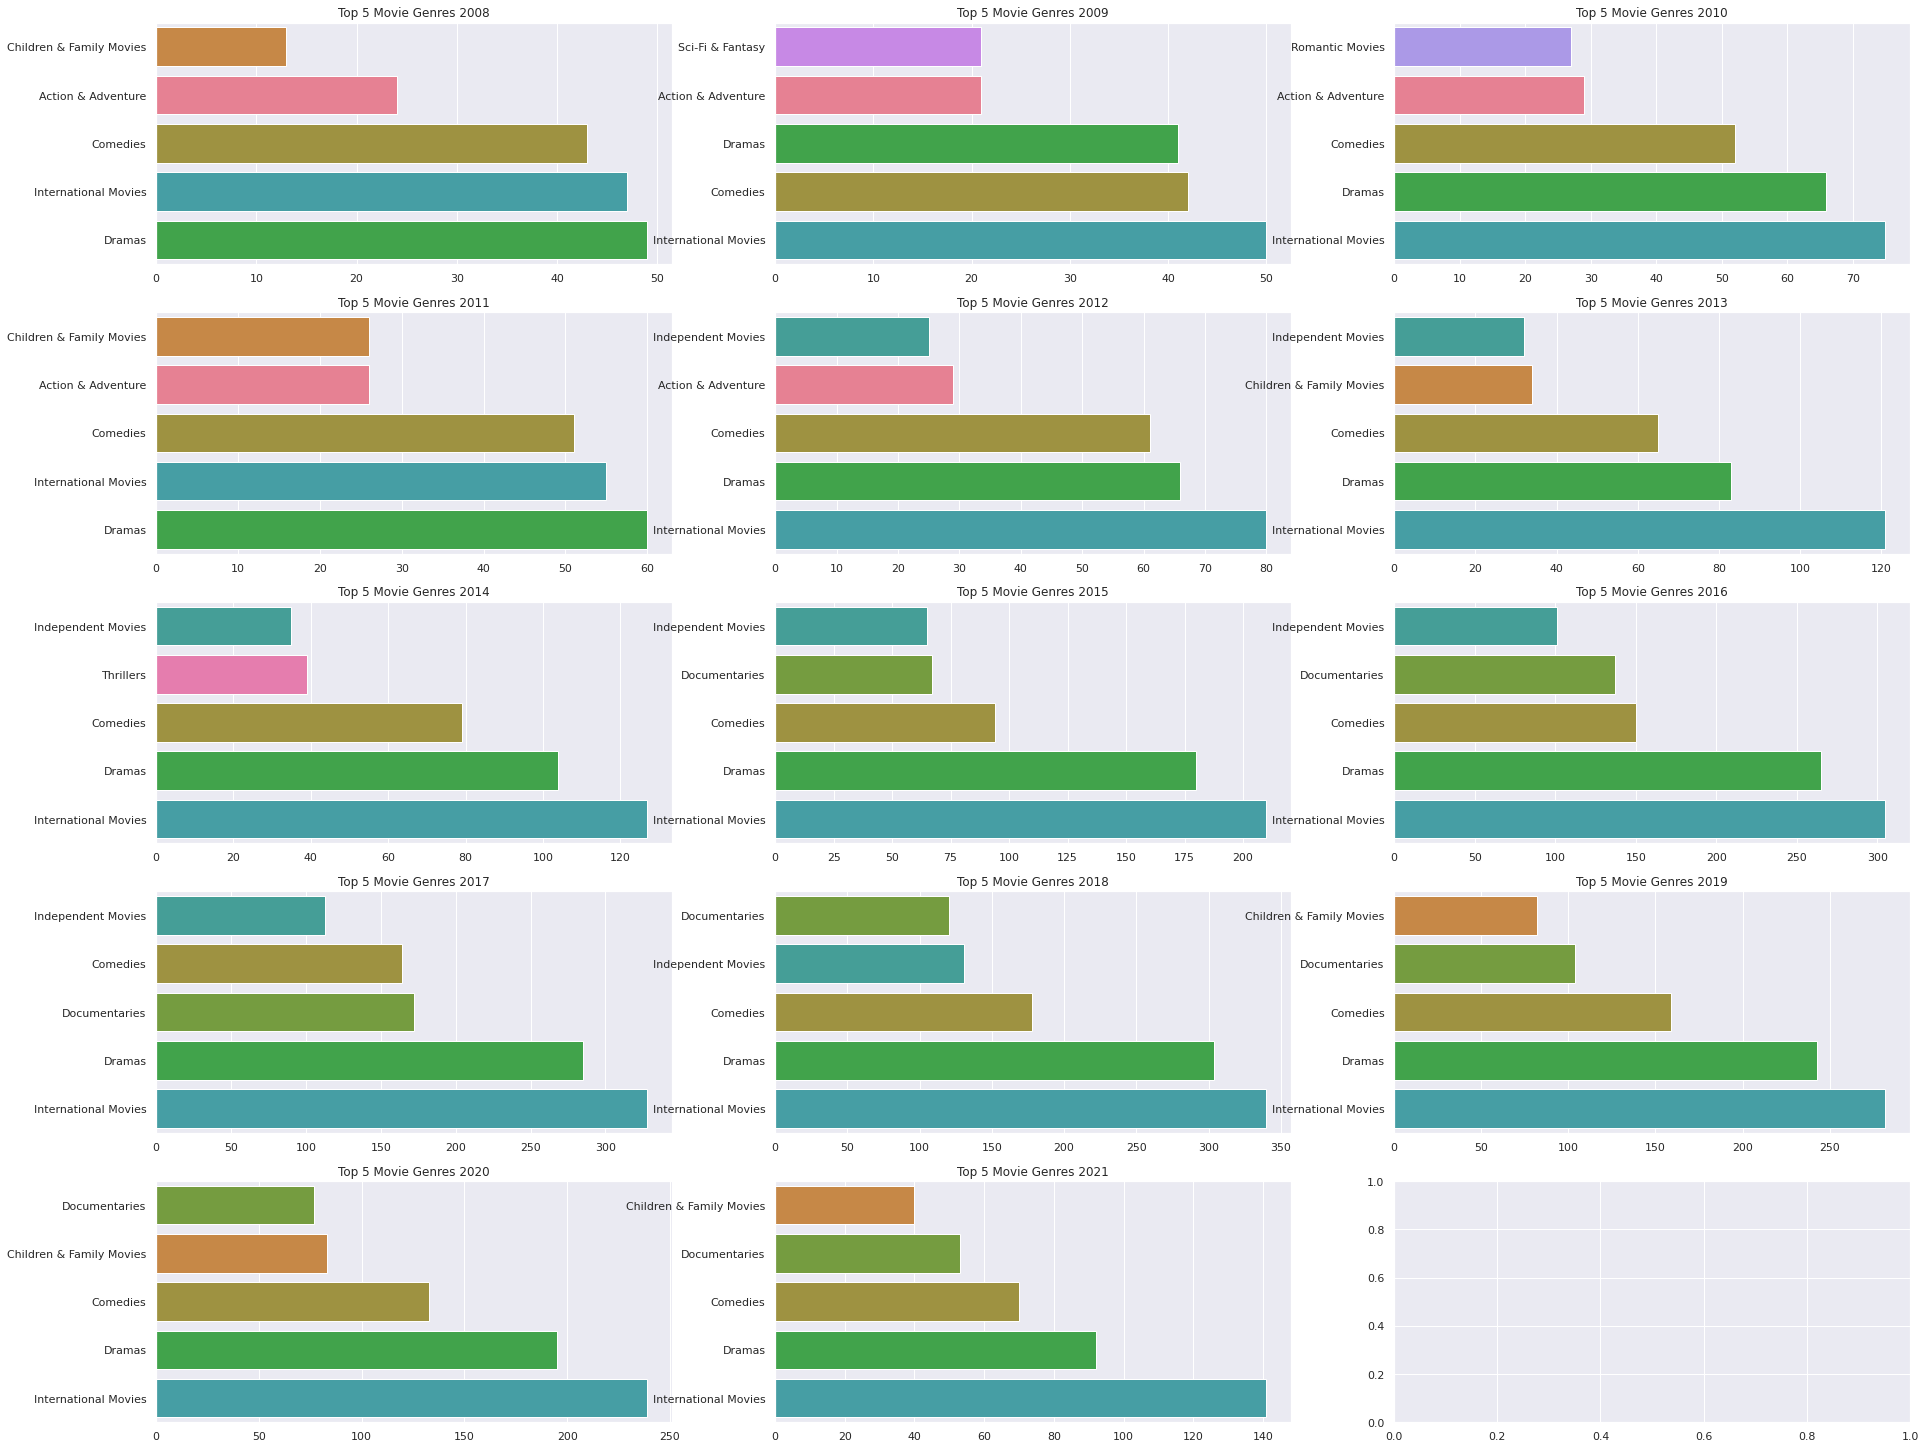

In [ ]:
# release_year 기준 : Movies
i = 0
fig, ax = plt.subplots(5, 3, figsize=(28, 24))

for year in range(2008, 2022):
    example = data[(data['release_year']==year)&(data['type']=='Movie')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_year_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_year_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(5, 3, i)
    sns.barplot(y=n, x=w, palette=movie_palette)
    plt.title('Top 5 Movie Genres {}'.format(year))
    
plt.show()

위 그래프는 영화의 개봉일을 기준으로 top 5 장르를 시각화한 것이다. \
2008년과 2011년을 제외하고 가장 많이 나타난 장르는 International Movies이고, 그 다음은 Dramas > Comedies 이다. \
Action & Adventure 는 2013년 이후로 순위에 보이지 않고, 2015년부터 Documentaries 가 나타나기 시작했다. \
Independent Movies는 2019년 부터 Children & Family Movies와 순위가 바뀌었다. 

>*International Movies 라는 용어는 일반적으로 미국 이외의 지역에서 주요 할리우드 스튜디오의 지원 없이 제작된 모든 영화를 지칭합니다.*

##### release_year 기준 : tv show

In [ ]:
tv_palette = {genre:color for genre, color in zip(tv_genres, sns.color_palette('husl', n_colors=len(tv_genres)))}

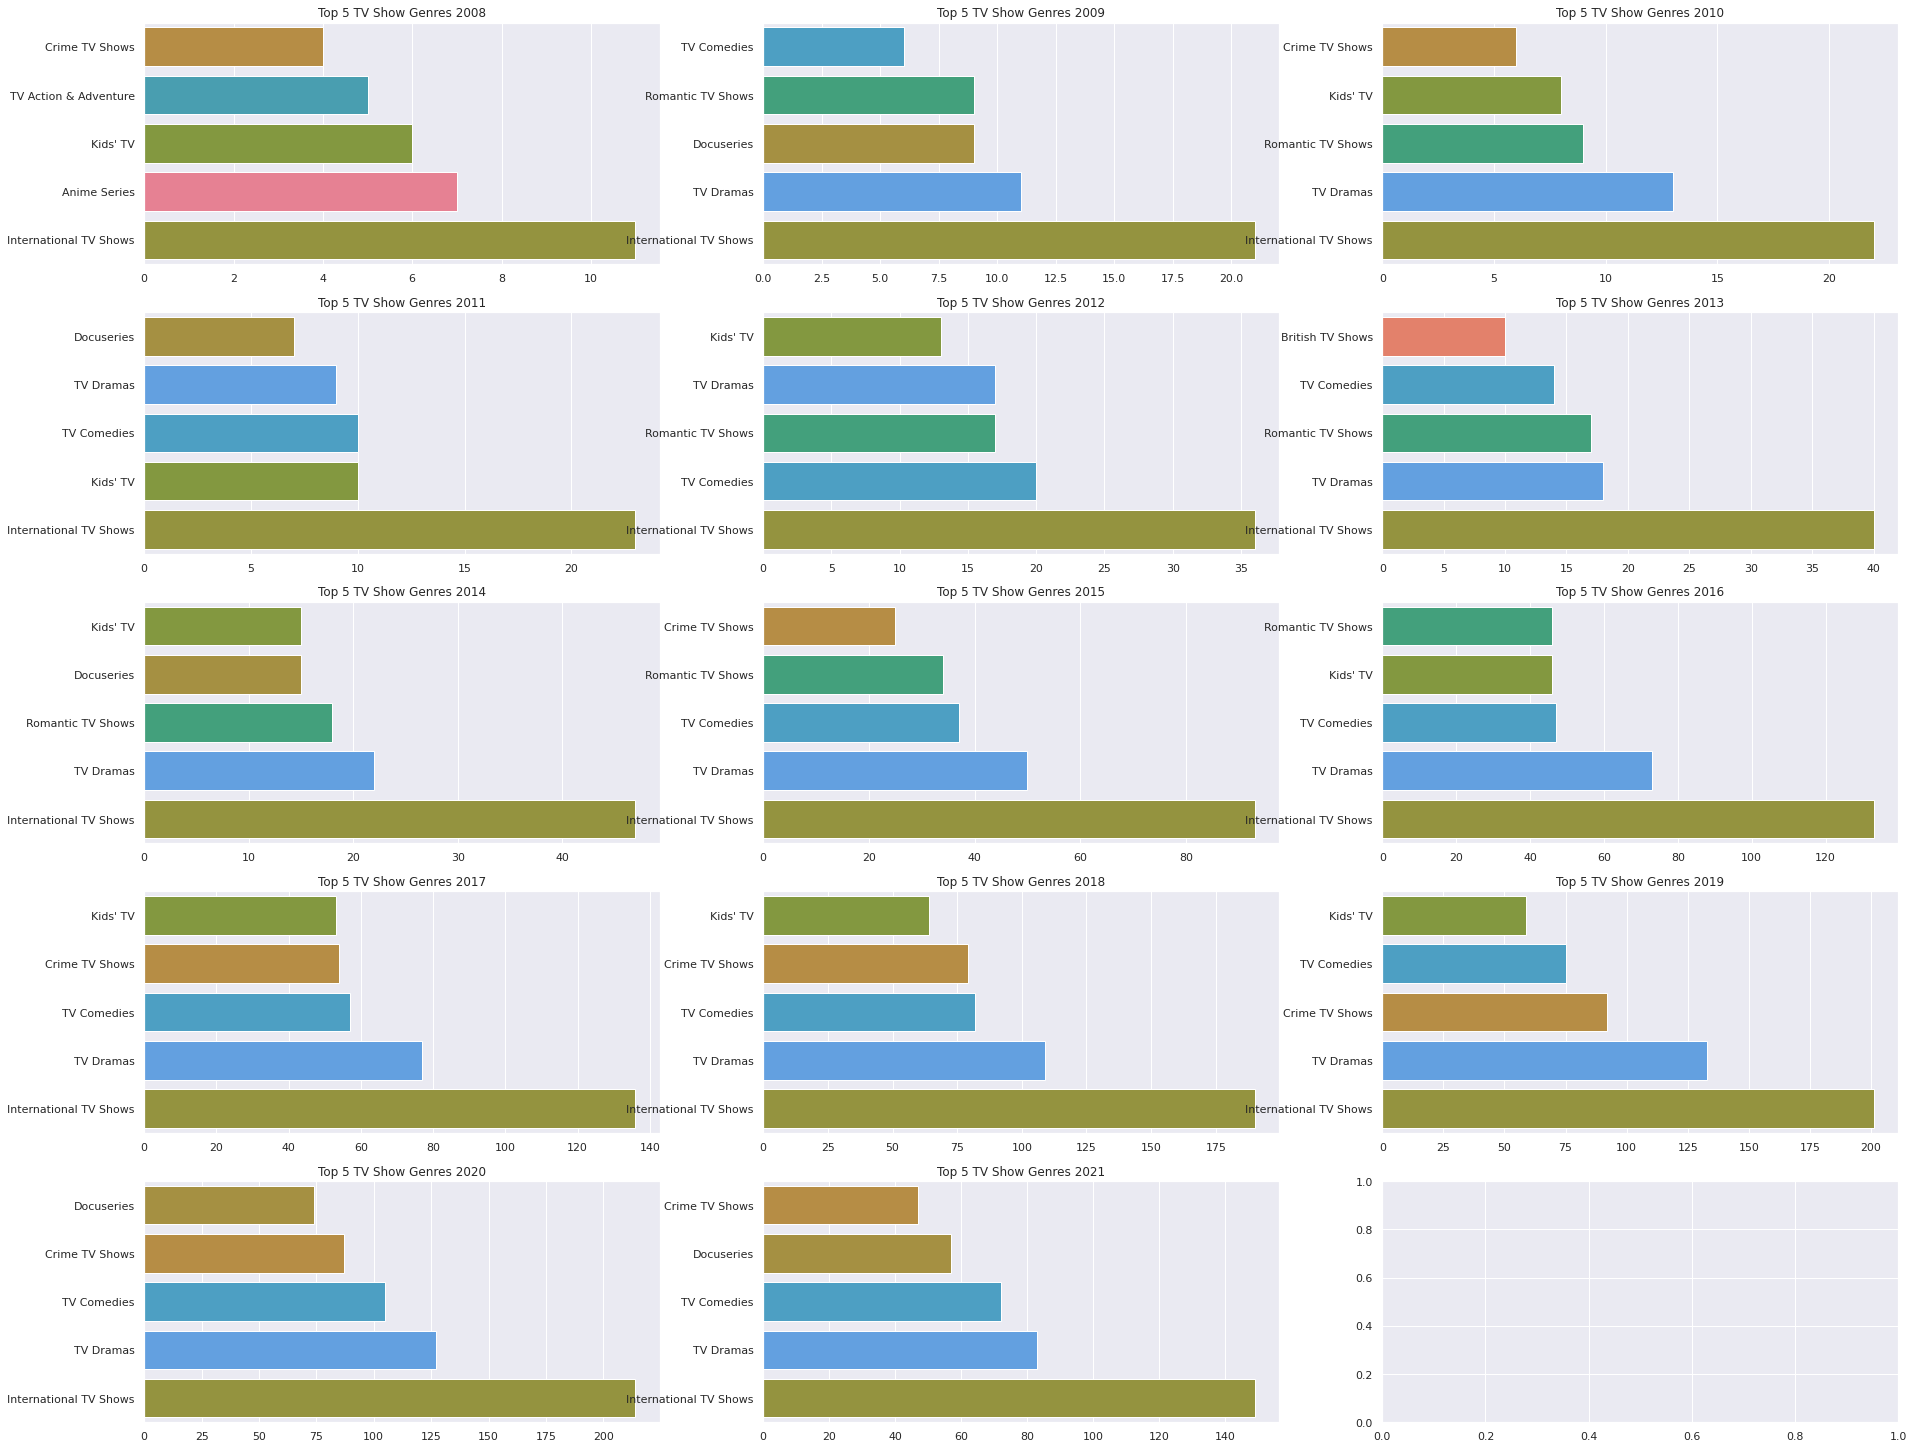

In [ ]:
# release_year 기준 : tv show
i = 0
fig, ax = plt.subplots(5, 3, figsize=(28, 24))

for year in range(2008, 2022):
    example = data[(data['release_year']==year)&(data['type']=='TV Show')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_year_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_year_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(5, 3, i)
    sns.barplot(y=n, x=w, palette=tv_palette)
    plt.title('Top 5 TV Show Genres {}'.format(year))
    
plt.show()

tv show의 경우, International TV Shows가 계속해서 가장 많이 나타나는 장르이다.\
최근에는 주로 드라마가 자주 나타나고 있고, 코미디나 다큐, 범죄 관련 프로가 많이 나타나는 추세이다.

##### added_year 기준 : Movies

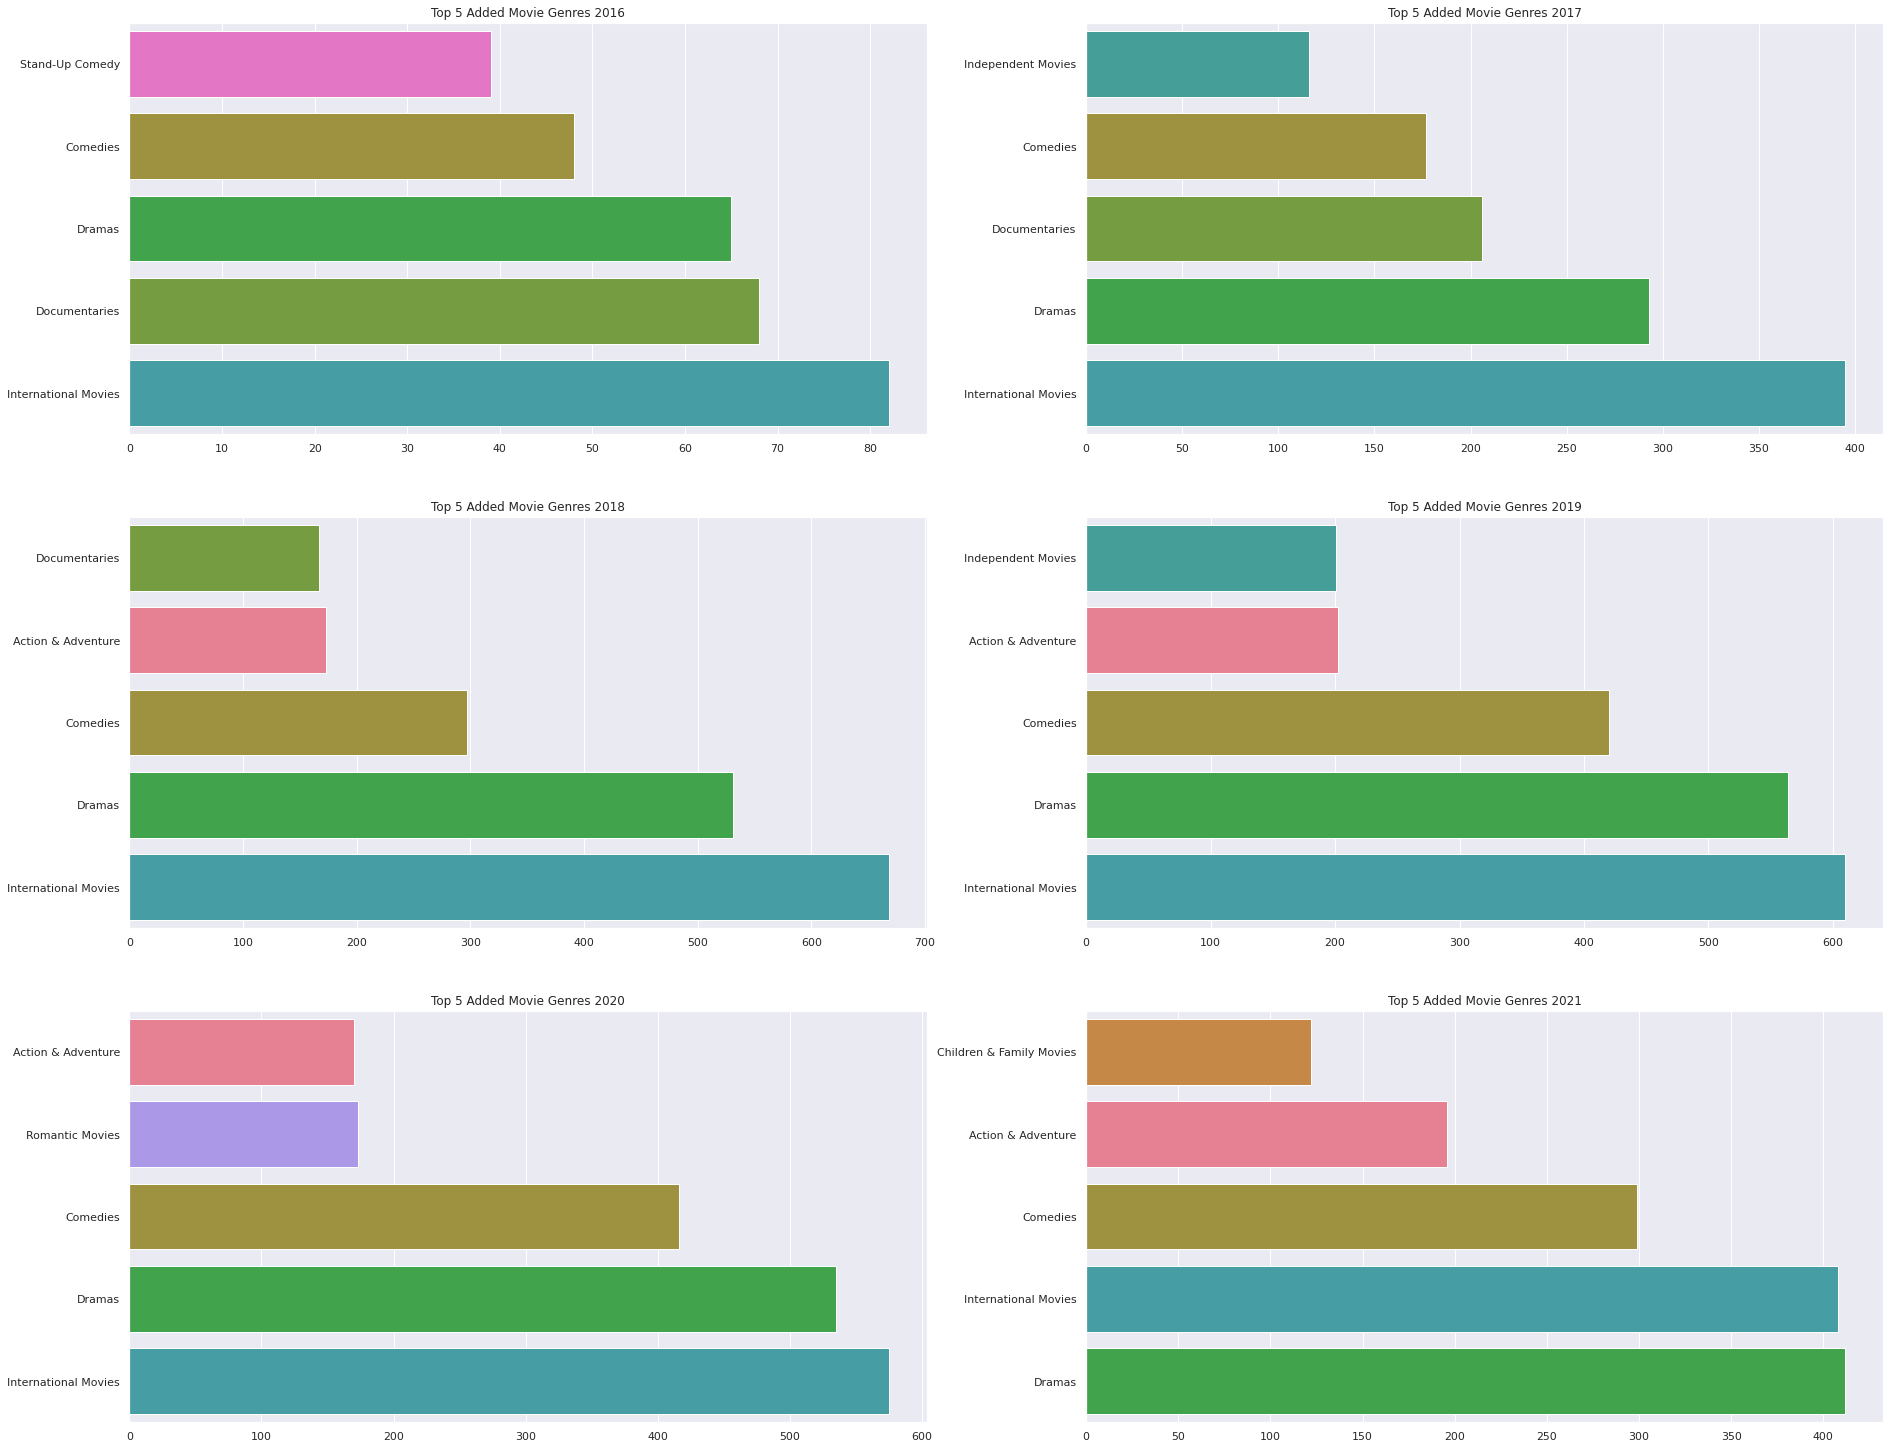

In [ ]:
# added_year 기준 : Movies
i = 0
fig, ax = plt.subplots(3, 2, figsize=(28, 24))

for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    example = data[(data['year_added']==year)&(data['type']=='Movie')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_year_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_year_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(3, 2, i)
    sns.barplot(y=n, x=w, palette=movie_palette)
    plt.title('Top 5 Added Movie Genres {}'.format(year))
    
plt.show()

위 그래프는 넷플릭스에 **컨텐츠가 추가된 연도**를 기준으로 top 5 장르를 나타낸 것이다.\
2020년까지는 International Movies가 가장 많이 추가 되었는데, 2021년에는 Dramas가 많이 추가된 것을 볼 수 있다. \
Comedies와 Action & Adventure 도 꾸준히 순위에 등장하고 있으며, 2021년에는 Children & Family Movies가 많이 추가된 것을 알 수 있다. 

##### added_year 기준 : TV Show

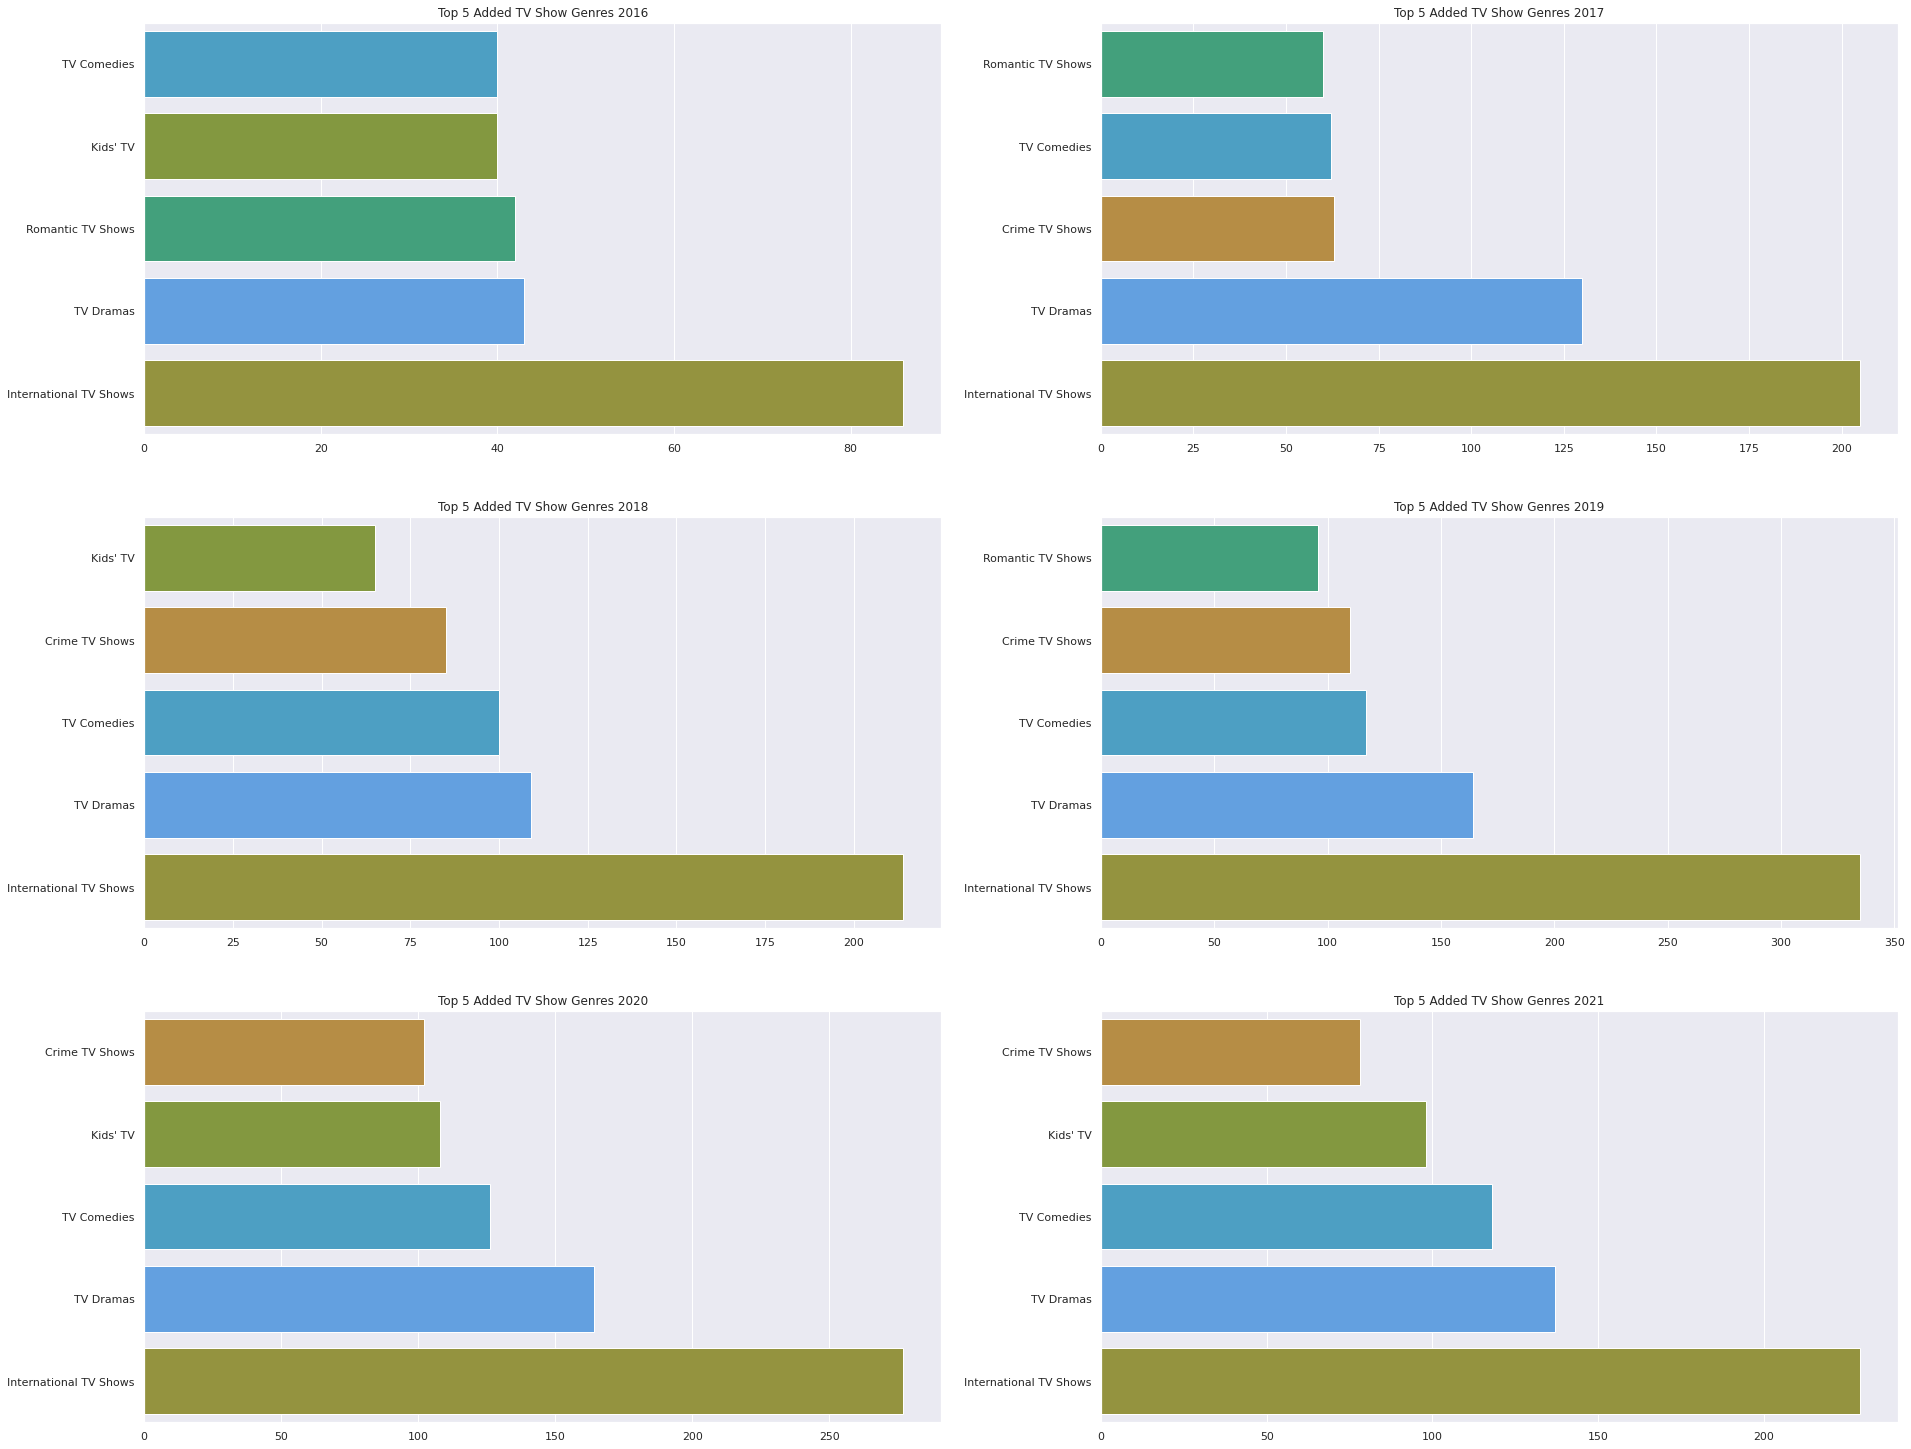

In [ ]:
# added_year 기준 : TV Show
i = 0
fig, ax = plt.subplots(3, 2, figsize=(28, 24))

for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    example = data[(data['year_added']==year)&(data['type']=='TV Show')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_year_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_year_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(3, 2, i)
    sns.barplot(y=n, x=w, palette=tv_palette)
    plt.title('Top 5 Added TV Show Genres {}'.format(year))
    
plt.show()

tv shows의 경우 International TV Shows가 계속해서 가장 많이 추가되고 있으며, Dramas, Comedies, Kid's, Crime TV Show가 계속해서 많이 추가되는 추세이다. 

#### 월별 영화 및 TV Show 장르 순위 (added month)

##### added_month 기준 : Movies

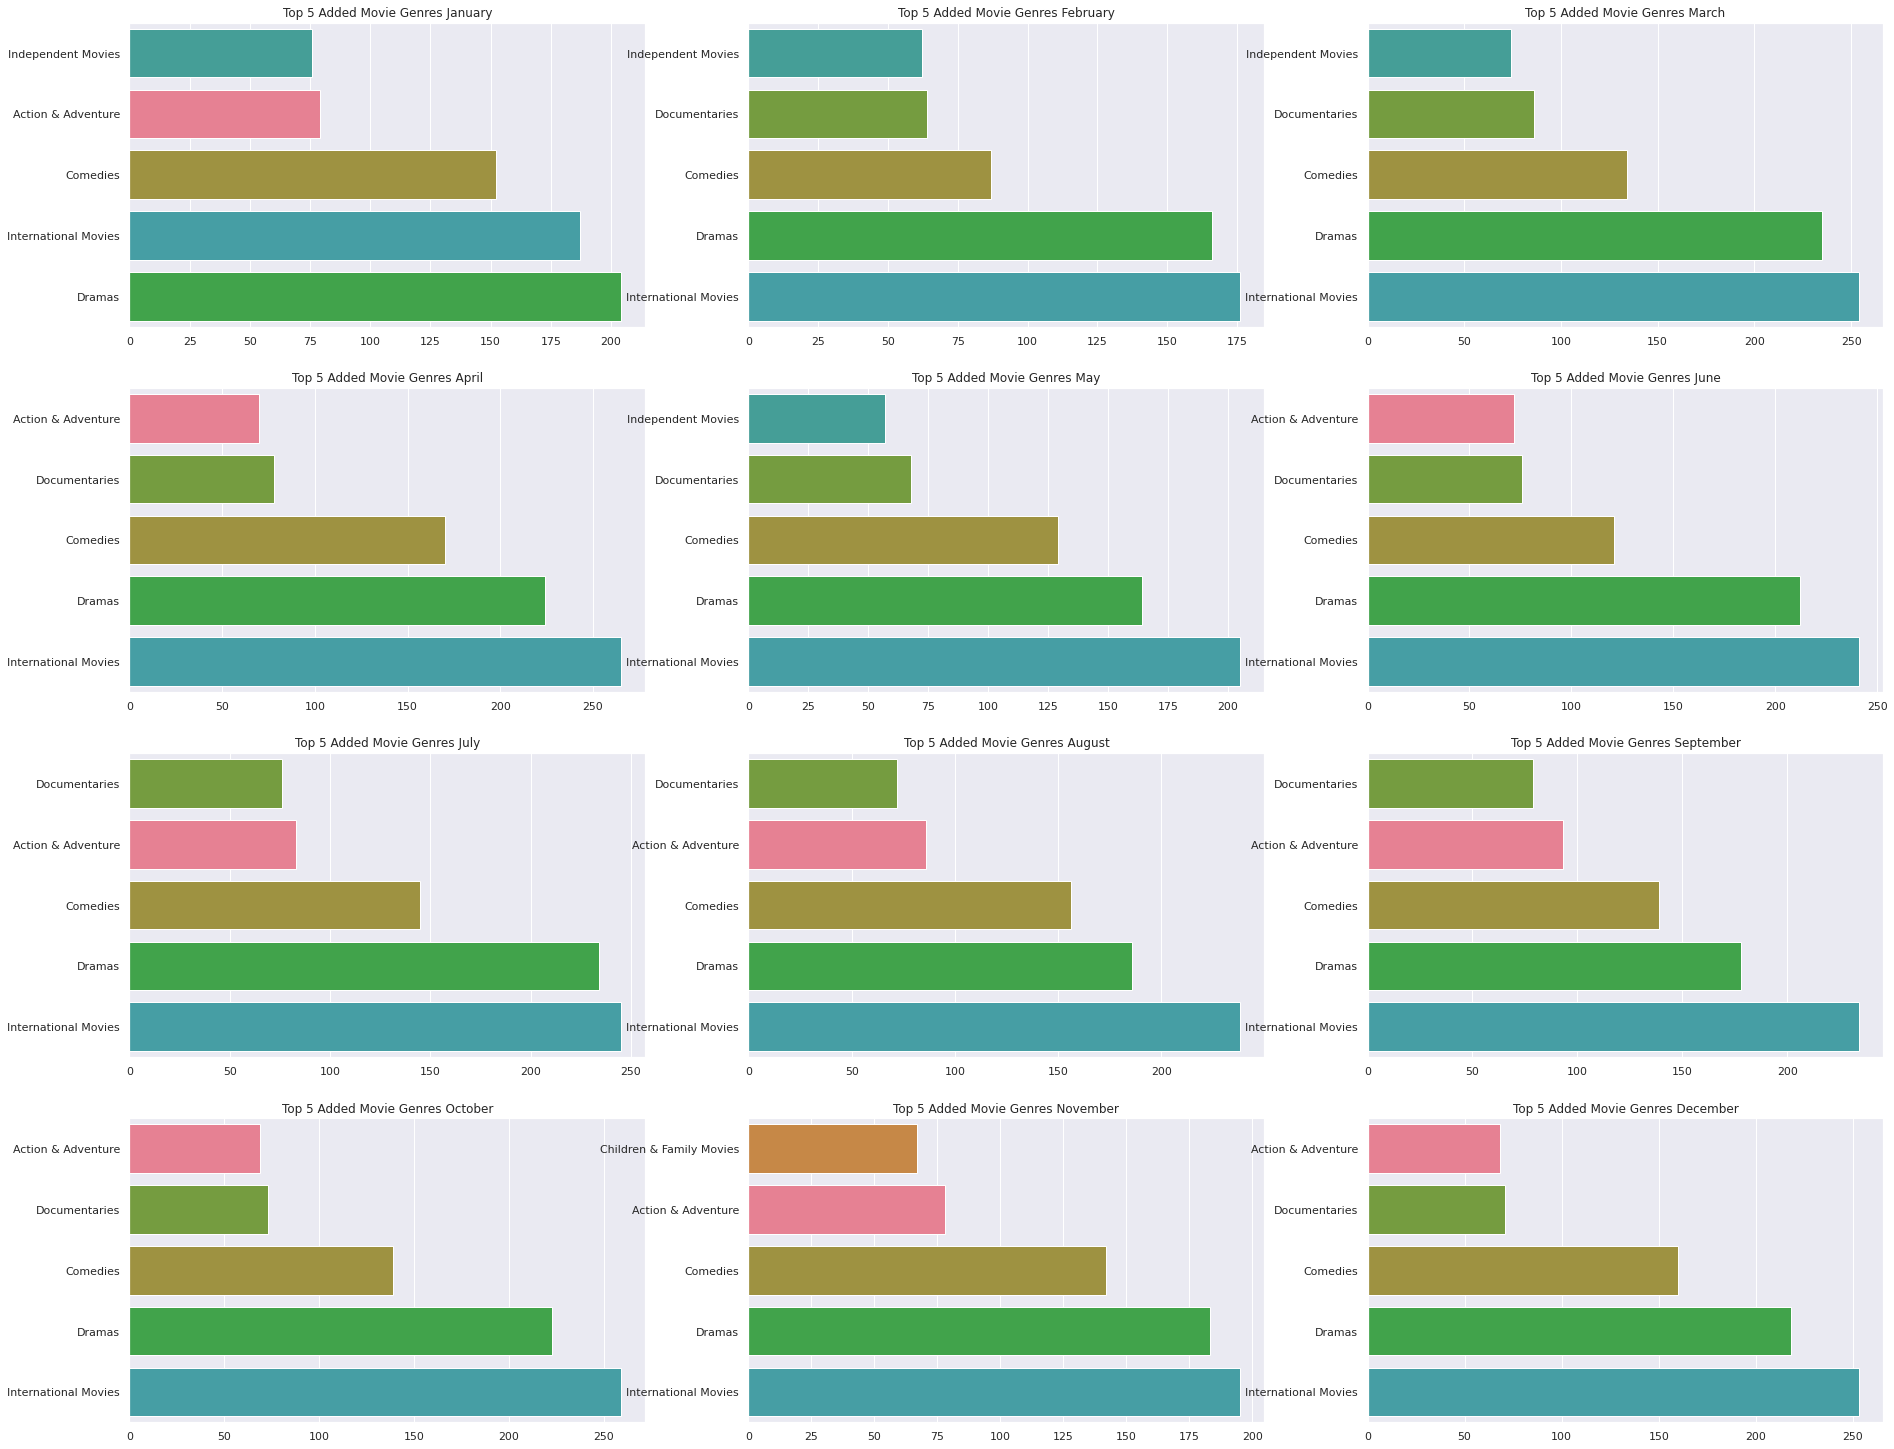

In [ ]:
# added_month 기준 : Movies
i = 0
fig, ax = plt.subplots(4, 3, figsize=(28, 24))

palette = {genre:color for genre, color in zip(movie_genres, sns.color_palette('husl', n_colors=len(movie_genres)))}
for month in month_order:
    example = data[(data['month_added']==month)&(data['type']=='Movie')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_month_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_month_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(4, 3, i)
    sns.barplot(y=n, x=w, palette=palette)
    plt.title('Top 5 Added Movie Genres {}'.format(month))
    
plt.show()

위 그래프는 월별로 많이 추가된 영화 장르를 시각화한 것이다. \
월별로 살펴본 장르도 연도에서 크게 벗어나지 않는다.\
1월을 제외하고 가장 많이 추가된 장르는 International Movies이고, Dramas와 Comedies가 뒤를 잇는다. 

그 다음으로 다큐와 액션 영화가 주로 많이 추가되는데, 2, 3, 5월에는 액션 영화 대신 독립영화가 많이 추가되었다.\
11월에는 Children & Family Movies가  보이는데, 이는 미국의 추수감사절과 같은 문화의 영향이 있는 것으로 보인다.

##### added_month 기준 : TV Show

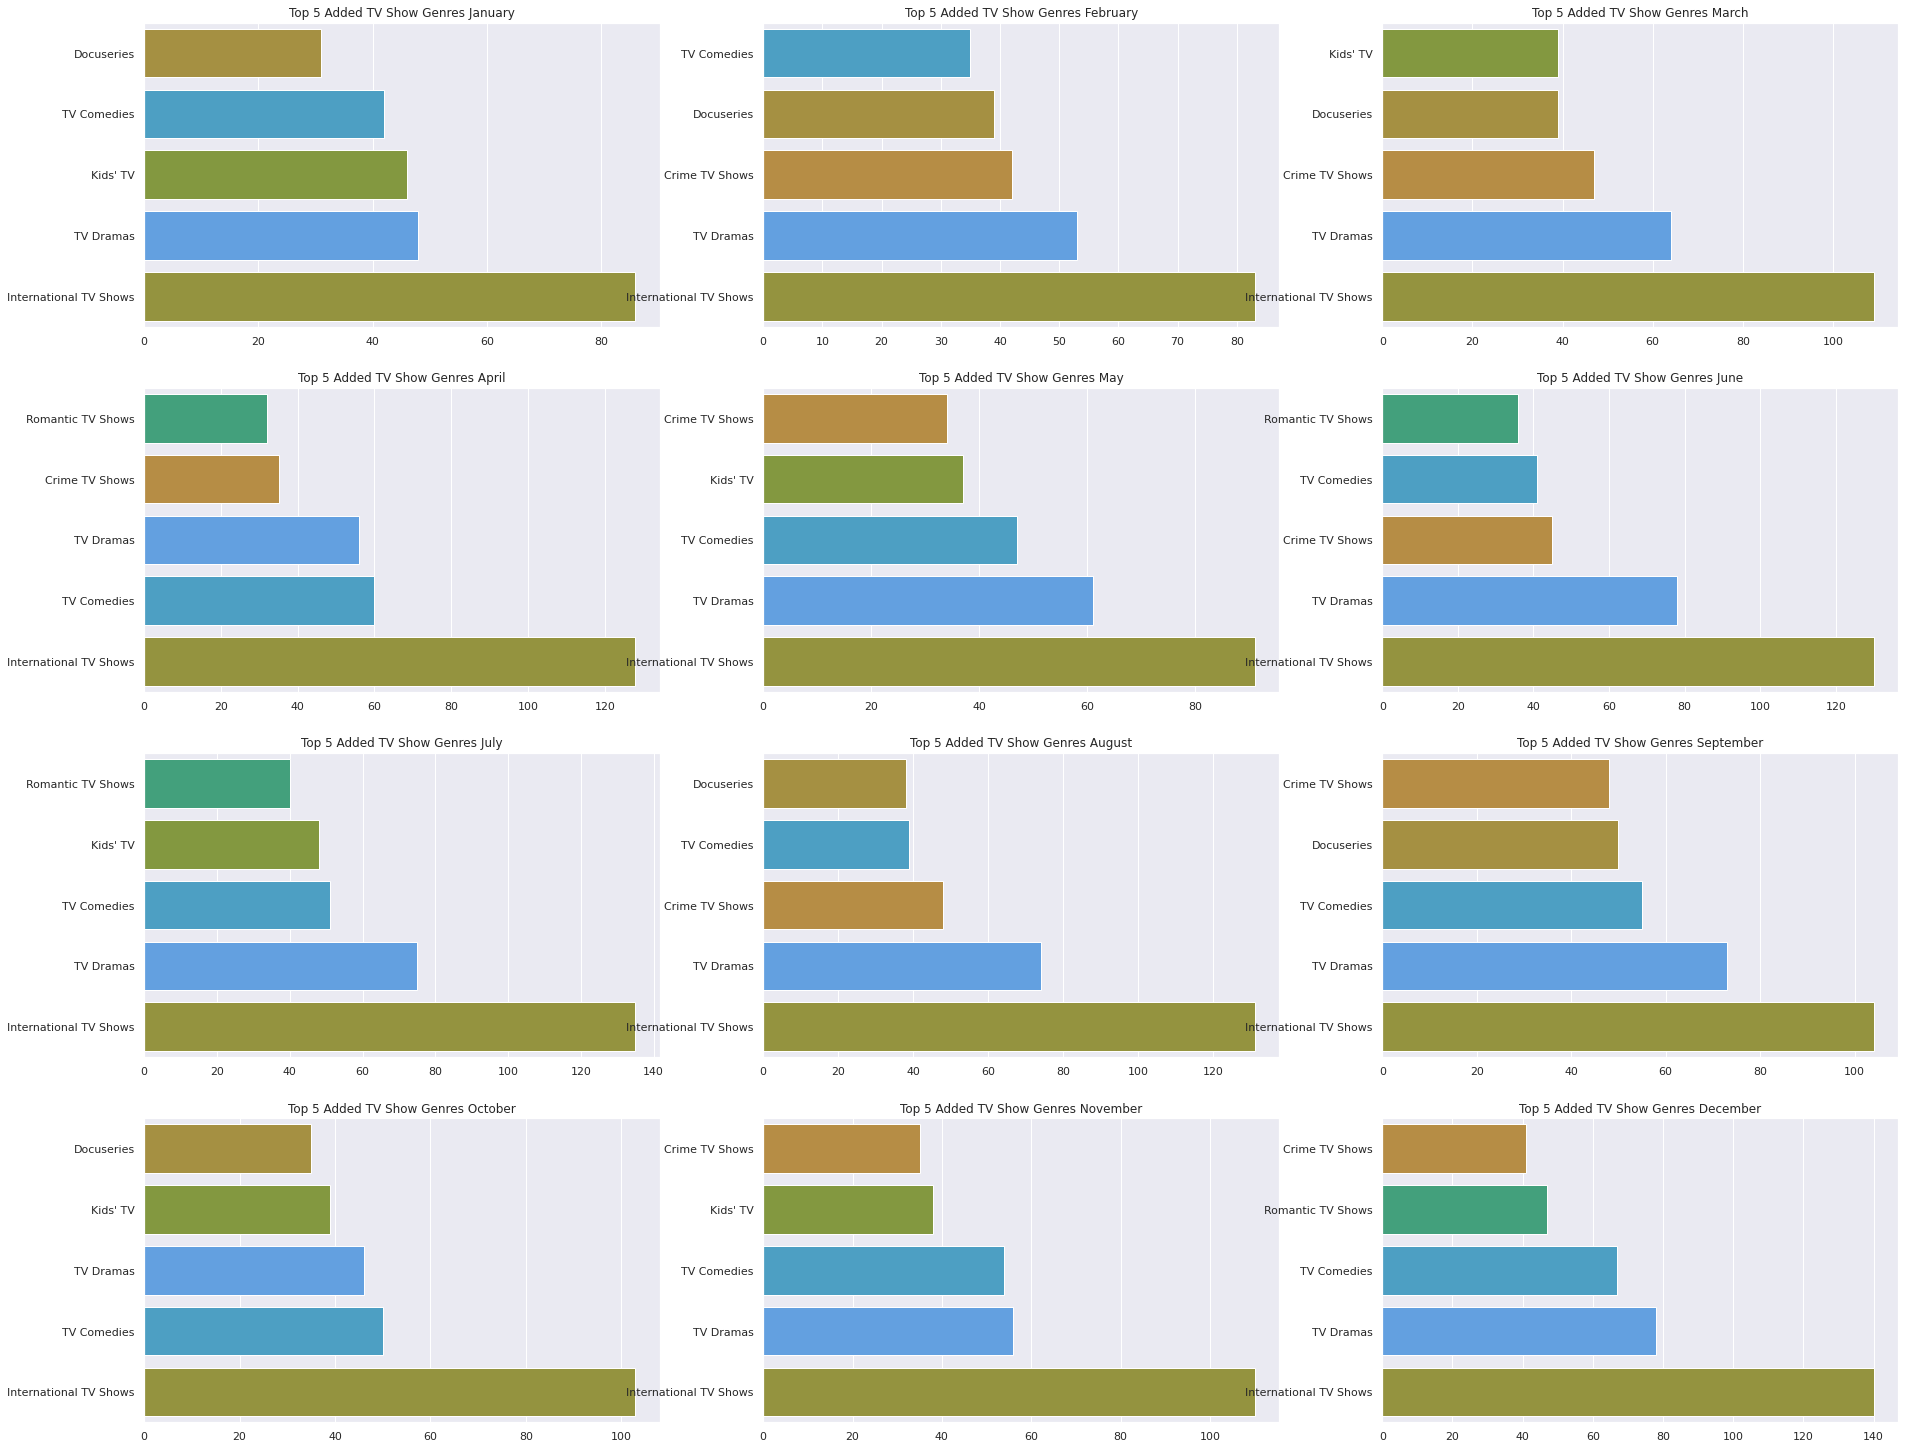

In [ ]:
# added_month 기준 : TV Show
i = 0
fig, ax = plt.subplots(4, 3, figsize=(28, 24))

for month in month_order:
    example = data[(data['month_added']==month)&(data['type']=='TV Show')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_month_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_month_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(4, 3, i)
    sns.barplot(y=n, x=w, palette=tv_palette)
    plt.title('Top 5 Added TV Show Genres {}'.format(month))
    
plt.show()

tv show의 경우 주로 나타나는 장르는 역시 International TV Shows와 Dramas, Comedies, Docuseries, Crime TV Shows등이다.\
12월의 경우 Romantic TV Shows가 이전보다 높은 비율로 나타나는데 크리스마스의 영향이 있어 보인다.

## 시간에 따라 국가별로 어떤 장르가 인기가 많아지는가?

### 국가별로 연도에 따라 자주 나온 장르 >> 이거 빼버릴까요?

In [ ]:
data_us = data[data['country']=='United States']
data_us.shape

(2818, 56)

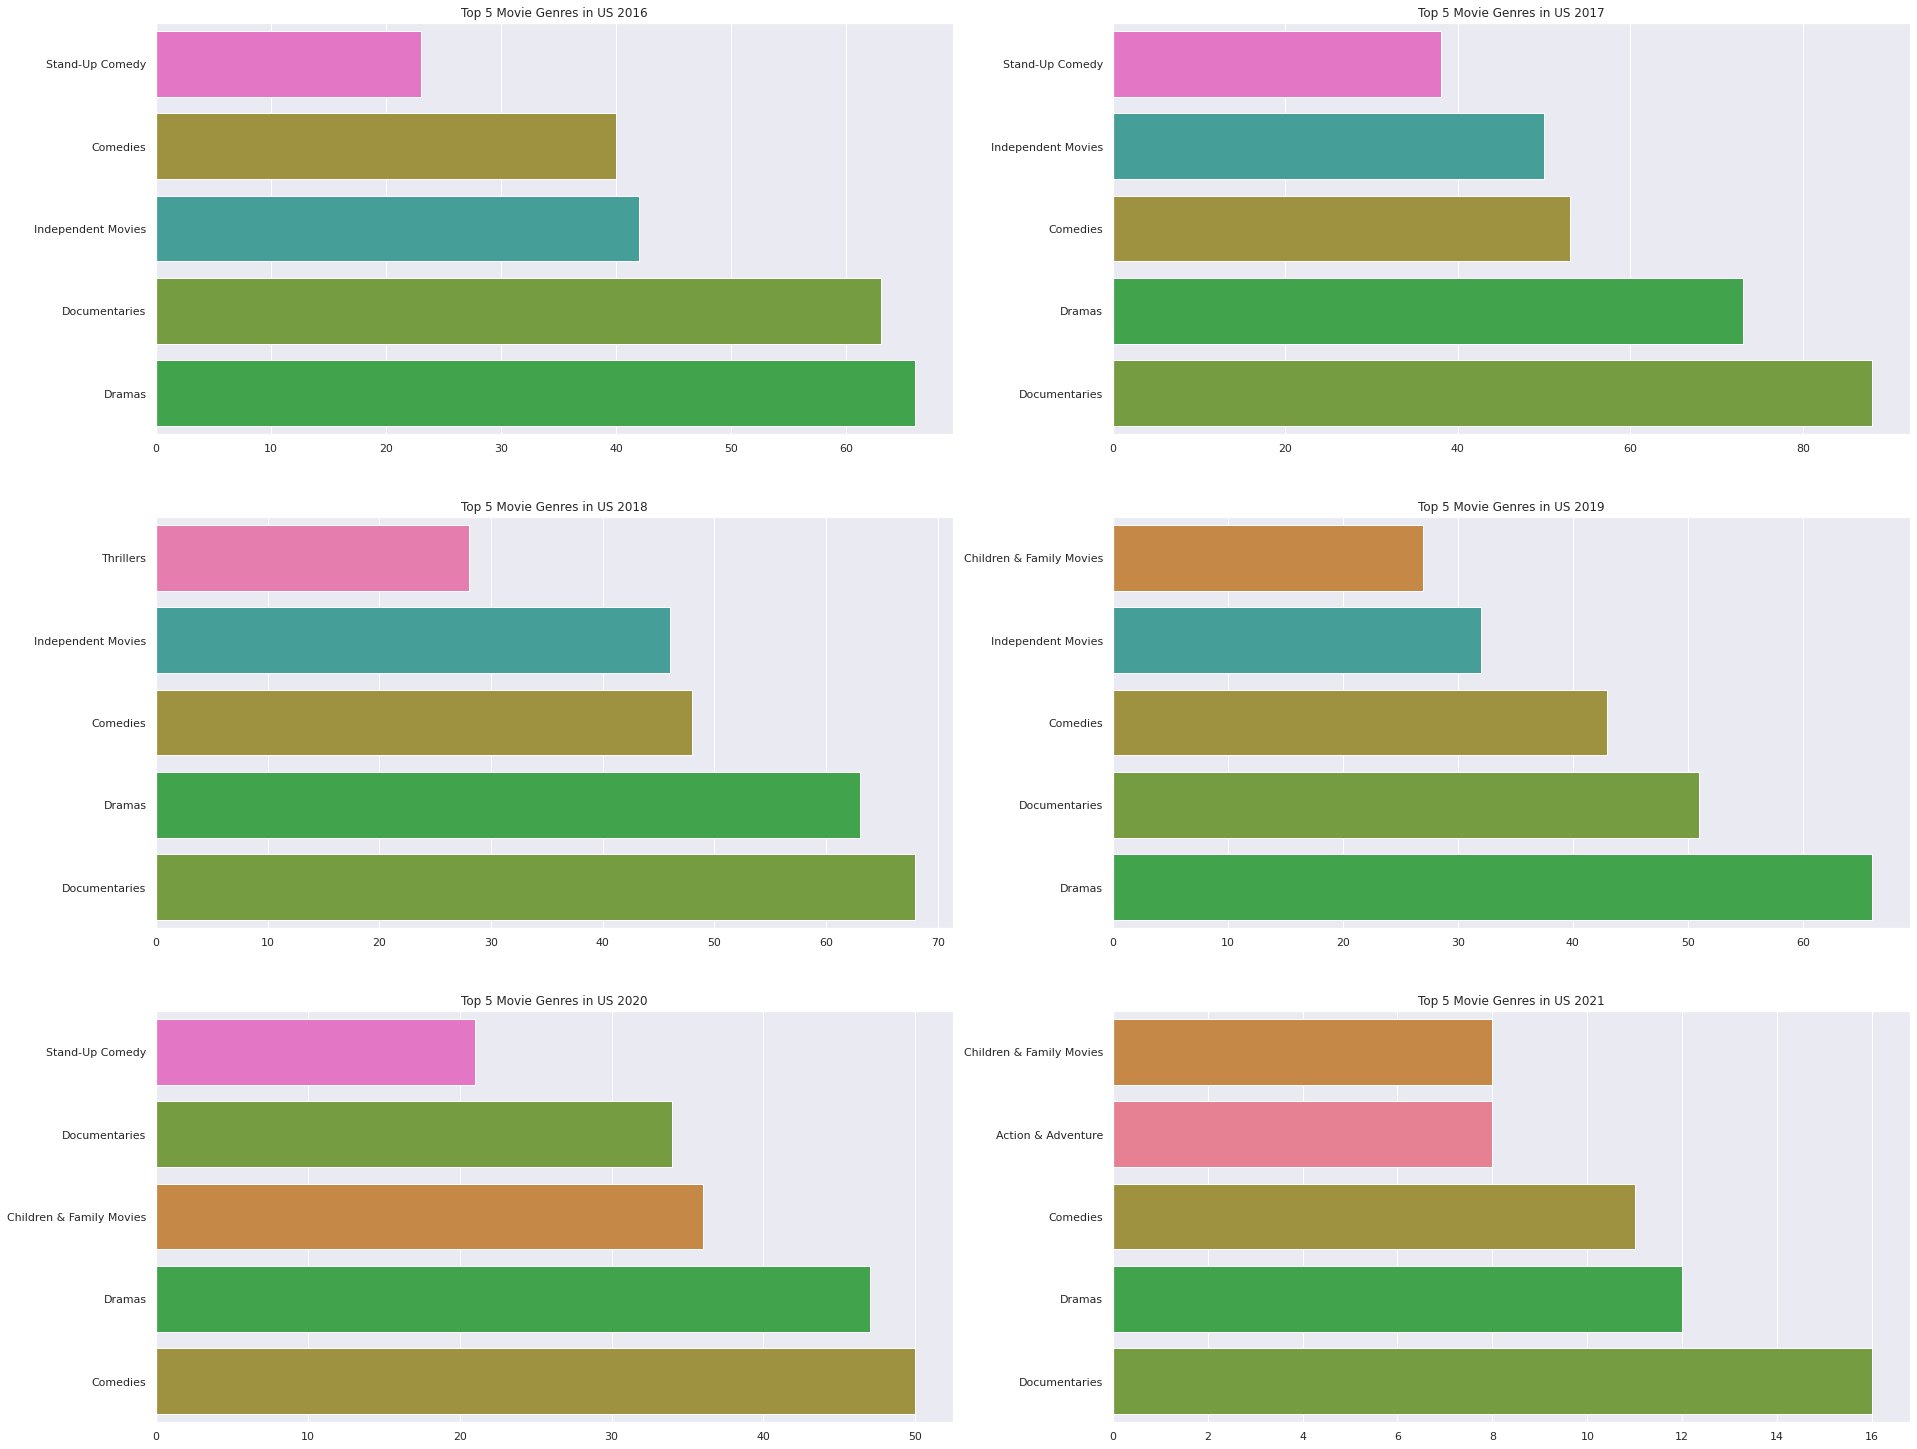

In [ ]:
# release_year 기준 : Movies : US
i = 0
fig, ax = plt.subplots(3, 2, figsize=(28, 24))

for year in range(2016, 2022):
    example = data_us[(data_us['release_year']==year)&(data_us['type']=='Movie')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_year_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_year_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(3, 2, i)
    sns.barplot(y=n, x=w, palette=movie_palette)
    plt.title('Top 5 Movie Genres in US {}'.format(year))
    
plt.show()

### 연도별로 국가에 따라 자주 나온 장르

In [ ]:
country_name = ['United States', 'India', 'United Kingdom', 'Japan', 'South Korea', 'Canada']

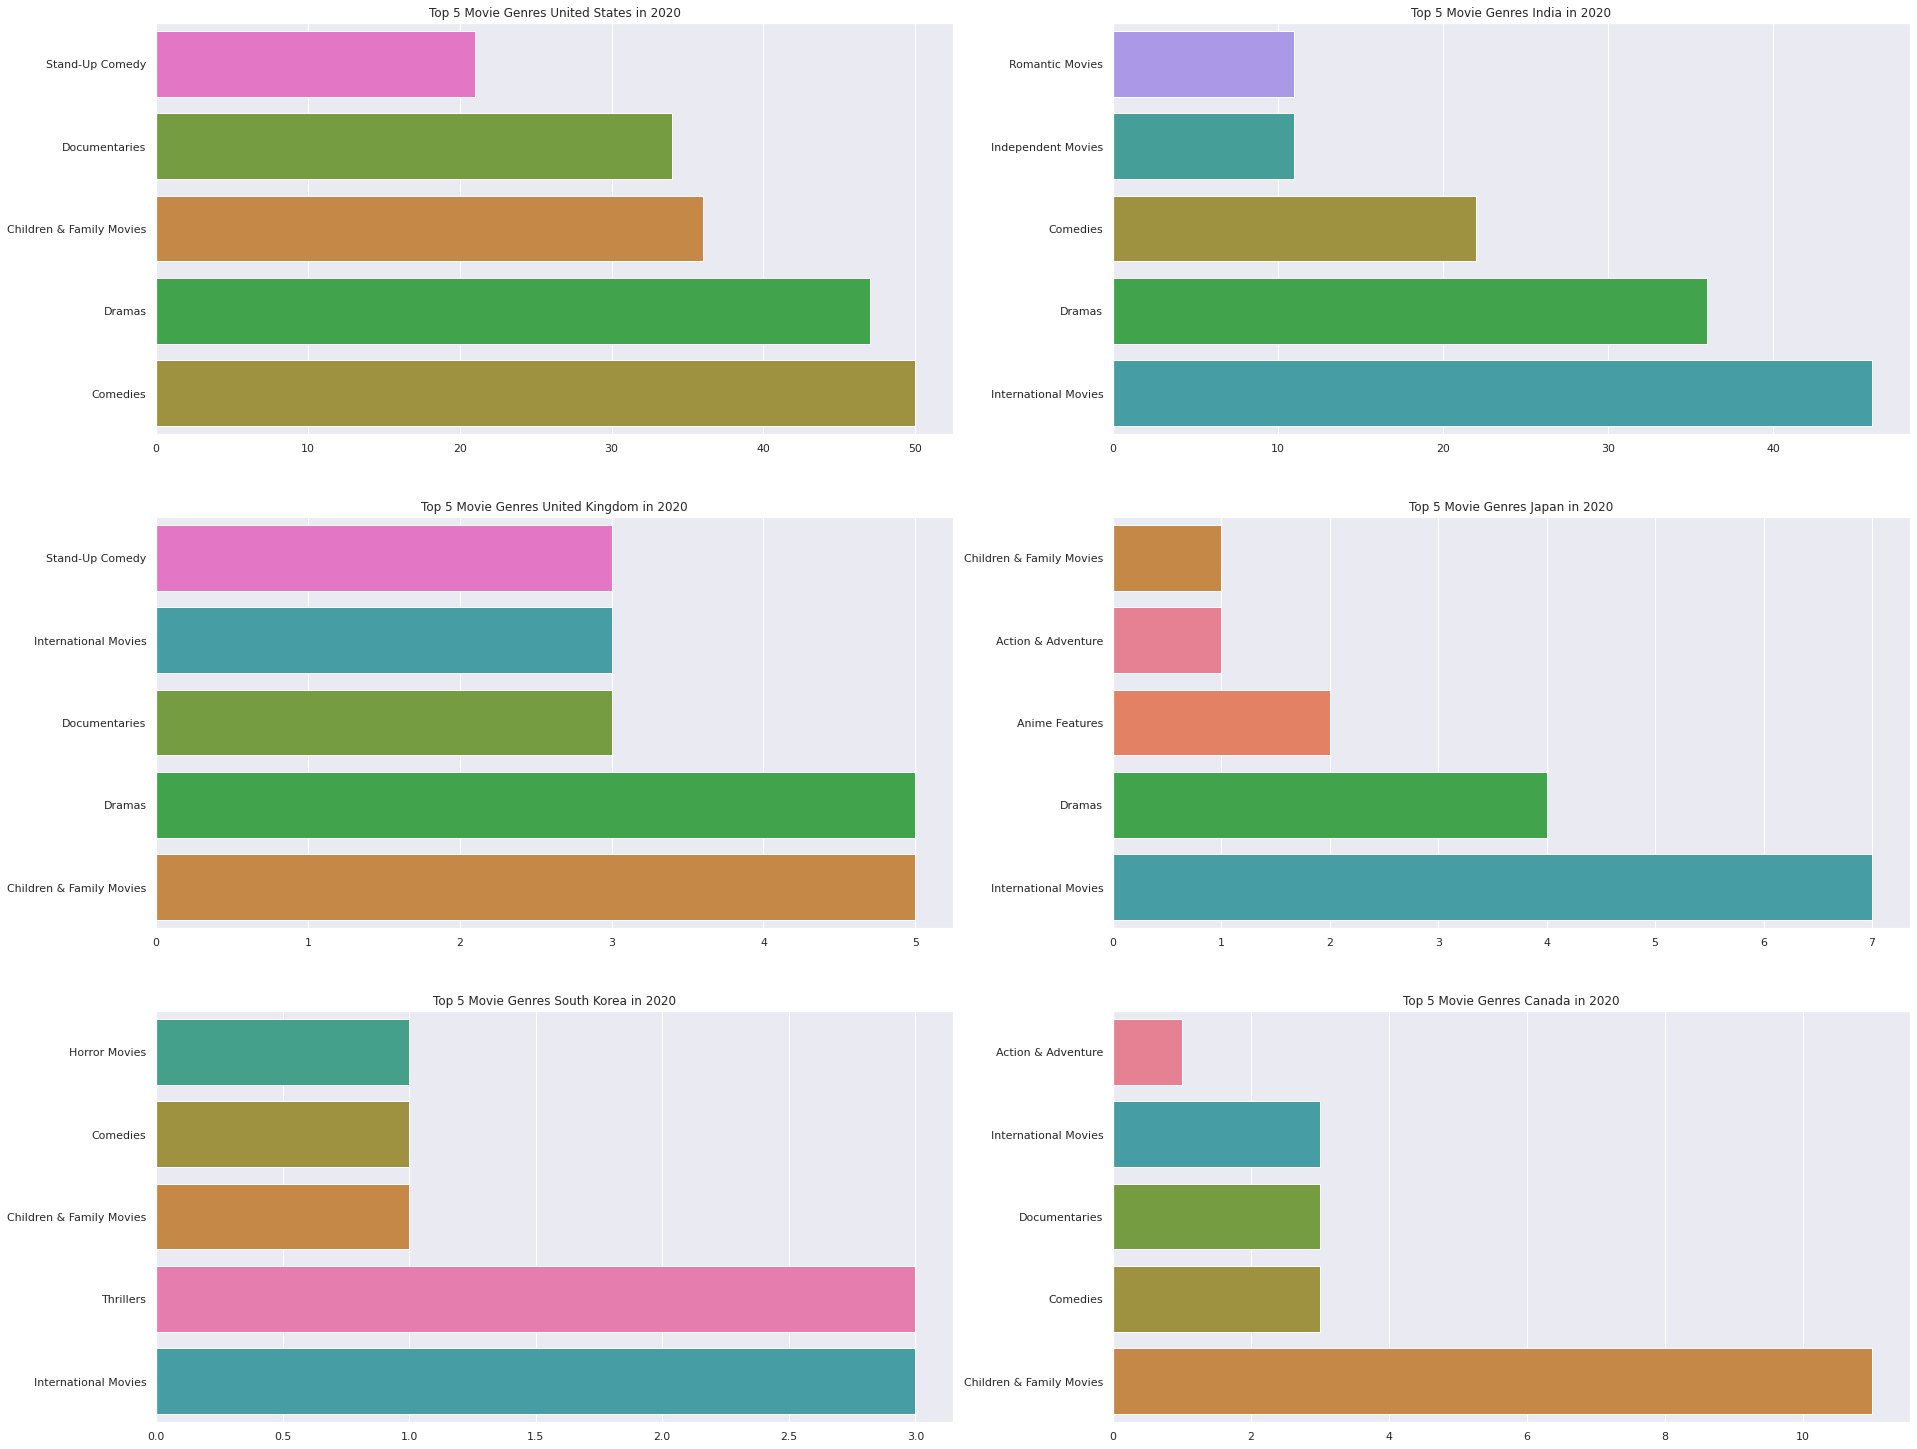

In [ ]:
# release_year 기준 : Movies : 2020
data_year = data[data['release_year']==2020]

i = 0
fig, ax = plt.subplots(3, 2, figsize=(28, 24))

for country in country_name:
    example = data_year[(data_year['country']==country)&(data_year['type']=='Movie')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_year_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_year_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(3, 2, i)
    sns.barplot(y=n, x=w, palette=movie_palette)
    plt.title('Top 5 Movie Genres {} in 2020'.format(country))
    
plt.show()

### 월별로 국가에 따라 자주 나온 장르




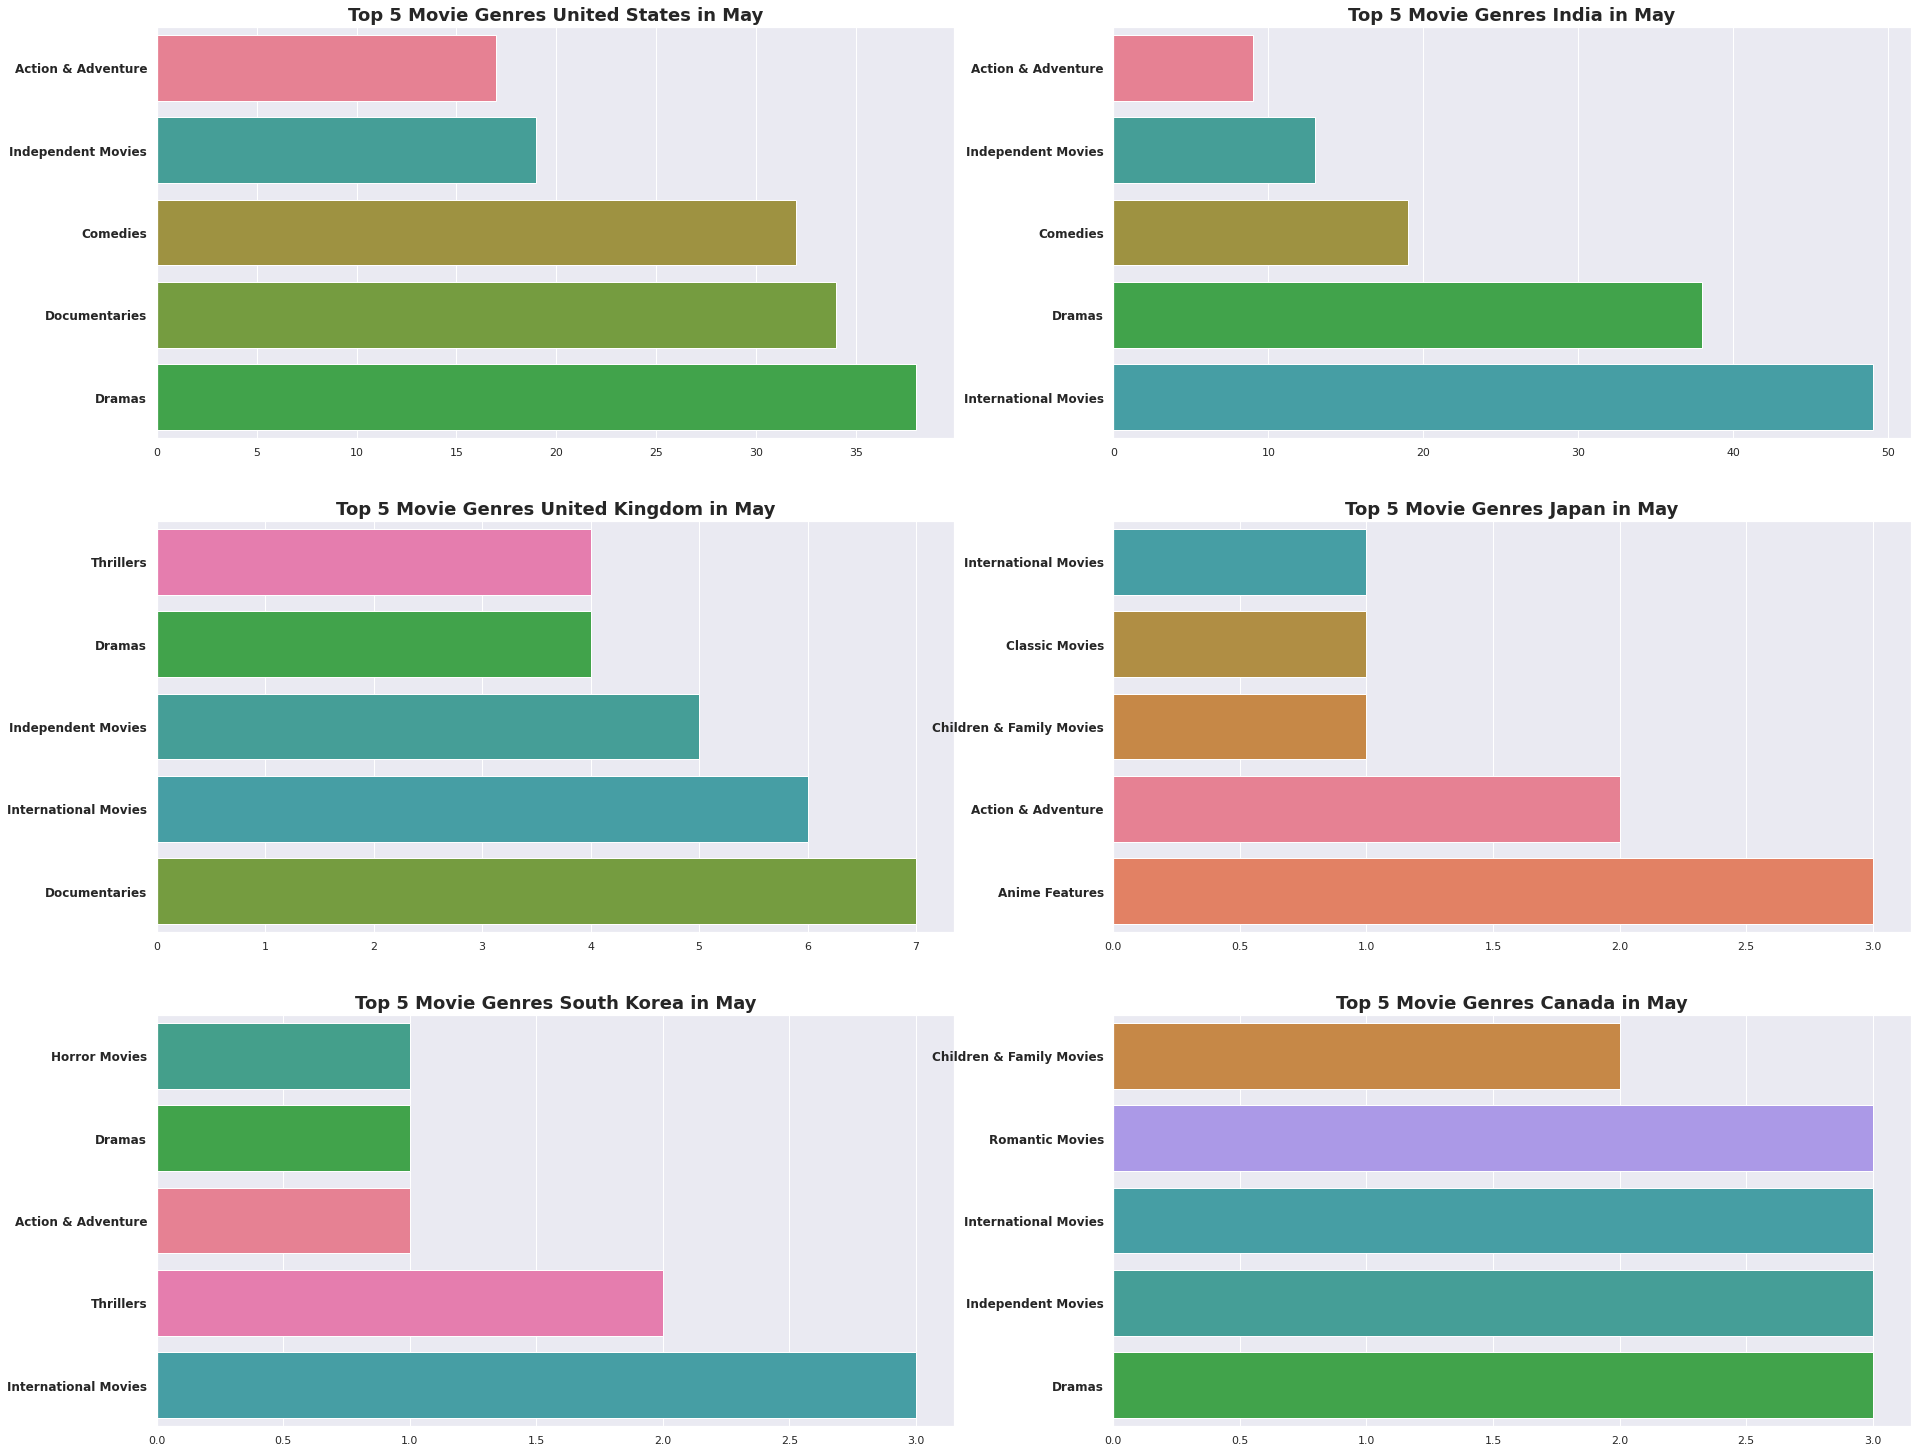

In [ ]:
# 월 고정 -> release year의 month 였으면 더 의미 있었을 듯
data_month = data[data['month_added']=='May']

i = 0
fig, ax = plt.subplots(3, 2, figsize=(28, 24))

for country in country_name:
    example = data_month[(data_month['country']==country)&(data_month['type']=='Movie')].iloc[:, 14:].sum()
    example = example[example > 0]
    ex = example.to_dict()
    
    sorted_month_genr = sorted(ex, key = ex.get, reverse=True)
    
    n = sorted_month_genr[:5][::-1]
    w = [ex[key] for key in n] 
    
    i += 1
    plt.subplot(3, 2, i)
    sns.barplot(y=n, x=w, palette=movie_palette)
    plt.title('Top 5 Movie Genres {} in May'.format(country), fontsize = 18, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
plt.show()

## 연도별 rating 분포 변화
- 4 : 18세이상: TV-MA, R, NC-17 
- 3 : 15세이상: TV-14,TV-PG,PG-13,PG,
- 2 : 7세 이상: TV-Y7, TV-Y7-FV
- 1 : 모든 연령층: TV-Y,TV-G,G,
- 0 : 기타 : NR(NOT RATED), UR(UNRATED) , NAN 

### 전체 데이터의 연도별, 월별 rating

In [ ]:
year_order = range(2008,2022)
year_order_15 = range(2015,2022)

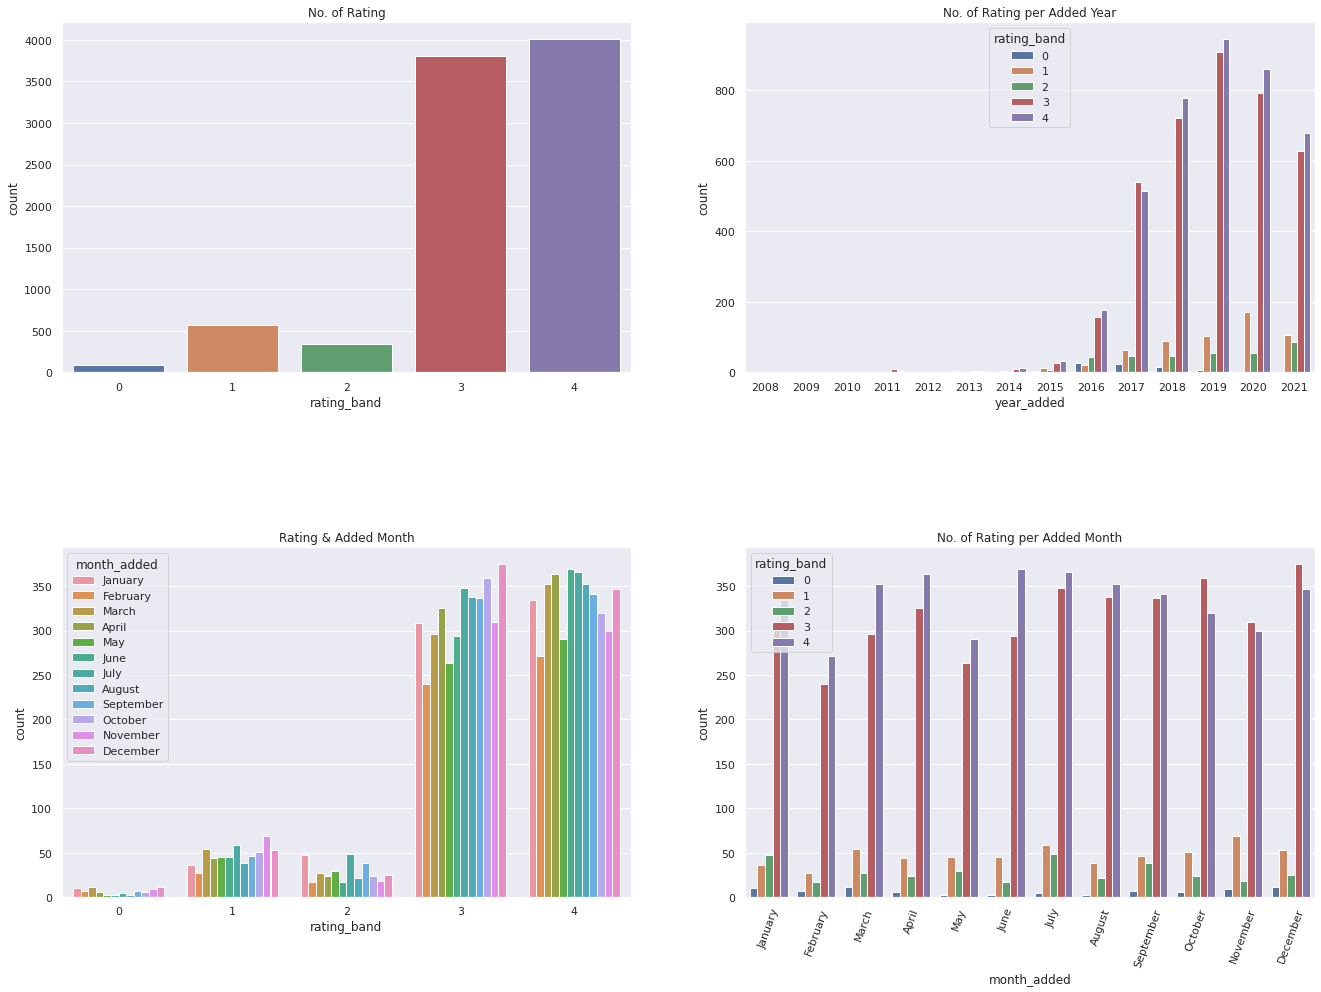

In [ ]:
# 전체 데이터 
f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('rating_band', data=ratings, ax=ax[0,0])
ax[0,0].set_title('No. of Rating')

sns.countplot('year_added', hue='rating_band', data=ratings, order = year_order, ax=ax[0,1])
ax[0,1].set_title('No. of Rating per Added Year')

sns.countplot('rating_band', hue='month_added', data=ratings, hue_order=month_order, ax=ax[1,0])
ax[1,0].set_title('Rating & Added Month')

sns.countplot('month_added', hue='rating_band', data=ratings, order=month_order, ax=ax[1,1])
plt.xticks(rotation=70)
ax[1,1].set_title('No. of Rating per Added Month')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

위 그래프는 전체 컨텐츠에 대한 관람 등급을 연도별, 월별로 시각화한 것이다.\
- 전체 컨텐츠에서 가장 많이 나온 등급은 3, 4 번이다. 3번은 15세 이상, 4번은 19세 이상의 관람 등급을 가지는데, 넷플릭스의 이런 관람등급 분포를 보니 자극적인 컨텐츠를 통해 성인을  주 타겟으로 삼는 듯 하다.
- 연도 별로 등급의 추이를 보니, 2018년부터 계속 청불 등급의 컨텐츠가 많이 추가되고 있음을 알 수 있다.
- 월 별로 나타낸 등급을 보면, 청불 등급의 컨텐츠(4)가 계속 많이 추가되다가, 10월부터 12월까지는 다른 등급의 컨텐츠가 더 많이 추가된 것을 알 수 있다. 아까도 말했지만, 추수감사절이나 크리스마스와 같은 연휴가 영향을 미친게 아닐까 싶다.

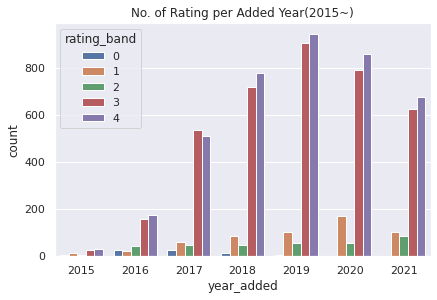

In [ ]:
# 두 번째 그래프에서 15년도 이후 3, 4 번 rating만 자세히 확인
data_over15 = ratings[ratings['year_added']>=2015]
sns.countplot('year_added', hue='rating_band', data=data_over15, order = year_order_15)
plt.title('No. of Rating per Added Year(2015~)')
plt.show()

### 영화 및 tv 데이터의 연도별, 월별 rating

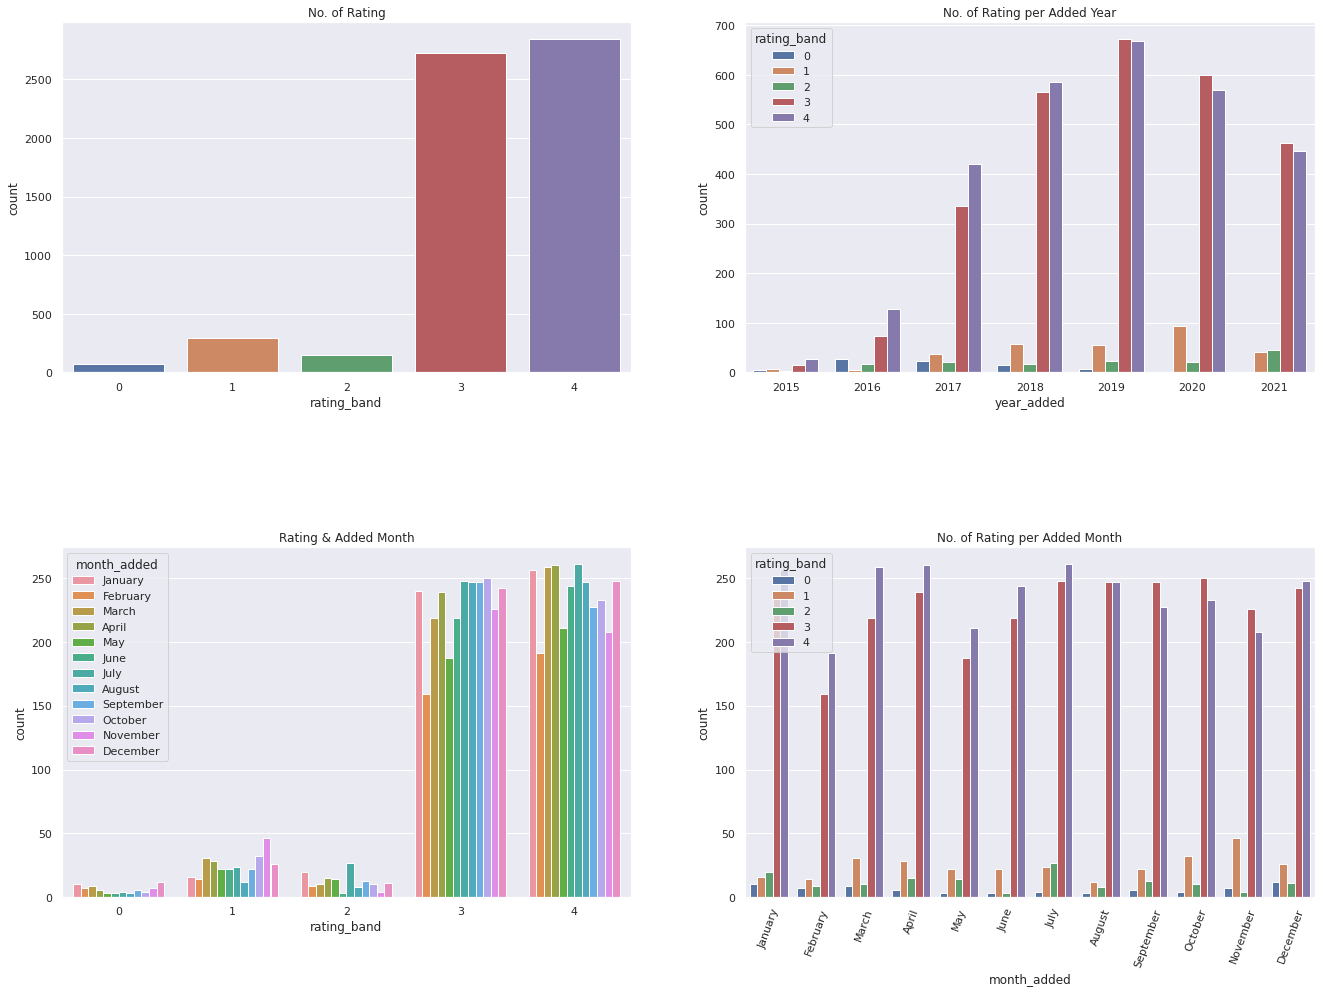

In [ ]:
# 영화 데이터 (15년도 이후부터)
data_rm = ratings[(ratings['type']=='Movie')&(ratings['year_added']>=2015)]

f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('rating_band', data=data_rm, ax=ax[0,0])
ax[0,0].set_title('No. of Rating')

sns.countplot('year_added', hue='rating_band', data=data_rm, order = year_order_15, ax=ax[0,1])
ax[0,1].set_title('No. of Rating per Added Year')

sns.countplot('rating_band', hue='month_added', data=data_rm, hue_order=month_order, ax=ax[1,0])
ax[1,0].set_title('Rating & Added Month')

sns.countplot('month_added', hue='rating_band', data=data_rm, order=month_order, ax=ax[1,1])
plt.xticks(rotation=70)
ax[1,1].set_title('No. of Rating per Added Month')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

이는 영화 데이터에 대한 관람등급을 연도별, 월별로 시각화 한 것이다.\
전체 데이터와 크게 다르지 않은 것을 볼 수 있다.\
다만 7세 이상 관람 등급의 영화가 점점 증가하는 것을 볼 수 있다.

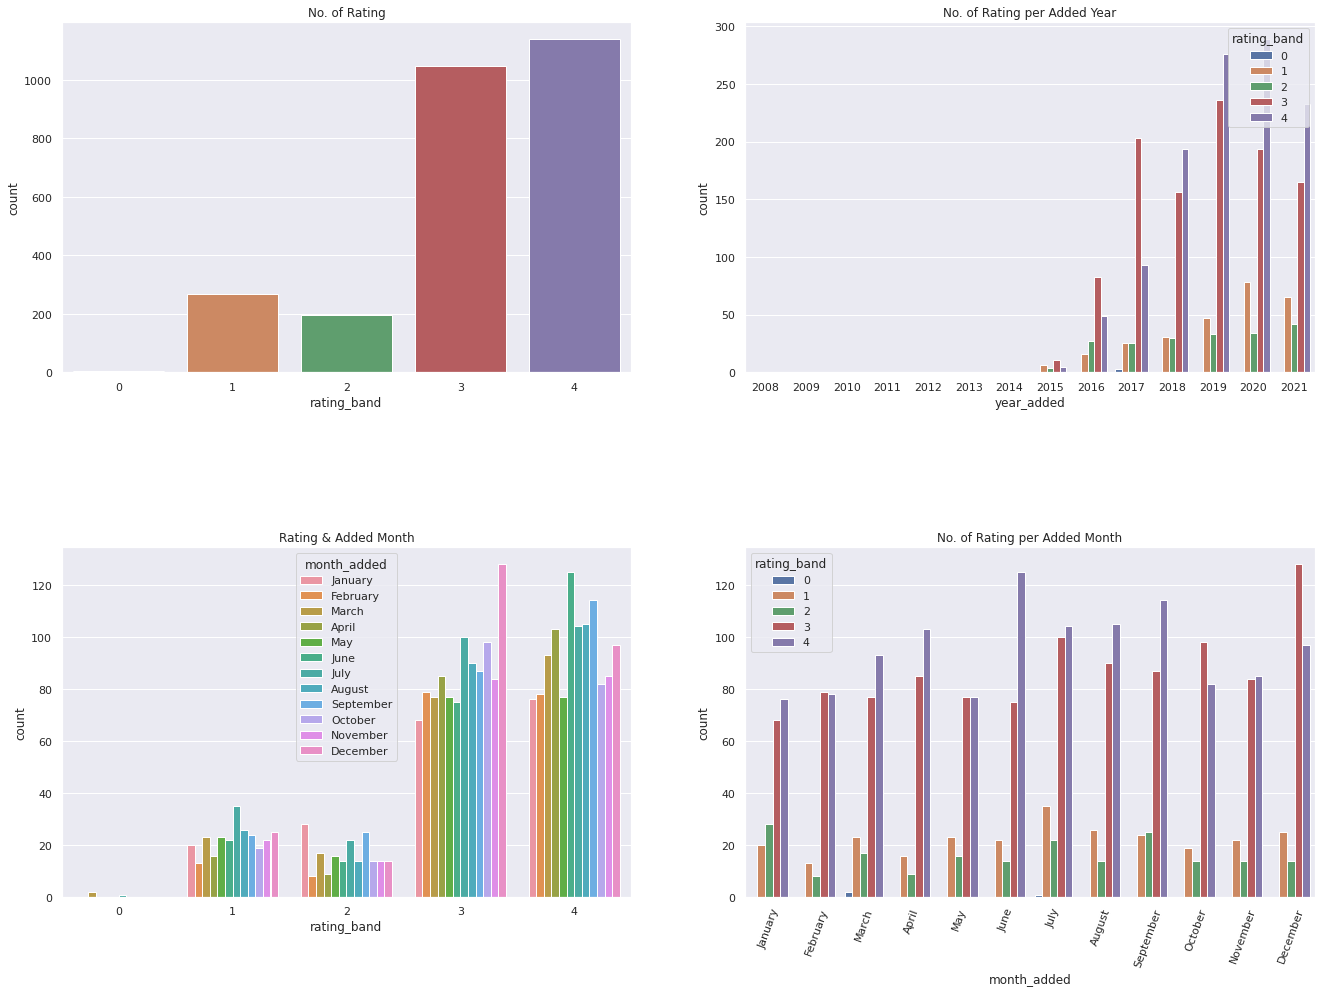

In [ ]:
# TV Show 데이터
data_rt = ratings[(ratings['type']=='TV Show')&(ratings['year_added']>=2015)]

f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('rating_band', data=data_rt, ax=ax[0,0])
ax[0,0].set_title('No. of Rating')

sns.countplot('year_added', hue='rating_band', data=data_rt, order = year_order_15, ax=ax[0,1])
ax[0,1].set_title('No. of Rating per Added Year')

sns.countplot('rating_band', hue='month_added', data=data_rt, hue_order=month_order, ax=ax[1,0])
ax[1,0].set_title('Rating & Added Month')

sns.countplot('month_added', hue='rating_band', data=data_rt, order=month_order, ax=ax[1,1])
plt.xticks(rotation=70)
ax[1,1].set_title('No. of Rating per Added Month')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

tv show의 경우 2016년, 2017년에 15세 이상 등급의 컨텐츠가 많이 추가되었는데, 이후에는 다시 청불 등급의 컨텐츠가 많이 추가된 것을 볼 수 있다.\
1번과 2번 관람 등급과 3번, 4번 관람등급과의 격차가 영화 데이터만큼 크게 차이나지는 않는다. 

### 국가별 rating 비교(연도별, 월별)
국가별로(한.미.인도) 관람 등급을 비교해보자. 

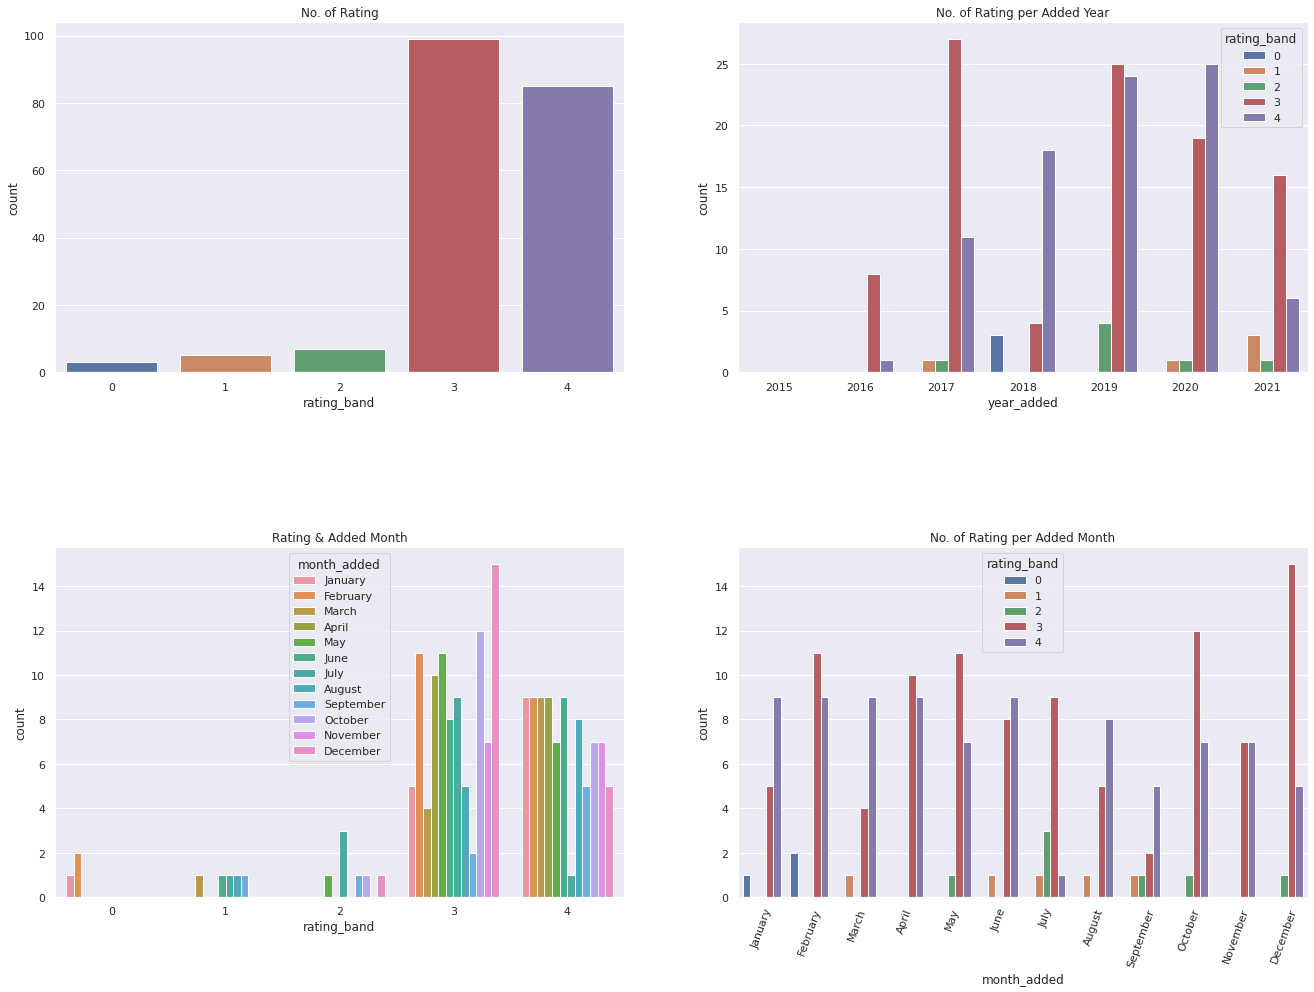

In [ ]:
# 한국 콘텐츠 등급은?
data_rk = ratings[(ratings['country']=='South Korea')&(ratings['year_added']>=2015)]

f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('rating_band', data=data_rk, ax=ax[0,0])
ax[0,0].set_title('No. of Rating')

sns.countplot('year_added', hue='rating_band', data=data_rk, order = year_order_15, ax=ax[0,1])
ax[0,1].set_title('No. of Rating per Added Year')

sns.countplot('rating_band', hue='month_added', data=data_rk, hue_order=month_order, ax=ax[1,0])
ax[1,0].set_title('Rating & Added Month')

sns.countplot('month_added', hue='rating_band', data=data_rk, order=month_order, ax=ax[1,1])
plt.xticks(rotation=70)
ax[1,1].set_title('No. of Rating per Added Month')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

한국의 경우, 전체 데이터와는 달리, 청불 등급보다 15세 이상 등급의 컨텐츠가 더 많은 것을 알 수 있다.

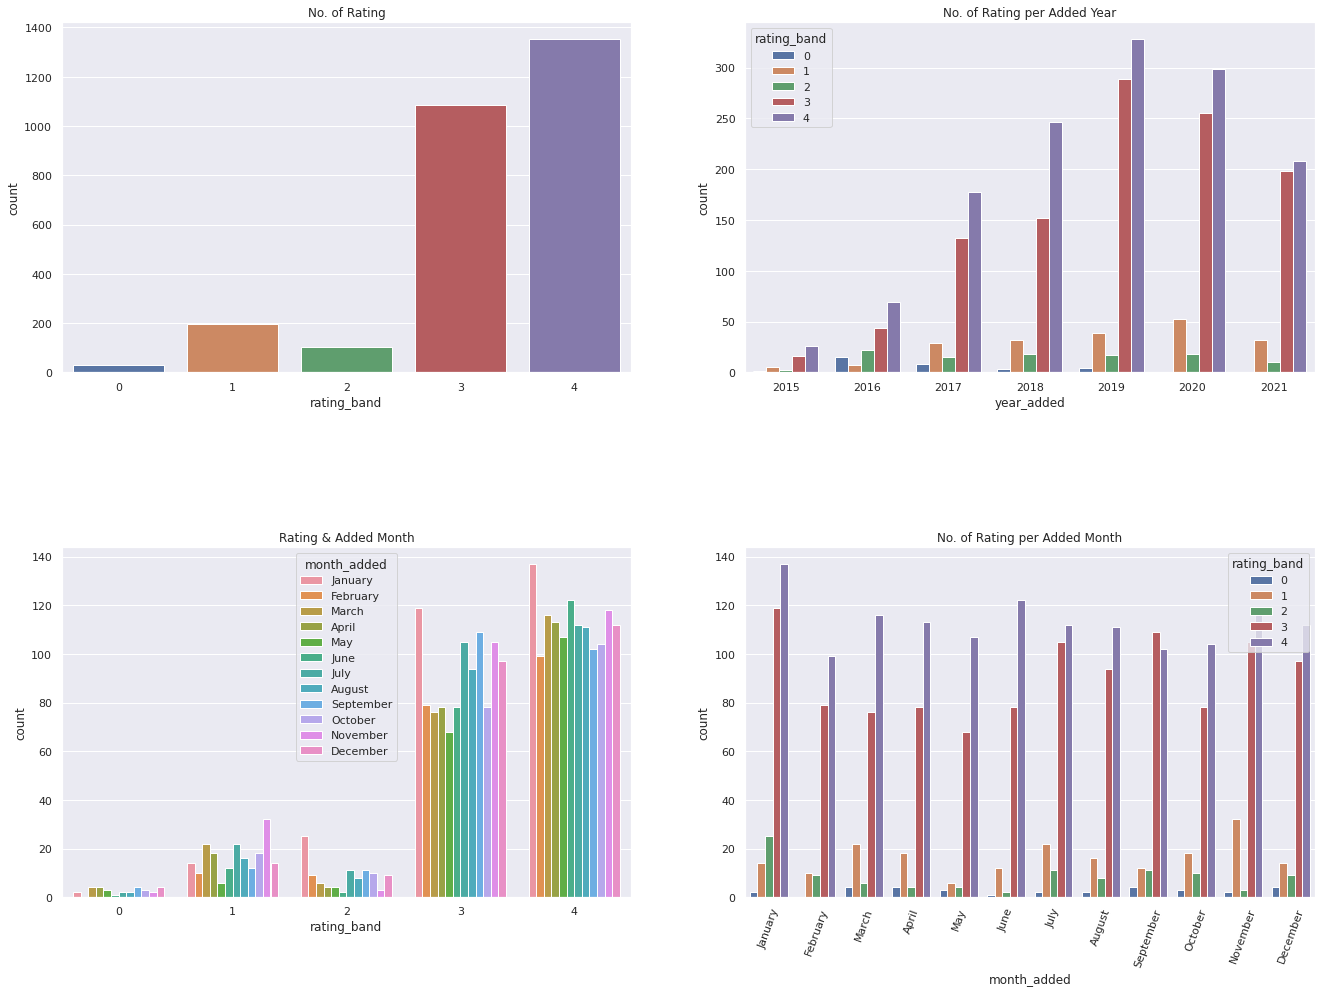

In [ ]:
# 미국
data_rk = ratings[(ratings['country']=='United States')&(ratings['year_added']>=2015)]

f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('rating_band', data=data_rk, ax=ax[0,0])
ax[0,0].set_title('No. of Rating')

sns.countplot('year_added', hue='rating_band', data=data_rk, order = year_order_15, ax=ax[0,1])
ax[0,1].set_title('No. of Rating per Added Year')

sns.countplot('rating_band', hue='month_added', data=data_rk, hue_order=month_order, ax=ax[1,0])
ax[1,0].set_title('Rating & Added Month')

sns.countplot('month_added', hue='rating_band', data=data_rk, order=month_order, ax=ax[1,1])
plt.xticks(rotation=70)
ax[1,1].set_title('No. of Rating per Added Month')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

미국은 언제나 청불 등급의 컨텐츠가 많은 것을 볼 수 있다. \
월 별 데이터를 비교해보니, 9월을 제외하고 모두 청불 등급의 컨텐츠가 가장 많이 추가되었다.\
위에서 미국의 연휴때문에 전체 데이터의 10, 11, 12 월의 컨텐츠 등급이 낮게 나오는 줄 알았는데, 다른 이유가 있는 듯 하다. 

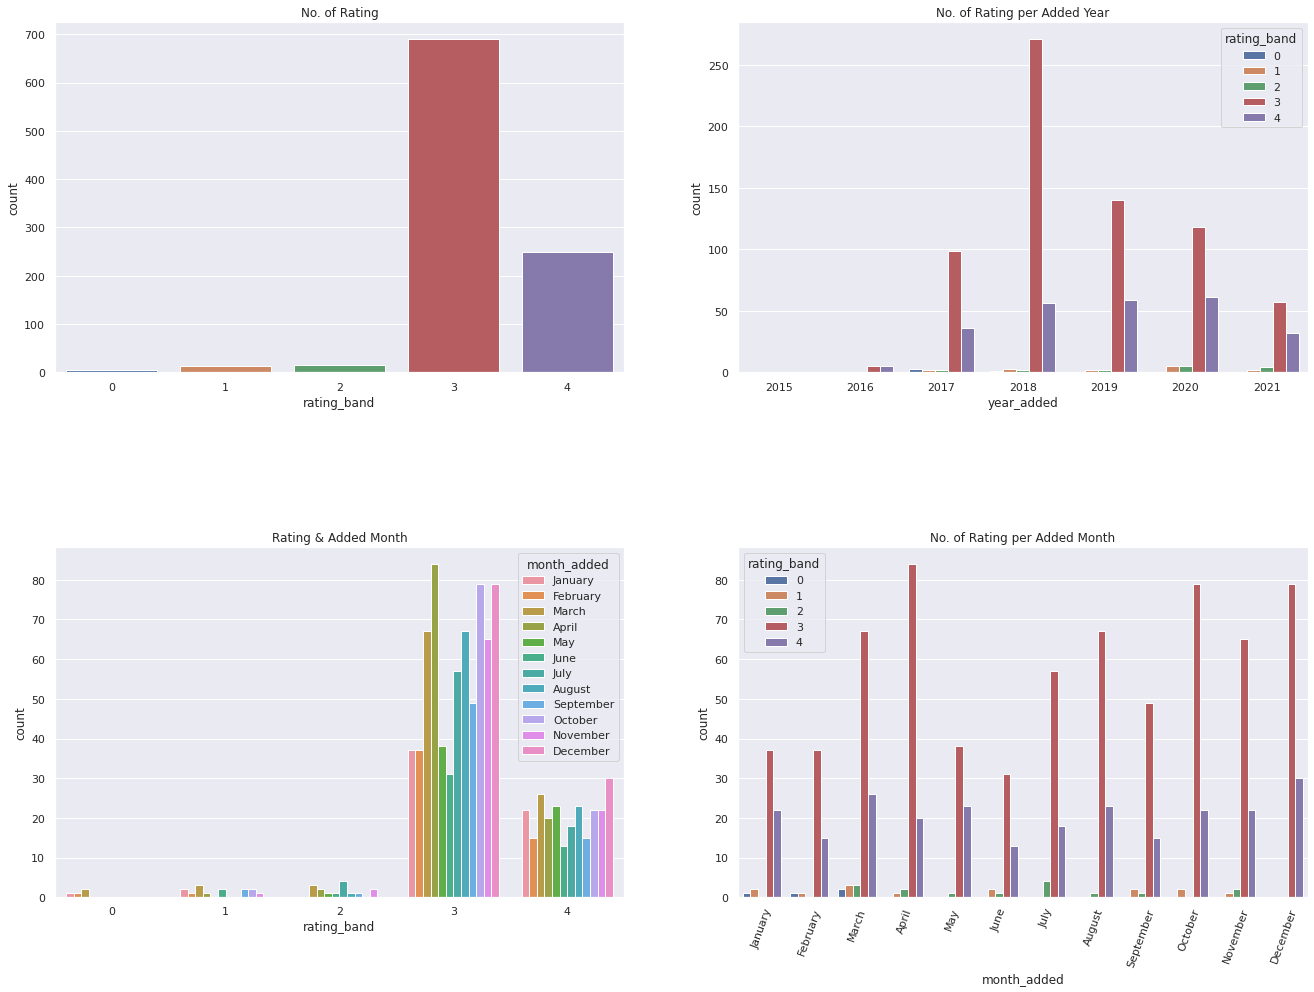

In [ ]:
# 인도
data_rk = ratings[(ratings['country']=='India')&(ratings['year_added']>=2015)]

f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('rating_band', data=data_rk, ax=ax[0,0])
ax[0,0].set_title('No. of Rating')

sns.countplot('year_added', hue='rating_band', data=data_rk, order = year_order_15, ax=ax[0,1])
ax[0,1].set_title('No. of Rating per Added Year')

sns.countplot('rating_band', hue='month_added', data=data_rk, hue_order=month_order, ax=ax[1,0])
ax[1,0].set_title('Rating & Added Month')

sns.countplot('month_added', hue='rating_band', data=data_rk, order=month_order, ax=ax[1,1])
plt.xticks(rotation=70)
ax[1,1].set_title('No. of Rating per Added Month')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

마지막으로 인도 컨텐츠의 관람 등급 그래프이다. \
청불 등급의 컨텐츠가 15세 이상 관람 컨텐츠에 비해 많이 적은 것을 알 수 있다.